# Assignment 2

## Occupancy Detection using MLPs 

In [2]:
%matplotlib notebook
from __future__ import print_function
from itertools import count

import torch
import torch.nn as nn
import torch.autograd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [7]:
#Data manipulation
use_cuda = torch.cuda.is_available()
torch.cuda.manual_seed(1)
torch.manual_seed(1)

train_data = pd.read_csv('./data/train_data.txt', delimiter = ',').drop("date", 1)
test_data = pd.read_csv('./data/test_data.txt', delimiter = ',').drop("date", 1)

train_label, test_label = train_data['Occupancy'], test_data['Occupancy']
train_data, test_data = train_data.drop('Occupancy', 1), test_data.drop('Occupancy', 1)

#Normalize data
train_data = normalize(train_data, axis = 0)
test_data = normalize(test_data, axis = 0)

train_data, train_label = (torch.from_numpy(train_data).float(), 
                      torch.from_numpy(train_label.values).float().unsqueeze(1))
test_data, test_label = (torch.from_numpy(test_data).float(),
                    torch.from_numpy(test_label.values).float().unsqueeze(1))
#Convert to CUDA tensors
if(use_cuda):
    train_data, train_label = train_data.cuda(),train_label.cuda()
    test_data, test_label = test_data.cuda(), test_label.cuda()

#get datasets
train_ = TensorDataset(train_data,train_label)
test_ = TensorDataset(test_data,test_label)

#get data loaders
def get_loader(train_batch_size, test_batch_size):
    train_loader = DataLoader(train_, batch_size = train_batch_size,
                               shuffle = True)
    test_loader = DataLoader(test_, batch_size = test_batch_size,
                              shuffle = True)
    return train_loader, test_loader
# train_label = train_label.values
# test_label = test_label.values

## Ques 1a

In [686]:
#Ques 1a
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(5, 5)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(5, 1)
#         nn.init.xavier_normal(self.fc2.weight.data)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x


In [697]:
def train(model, train_loader, optimizer, criterion):
    train_loss,correct = 0, 0
    total = 0
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        if(use_cuda):
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        
        out = model(x)
        loss = criterion(out, target)
        train_loss += loss.data[0] 
        loss.backward()
#         for param in model.parameters():
#             print(param.grad.data.sum())

#         # start debugger
#         import pdb; pdb.set_trace()
        optimizer.step()
        pred = out.data.float().squeeze()
        pred[pred>=0.5] = 1
        pred[pred<0.5] = 0
        pred = pred.unsqueeze(1)
        total += x.data.size()[0]
        correct += (pred == target.data).sum()
        if((batch_idx+1)%100 == 0 or (batch_idx+1) == len(train_loader)):
            print('==>> batch index: {}, train loss: {:.6f}, accuracy: {:.3f}'.format(
            batch_idx+1, train_loss/len(x.data), (100*correct*1.0)/total))
    return train_loss / len(train_loader.dataset), correct
    
def test(model, test_loader, optimizer, criterion):
    model.eval()
    correct, test_loss = 0,0
    total = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if(use_cuda):
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x, volatile=True), Variable(target, volatile=True)
        out = model(x)
        loss = criterion(out, target)
        pred = out.data.float().squeeze()
        pred[pred>=0.5] = 1
        pred[pred<0.5] = 0
        pred = pred.unsqueeze(1)
        total += x.data.size()[0]
        correct += (pred == target.data).sum()
        test_loss += loss.data[0]
        if((batch_idx+1)%100 == 0 or (batch_idx+1) == len(test_loader)):
            print('==>> batch index: {}, test loss: {:.6f}, accuracy: {:.3f}'.format(
            batch_idx+1, test_loss/len(x.data), (100*correct*1.0)/total))    
    return test_loss / len(test_loader.dataset), correct
        

In [698]:
def ques_1a(epochs, s):
    train_arr = []
    train_acc = []
    test_arr = []
    test_acc= []
    
    train_loader_1a, test_loader_1a = get_loader(len(train_data), len(test_data))
    model1 = Net1()

    if(use_cuda):
        model1 = model1.cuda()
    
    optimizer = optim.SGD(model1.parameters(), lr = 0.01, momentum = 0.9)
    if(s == 'a'):
        criterion = F.binary_cross_entropy
    elif(s=='f'):
        criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        print('Epoch # {}'.format(epoch))
        train_loss, train_c = train(model1, 
                                          train_loader_1a, optimizer, criterion)
        test_loss, test_c = test(model1, 
                                       test_loader_1a, optimizer, criterion)
        train_arr.append([train_loss])
        test_arr.append([test_loss])
        train_acc.append([(100.0*train_c)/len(train_loader.dataset)])
        test_acc.append([(100.0*test_c)/len(test_loader.dataset)])
    return train_arr, test_arr,train_acc, test_acc

In [699]:
epochs_1a = 500
epochs_arr_1a = [i for i in range(epochs_1a)]
train_arr_1a, test_arr_1a, train_acc_1a, test_acc_1a =  ques_1a(epochs_1a, 'a')

train_arr_1a = np.array(train_arr_1a).flatten()
test_arr_1a = np.array(test_arr_1a).flatten()

Epoch # 0
==>> batch index: 1, train loss: 0.000073, accuracy: 78.767
==>> batch index: 1, test loss: 0.000061, accuracy: 78.989
Epoch # 1
==>> batch index: 1, train loss: 0.000073, accuracy: 78.767
==>> batch index: 1, test loss: 0.000061, accuracy: 78.989
Epoch # 2
==>> batch index: 1, train loss: 0.000073, accuracy: 78.767
==>> batch index: 1, test loss: 0.000061, accuracy: 78.989
Epoch # 3
==>> batch index: 1, train loss: 0.000073, accuracy: 78.767
==>> batch index: 1, test loss: 0.000060, accuracy: 78.989
Epoch # 4
==>> batch index: 1, train loss: 0.000072, accuracy: 78.767
==>> batch index: 1, test loss: 0.000060, accuracy: 78.989
Epoch # 5
==>> batch index: 1, train loss: 0.000072, accuracy: 78.767
==>> batch index: 1, test loss: 0.000060, accuracy: 78.989
Epoch # 6
==>> batch index: 1, train loss: 0.000072, accuracy: 78.767
==>> batch index: 1, test loss: 0.000059, accuracy: 78.989
Epoch # 7
==>> batch index: 1, train loss: 0.000071, accuracy: 78.767
==>> batch index: 1, test l

==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 65
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 66
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 67
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 68
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 69
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 70
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 71
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss

Epoch # 127
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 128
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 129
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 130
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 131
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 132
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 133
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 134
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch 

==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 190
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 191
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 192
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 193
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 194
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 195
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 196
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 197
==>> batch i

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 253
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 254
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 255
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 256
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 257
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 258
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 259
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 317
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 318
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 319
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 320
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 321
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 322
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 323
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 380
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 381
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 382
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 383
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 384
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 385
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 386
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 443
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 444
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 445
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 446
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 447
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 448
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 449
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 450
==>> batch i

<IPython.core.display.Javascript object>


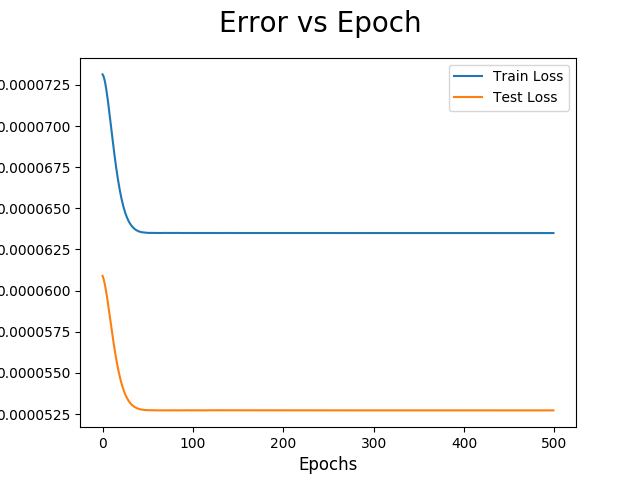

In [700]:
#plotting
fig1 = plt.figure()
plt.plot(epochs_arr_1a,train_arr_1a,label="Train Loss")
plt.plot(epochs_arr_1a,test_arr_1a,label="Test Loss")
plt.legend()
fig1.suptitle('Error vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
# plt.xticks(range(1,11))
plt.show()

## Ques 1b

In [6]:
#1b: Baseline Accuracy
torch.manual_seed(1)
torch.cuda.manual_seed(1)

random_label_train = np.random.randint(2,size=(len(train_data),5))
random_label_test = np.random.randint(2,size=(len(test_data),5))
train_base_pred = torch.from_numpy(np.array(stats.mode(random_label_train, axis = 1)[0].ravel())).unsqueeze(1)
test_base_pred = torch.from_numpy(np.array(stats.mode(random_label_test, axis = 1)[0].ravel())).unsqueeze(1)

train_correct = (train_base_pred.float() == train_label).sum()
test_correct = (test_base_pred.float() == test_label).sum()

train_baseline_loss = F.binary_cross_entropy(Variable(train_base_pred.float()),
                           Variable(train_label)).data[0]/len(train_data)
test_baseline_loss = F.binary_cross_entropy(Variable(test_base_pred.float()),
                           Variable(test_label)).data[0] / len(test_data)

g = nn.MSELoss()
train_baseline_MSE = g(Variable(train_base_pred.float()),
                               Variable(train_label)).data[0]/ len(train_data)
test_baseline_MSE = g(Variable(test_base_pred).float(),
                              Variable(test_label)).data[0] / len(test_data)

train_baseline_accuracy = (100.0*train_correct)/len(train_data)
test_baseline_accuracy = (100.0*test_correct)/len(test_data)
                                            
print('Train loss: {:.3f} Test loss: {:.3f}'.format(
    train_baseline_loss,test_baseline_loss))
print('Train acc: {:.3f} Test acc: {:.3f}'.format(
    train_baseline_accuracy,test_baseline_accuracy))

Train loss: 0.002 Test loss: 0.001
Train acc: 49.638 Test acc: 50.174


In [702]:
#Ques 1c
def ques_1c(epochs, s):
    train_arr = []
    test_arr = []
    train_acc = []
    test_acc = []
    
    train_loader_1c, test_loader_1c = get_loader(100, 100)
    model1 = Net1()

    if(use_cuda):
        model1 = model1.cuda()
    
    optimizer = optim.SGD(model1.parameters(), lr = 0.1, momentum = 0.9, nesterov=True)
    
    if(s == 'c'):
        criterion = F.binary_cross_entropy
    elif(s == 'f'):
        criterion = nn.MSELoss()
        
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1000, 0.1)
    
    for epoch in range(epochs):
        print('Epoch # {}'.format(epoch))
        scheduler.step()
        train_loss, train_c = train(model1, 
                                          train_loader_1c, optimizer, criterion)
        test_loss, test_c = test(model1, 
                                       test_loader_1c, optimizer, criterion)
        train_arr.append([train_loss])
        test_arr.append([test_loss])
        train_acc.append([(100.0*train_c)/len(train_loader.dataset)])
        test_acc.append([(100.0*test_c)/len(test_loader.dataset)])
    return train_arr, test_arr,train_acc, test_acc

In [703]:
epochs_1c = 1500
epochs_arr_1c = [i for i in range(epochs_1c)]
train_arr_1c, test_arr_1c, train_acc_1c, test_acc_1c =  ques_1c(epochs_1c, 'c')

train_arr_1c = np.array(train_arr_1c).flatten()
test_arr_1c = np.array(test_arr_1c).flatten()

Epoch # 0
==>> batch index: 82, train loss: 1.002827, accuracy: 78.767
==>> batch index: 98, test loss: 0.967370, accuracy: 78.989
Epoch # 1
==>> batch index: 82, train loss: 0.986500, accuracy: 78.767
==>> batch index: 98, test loss: 0.969568, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 0.986394, accuracy: 78.767
==>> batch index: 98, test loss: 0.967755, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 0.987512, accuracy: 78.767
==>> batch index: 98, test loss: 0.968527, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 0.985432, accuracy: 78.767
==>> batch index: 98, test loss: 0.971457, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 0.985928, accuracy: 78.767
==>> batch index: 98, test loss: 0.970734, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 0.987254, accuracy: 78.767
==>> batch index: 98, test loss: 0.969502, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 0.985271, accuracy: 78.767
==>> batch i

==>> batch index: 98, test loss: 0.339198, accuracy: 91.448
Epoch # 63
==>> batch index: 82, train loss: 0.262194, accuracy: 98.342
==>> batch index: 98, test loss: 0.310392, accuracy: 97.108
Epoch # 64
==>> batch index: 82, train loss: 0.251755, accuracy: 98.453
==>> batch index: 98, test loss: 0.303146, accuracy: 96.565
Epoch # 65
==>> batch index: 82, train loss: 0.243069, accuracy: 98.539
==>> batch index: 98, test loss: 0.290833, accuracy: 97.385
Epoch # 66
==>> batch index: 82, train loss: 0.234391, accuracy: 98.612
==>> batch index: 98, test loss: 0.276545, accuracy: 99.313
Epoch # 67
==>> batch index: 82, train loss: 0.227349, accuracy: 98.612
==>> batch index: 98, test loss: 0.271334, accuracy: 98.585
Epoch # 68
==>> batch index: 82, train loss: 0.219701, accuracy: 98.723
==>> batch index: 98, test loss: 0.261017, accuracy: 99.333
Epoch # 69
==>> batch index: 82, train loss: 0.212831, accuracy: 98.625
==>> batch index: 98, test loss: 0.284907, accuracy: 93.868
Epoch # 70
==>> 

==>> batch index: 82, train loss: 0.138704, accuracy: 98.563
==>> batch index: 98, test loss: 0.164894, accuracy: 98.780
Epoch # 126
==>> batch index: 82, train loss: 0.136084, accuracy: 98.698
==>> batch index: 98, test loss: 0.146456, accuracy: 99.374
Epoch # 127
==>> batch index: 82, train loss: 0.137176, accuracy: 98.833
==>> batch index: 98, test loss: 0.188661, accuracy: 96.678
Epoch # 128
==>> batch index: 82, train loss: 0.136802, accuracy: 98.674
==>> batch index: 98, test loss: 0.174724, accuracy: 97.857
Epoch # 129
==>> batch index: 82, train loss: 0.135792, accuracy: 98.674
==>> batch index: 98, test loss: 0.194314, accuracy: 96.278
Epoch # 130
==>> batch index: 82, train loss: 0.136891, accuracy: 98.686
==>> batch index: 98, test loss: 0.184305, accuracy: 96.944
Epoch # 131
==>> batch index: 82, train loss: 0.137801, accuracy: 98.686
==>> batch index: 98, test loss: 0.132572, accuracy: 99.344
Epoch # 132
==>> batch index: 82, train loss: 0.137471, accuracy: 98.649
==>> bat

==>> batch index: 98, test loss: 0.140887, accuracy: 99.354
Epoch # 188
==>> batch index: 82, train loss: 0.128975, accuracy: 98.649
==>> batch index: 98, test loss: 0.144285, accuracy: 99.159
Epoch # 189
==>> batch index: 82, train loss: 0.128832, accuracy: 98.797
==>> batch index: 98, test loss: 0.191390, accuracy: 95.816
Epoch # 190
==>> batch index: 82, train loss: 0.129201, accuracy: 98.772
==>> batch index: 98, test loss: 0.169841, accuracy: 97.139
Epoch # 191
==>> batch index: 82, train loss: 0.130164, accuracy: 98.686
==>> batch index: 98, test loss: 0.125279, accuracy: 99.374
Epoch # 192
==>> batch index: 82, train loss: 0.129316, accuracy: 98.735
==>> batch index: 98, test loss: 0.167813, accuracy: 97.242
Epoch # 193
==>> batch index: 82, train loss: 0.128318, accuracy: 98.698
==>> batch index: 98, test loss: 0.243701, accuracy: 92.812
Epoch # 194
==>> batch index: 82, train loss: 0.129065, accuracy: 98.686
==>> batch index: 98, test loss: 0.158542, accuracy: 98.185
Epoch # 1

==>> batch index: 82, train loss: 0.132875, accuracy: 98.649
==>> batch index: 98, test loss: 0.234902, accuracy: 93.519
Epoch # 251
==>> batch index: 82, train loss: 0.126129, accuracy: 98.723
==>> batch index: 98, test loss: 0.140782, accuracy: 98.944
Epoch # 252
==>> batch index: 82, train loss: 0.127434, accuracy: 98.784
==>> batch index: 98, test loss: 0.176844, accuracy: 96.452
Epoch # 253
==>> batch index: 82, train loss: 0.127207, accuracy: 98.711
==>> batch index: 98, test loss: 0.127017, accuracy: 99.374
Epoch # 254
==>> batch index: 82, train loss: 0.129158, accuracy: 98.772
==>> batch index: 98, test loss: 0.174983, accuracy: 96.565
Epoch # 255
==>> batch index: 82, train loss: 0.131399, accuracy: 98.661
==>> batch index: 98, test loss: 0.233134, accuracy: 93.571
Epoch # 256
==>> batch index: 82, train loss: 0.130690, accuracy: 98.367
==>> batch index: 98, test loss: 0.141288, accuracy: 98.893
Epoch # 257
==>> batch index: 82, train loss: 0.127042, accuracy: 98.674
==>> bat

==>> batch index: 82, train loss: 0.126915, accuracy: 98.723
==>> batch index: 98, test loss: 0.116676, accuracy: 99.364
Epoch # 314
==>> batch index: 82, train loss: 0.126438, accuracy: 98.686
==>> batch index: 98, test loss: 0.190204, accuracy: 95.611
Epoch # 315
==>> batch index: 82, train loss: 0.126596, accuracy: 98.735
==>> batch index: 98, test loss: 0.195310, accuracy: 95.365
Epoch # 316
==>> batch index: 82, train loss: 0.125600, accuracy: 98.747
==>> batch index: 98, test loss: 0.157885, accuracy: 97.600
Epoch # 317
==>> batch index: 82, train loss: 0.127329, accuracy: 98.772
==>> batch index: 98, test loss: 0.188877, accuracy: 95.693
Epoch # 318
==>> batch index: 82, train loss: 0.126514, accuracy: 98.698
==>> batch index: 98, test loss: 0.174780, accuracy: 96.411
Epoch # 319
==>> batch index: 82, train loss: 0.125979, accuracy: 98.735
==>> batch index: 98, test loss: 0.132462, accuracy: 99.354
Epoch # 320
==>> batch index: 82, train loss: 0.127671, accuracy: 98.674
==>> bat

==>> batch index: 98, test loss: 0.155248, accuracy: 97.642
Epoch # 376
==>> batch index: 82, train loss: 0.124881, accuracy: 98.760
==>> batch index: 98, test loss: 0.109806, accuracy: 99.344
Epoch # 377
==>> batch index: 82, train loss: 0.129157, accuracy: 98.686
==>> batch index: 98, test loss: 0.175857, accuracy: 96.339
Epoch # 378
==>> batch index: 82, train loss: 0.126456, accuracy: 98.760
==>> batch index: 98, test loss: 0.151279, accuracy: 98.021
Epoch # 379
==>> batch index: 82, train loss: 0.128465, accuracy: 98.723
==>> batch index: 98, test loss: 0.147566, accuracy: 98.267
Epoch # 380
==>> batch index: 82, train loss: 0.125870, accuracy: 98.760
==>> batch index: 98, test loss: 0.121798, accuracy: 99.374
Epoch # 381
==>> batch index: 82, train loss: 0.125469, accuracy: 98.747
==>> batch index: 98, test loss: 0.303041, accuracy: 88.628
Epoch # 382
==>> batch index: 82, train loss: 0.125528, accuracy: 98.711
==>> batch index: 98, test loss: 0.119110, accuracy: 99.374
Epoch # 3

==>> batch index: 82, train loss: 0.125766, accuracy: 98.772
==>> batch index: 98, test loss: 0.132553, accuracy: 99.241
Epoch # 439
==>> batch index: 82, train loss: 0.123882, accuracy: 98.809
==>> batch index: 98, test loss: 0.139465, accuracy: 98.759
Epoch # 440
==>> batch index: 82, train loss: 0.126550, accuracy: 98.698
==>> batch index: 98, test loss: 0.139186, accuracy: 98.790
Epoch # 441
==>> batch index: 82, train loss: 0.125375, accuracy: 98.637
==>> batch index: 98, test loss: 0.133844, accuracy: 99.169
Epoch # 442
==>> batch index: 82, train loss: 0.125895, accuracy: 98.735
==>> batch index: 98, test loss: 0.128106, accuracy: 99.354
Epoch # 443
==>> batch index: 82, train loss: 0.125955, accuracy: 98.600
==>> batch index: 98, test loss: 0.162770, accuracy: 96.924
Epoch # 444
==>> batch index: 82, train loss: 0.124947, accuracy: 98.735
==>> batch index: 98, test loss: 0.254277, accuracy: 91.991
Epoch # 445
==>> batch index: 82, train loss: 0.126492, accuracy: 98.735
==>> bat

==>> batch index: 82, train loss: 0.124002, accuracy: 98.760
==>> batch index: 98, test loss: 0.176885, accuracy: 96.216
Epoch # 502
==>> batch index: 82, train loss: 0.124667, accuracy: 98.686
==>> batch index: 98, test loss: 0.151668, accuracy: 97.898
Epoch # 503
==>> batch index: 82, train loss: 0.124528, accuracy: 98.784
==>> batch index: 98, test loss: 0.159519, accuracy: 97.170
Epoch # 504
==>> batch index: 82, train loss: 0.125510, accuracy: 98.760
==>> batch index: 98, test loss: 0.161611, accuracy: 97.006
Epoch # 505
==>> batch index: 82, train loss: 0.123654, accuracy: 98.711
==>> batch index: 98, test loss: 0.143093, accuracy: 98.390
Epoch # 506
==>> batch index: 82, train loss: 0.123470, accuracy: 98.735
==>> batch index: 98, test loss: 0.152825, accuracy: 97.713
Epoch # 507
==>> batch index: 82, train loss: 0.124491, accuracy: 98.735
==>> batch index: 98, test loss: 0.183497, accuracy: 95.837
Epoch # 508
==>> batch index: 82, train loss: 0.122723, accuracy: 98.772
==>> bat

==>> batch index: 82, train loss: 0.123087, accuracy: 98.784
==>> batch index: 98, test loss: 0.182072, accuracy: 95.878
Epoch # 564
==>> batch index: 82, train loss: 0.123329, accuracy: 98.760
==>> batch index: 98, test loss: 0.178642, accuracy: 95.991
Epoch # 565
==>> batch index: 82, train loss: 0.123741, accuracy: 98.698
==>> batch index: 98, test loss: 0.230729, accuracy: 93.694
Epoch # 566
==>> batch index: 82, train loss: 0.123538, accuracy: 98.711
==>> batch index: 98, test loss: 0.154669, accuracy: 97.529
Epoch # 567
==>> batch index: 82, train loss: 0.124529, accuracy: 98.809
==>> batch index: 98, test loss: 0.241721, accuracy: 93.130
Epoch # 568
==>> batch index: 82, train loss: 0.124556, accuracy: 98.723
==>> batch index: 98, test loss: 0.177651, accuracy: 96.083
Epoch # 569
==>> batch index: 82, train loss: 0.123220, accuracy: 98.760
==>> batch index: 98, test loss: 0.121595, accuracy: 99.374
Epoch # 570
==>> batch index: 82, train loss: 0.123111, accuracy: 98.760
==>> bat

==>> batch index: 82, train loss: 0.127453, accuracy: 98.797
==>> batch index: 98, test loss: 0.225060, accuracy: 94.217
Epoch # 627
==>> batch index: 82, train loss: 0.124232, accuracy: 98.747
==>> batch index: 98, test loss: 0.172373, accuracy: 96.349
Epoch # 628
==>> batch index: 82, train loss: 0.122724, accuracy: 98.760
==>> batch index: 98, test loss: 0.162030, accuracy: 96.965
Epoch # 629
==>> batch index: 82, train loss: 0.123585, accuracy: 98.760
==>> batch index: 98, test loss: 0.200079, accuracy: 95.006
Epoch # 630
==>> batch index: 82, train loss: 0.123340, accuracy: 98.747
==>> batch index: 98, test loss: 0.162117, accuracy: 96.954
Epoch # 631
==>> batch index: 82, train loss: 0.123503, accuracy: 98.661
==>> batch index: 98, test loss: 0.153279, accuracy: 97.600
Epoch # 632
==>> batch index: 82, train loss: 0.124345, accuracy: 98.698
==>> batch index: 98, test loss: 0.153866, accuracy: 97.611
Epoch # 633
==>> batch index: 82, train loss: 0.124183, accuracy: 98.760
==>> bat

==>> batch index: 82, train loss: 0.123253, accuracy: 98.723
==>> batch index: 98, test loss: 0.148901, accuracy: 97.929
Epoch # 690
==>> batch index: 82, train loss: 0.122186, accuracy: 98.809
==>> batch index: 98, test loss: 0.126091, accuracy: 99.354
Epoch # 691
==>> batch index: 82, train loss: 0.121948, accuracy: 98.760
==>> batch index: 98, test loss: 0.200846, accuracy: 94.955
Epoch # 692
==>> batch index: 82, train loss: 0.121827, accuracy: 98.833
==>> batch index: 98, test loss: 0.140021, accuracy: 98.452
Epoch # 693
==>> batch index: 82, train loss: 0.126846, accuracy: 98.723
==>> batch index: 98, test loss: 0.154504, accuracy: 97.385
Epoch # 694
==>> batch index: 82, train loss: 0.123002, accuracy: 98.784
==>> batch index: 98, test loss: 0.216011, accuracy: 94.565
Epoch # 695
==>> batch index: 82, train loss: 0.121042, accuracy: 98.747
==>> batch index: 98, test loss: 0.112982, accuracy: 99.364
Epoch # 696
==>> batch index: 82, train loss: 0.122227, accuracy: 98.772
==>> bat

==>> batch index: 82, train loss: 0.122707, accuracy: 98.674
==>> batch index: 98, test loss: 0.125804, accuracy: 99.354
Epoch # 753
==>> batch index: 82, train loss: 0.124851, accuracy: 98.686
==>> batch index: 98, test loss: 0.123888, accuracy: 99.364
Epoch # 754
==>> batch index: 82, train loss: 0.122061, accuracy: 98.772
==>> batch index: 98, test loss: 0.158175, accuracy: 97.170
Epoch # 755
==>> batch index: 82, train loss: 0.122739, accuracy: 98.797
==>> batch index: 98, test loss: 0.196937, accuracy: 95.160
Epoch # 756
==>> batch index: 82, train loss: 0.126951, accuracy: 98.772
==>> batch index: 98, test loss: 0.197173, accuracy: 95.139
Epoch # 757
==>> batch index: 82, train loss: 0.120636, accuracy: 98.772
==>> batch index: 98, test loss: 0.178430, accuracy: 95.970
Epoch # 758
==>> batch index: 82, train loss: 0.123346, accuracy: 98.784
==>> batch index: 98, test loss: 0.260193, accuracy: 91.766
Epoch # 759
==>> batch index: 82, train loss: 0.121505, accuracy: 98.772
==>> bat

==>> batch index: 82, train loss: 0.121748, accuracy: 98.760
==>> batch index: 98, test loss: 0.139958, accuracy: 98.421
Epoch # 815
==>> batch index: 82, train loss: 0.120385, accuracy: 98.760
==>> batch index: 98, test loss: 0.212098, accuracy: 94.637
Epoch # 816
==>> batch index: 82, train loss: 0.121872, accuracy: 98.772
==>> batch index: 98, test loss: 0.215625, accuracy: 94.565
Epoch # 817
==>> batch index: 82, train loss: 0.120863, accuracy: 98.772
==>> batch index: 98, test loss: 0.134959, accuracy: 98.800
Epoch # 818
==>> batch index: 82, train loss: 0.121903, accuracy: 98.772
==>> batch index: 98, test loss: 0.178273, accuracy: 95.980
Epoch # 819
==>> batch index: 82, train loss: 0.121219, accuracy: 98.760
==>> batch index: 98, test loss: 0.119419, accuracy: 99.374
Epoch # 820
==>> batch index: 82, train loss: 0.122616, accuracy: 98.747
==>> batch index: 98, test loss: 0.198809, accuracy: 95.078
Epoch # 821
==>> batch index: 82, train loss: 0.121200, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.122489, accuracy: 98.821
==>> batch index: 98, test loss: 0.232518, accuracy: 93.632
Epoch # 878
==>> batch index: 82, train loss: 0.121143, accuracy: 98.723
==>> batch index: 98, test loss: 0.240027, accuracy: 93.263
Epoch # 879
==>> batch index: 82, train loss: 0.121133, accuracy: 98.809
==>> batch index: 98, test loss: 0.140337, accuracy: 98.411
Epoch # 880
==>> batch index: 82, train loss: 0.122649, accuracy: 98.772
==>> batch index: 98, test loss: 0.137783, accuracy: 98.534
Epoch # 881
==>> batch index: 82, train loss: 0.120066, accuracy: 98.760
==>> batch index: 98, test loss: 0.154423, accuracy: 97.416
Epoch # 882
==>> batch index: 82, train loss: 0.121944, accuracy: 98.784
==>> batch index: 98, test loss: 0.248292, accuracy: 92.781
Epoch # 883
==>> batch index: 82, train loss: 0.124669, accuracy: 98.661
==>> batch index: 98, test loss: 0.166582, accuracy: 96.565
Epoch # 884
==>> batch index: 82, train loss: 0.121401, accuracy: 98.723
==>> bat

==>> batch index: 98, test loss: 0.147881, accuracy: 98.000
Epoch # 940
==>> batch index: 82, train loss: 0.121059, accuracy: 98.723
==>> batch index: 98, test loss: 0.171357, accuracy: 96.360
Epoch # 941
==>> batch index: 82, train loss: 0.119770, accuracy: 98.760
==>> batch index: 98, test loss: 0.168957, accuracy: 96.432
Epoch # 942
==>> batch index: 82, train loss: 0.119975, accuracy: 98.821
==>> batch index: 98, test loss: 0.173409, accuracy: 96.267
Epoch # 943
==>> batch index: 82, train loss: 0.122202, accuracy: 98.772
==>> batch index: 98, test loss: 0.123595, accuracy: 99.364
Epoch # 944
==>> batch index: 82, train loss: 0.120533, accuracy: 98.821
==>> batch index: 98, test loss: 0.277901, accuracy: 90.556
Epoch # 945
==>> batch index: 82, train loss: 0.119865, accuracy: 98.711
==>> batch index: 98, test loss: 0.191225, accuracy: 95.386
Epoch # 946
==>> batch index: 82, train loss: 0.120230, accuracy: 98.772
==>> batch index: 98, test loss: 0.375060, accuracy: 86.710
Epoch # 9

==>> batch index: 98, test loss: 0.148016, accuracy: 97.826
Epoch # 1003
==>> batch index: 82, train loss: 0.117963, accuracy: 98.833
==>> batch index: 98, test loss: 0.140015, accuracy: 98.390
Epoch # 1004
==>> batch index: 82, train loss: 0.118046, accuracy: 98.821
==>> batch index: 98, test loss: 0.149918, accuracy: 97.703
Epoch # 1005
==>> batch index: 82, train loss: 0.122054, accuracy: 98.809
==>> batch index: 98, test loss: 0.164843, accuracy: 96.678
Epoch # 1006
==>> batch index: 82, train loss: 0.119192, accuracy: 98.833
==>> batch index: 98, test loss: 0.182877, accuracy: 95.847
Epoch # 1007
==>> batch index: 82, train loss: 0.119097, accuracy: 98.833
==>> batch index: 98, test loss: 0.170654, accuracy: 96.329
Epoch # 1008
==>> batch index: 82, train loss: 0.118157, accuracy: 98.821
==>> batch index: 98, test loss: 0.188277, accuracy: 95.611
Epoch # 1009
==>> batch index: 82, train loss: 0.118833, accuracy: 98.833
==>> batch index: 98, test loss: 0.168661, accuracy: 96.390
Ep

==>> batch index: 98, test loss: 0.188502, accuracy: 95.601
Epoch # 1065
==>> batch index: 82, train loss: 0.118238, accuracy: 98.821
==>> batch index: 98, test loss: 0.151367, accuracy: 97.549
Epoch # 1066
==>> batch index: 82, train loss: 0.118098, accuracy: 98.821
==>> batch index: 98, test loss: 0.153097, accuracy: 97.344
Epoch # 1067
==>> batch index: 82, train loss: 0.117700, accuracy: 98.833
==>> batch index: 98, test loss: 0.146070, accuracy: 98.021
Epoch # 1068
==>> batch index: 82, train loss: 0.118853, accuracy: 98.821
==>> batch index: 98, test loss: 0.163645, accuracy: 96.719
Epoch # 1069
==>> batch index: 82, train loss: 0.118127, accuracy: 98.821
==>> batch index: 98, test loss: 0.152282, accuracy: 97.529
Epoch # 1070
==>> batch index: 82, train loss: 0.118822, accuracy: 98.821
==>> batch index: 98, test loss: 0.140281, accuracy: 98.359
Epoch # 1071
==>> batch index: 82, train loss: 0.117972, accuracy: 98.858
==>> batch index: 98, test loss: 0.143861, accuracy: 98.113
Ep

==>> batch index: 82, train loss: 0.117913, accuracy: 98.821
==>> batch index: 98, test loss: 0.163891, accuracy: 96.729
Epoch # 1127
==>> batch index: 82, train loss: 0.121510, accuracy: 98.833
==>> batch index: 98, test loss: 0.172916, accuracy: 96.308
Epoch # 1128
==>> batch index: 82, train loss: 0.118364, accuracy: 98.809
==>> batch index: 98, test loss: 0.156582, accuracy: 97.180
Epoch # 1129
==>> batch index: 82, train loss: 0.118211, accuracy: 98.809
==>> batch index: 98, test loss: 0.155465, accuracy: 97.221
Epoch # 1130
==>> batch index: 82, train loss: 0.118202, accuracy: 98.809
==>> batch index: 98, test loss: 0.139014, accuracy: 98.462
Epoch # 1131
==>> batch index: 82, train loss: 0.118678, accuracy: 98.809
==>> batch index: 98, test loss: 0.157066, accuracy: 97.149
Epoch # 1132
==>> batch index: 82, train loss: 0.118278, accuracy: 98.809
==>> batch index: 98, test loss: 0.152739, accuracy: 97.406
Epoch # 1133
==>> batch index: 82, train loss: 0.118190, accuracy: 98.821
=

==>> batch index: 98, test loss: 0.158206, accuracy: 97.108
Epoch # 1188
==>> batch index: 82, train loss: 0.117988, accuracy: 98.833
==>> batch index: 98, test loss: 0.153768, accuracy: 97.426
Epoch # 1189
==>> batch index: 82, train loss: 0.118437, accuracy: 98.821
==>> batch index: 98, test loss: 0.151203, accuracy: 97.621
Epoch # 1190
==>> batch index: 82, train loss: 0.118213, accuracy: 98.833
==>> batch index: 98, test loss: 0.137572, accuracy: 98.493
Epoch # 1191
==>> batch index: 82, train loss: 0.118399, accuracy: 98.821
==>> batch index: 98, test loss: 0.180982, accuracy: 95.878
Epoch # 1192
==>> batch index: 82, train loss: 0.119534, accuracy: 98.821
==>> batch index: 98, test loss: 0.161637, accuracy: 96.883
Epoch # 1193
==>> batch index: 82, train loss: 0.117971, accuracy: 98.797
==>> batch index: 98, test loss: 0.151599, accuracy: 97.570
Epoch # 1194
==>> batch index: 82, train loss: 0.118697, accuracy: 98.821
==>> batch index: 98, test loss: 0.165284, accuracy: 96.616
Ep

==>> batch index: 82, train loss: 0.118317, accuracy: 98.821
==>> batch index: 98, test loss: 0.162136, accuracy: 96.831
Epoch # 1250
==>> batch index: 82, train loss: 0.118963, accuracy: 98.833
==>> batch index: 98, test loss: 0.166257, accuracy: 96.555
Epoch # 1251
==>> batch index: 82, train loss: 0.118182, accuracy: 98.821
==>> batch index: 98, test loss: 0.181414, accuracy: 95.878
Epoch # 1252
==>> batch index: 82, train loss: 0.117546, accuracy: 98.809
==>> batch index: 98, test loss: 0.147482, accuracy: 97.847
Epoch # 1253
==>> batch index: 82, train loss: 0.119158, accuracy: 98.821
==>> batch index: 98, test loss: 0.152825, accuracy: 97.436
Epoch # 1254
==>> batch index: 82, train loss: 0.117824, accuracy: 98.821
==>> batch index: 98, test loss: 0.159584, accuracy: 97.057
Epoch # 1255
==>> batch index: 82, train loss: 0.117985, accuracy: 98.809
==>> batch index: 98, test loss: 0.151621, accuracy: 97.529
Epoch # 1256
==>> batch index: 82, train loss: 0.118249, accuracy: 98.821
=

==>> batch index: 98, test loss: 0.156461, accuracy: 97.149
Epoch # 1312
==>> batch index: 82, train loss: 0.119386, accuracy: 98.821
==>> batch index: 98, test loss: 0.157862, accuracy: 97.129
Epoch # 1313
==>> batch index: 82, train loss: 0.117755, accuracy: 98.821
==>> batch index: 98, test loss: 0.171833, accuracy: 96.308
Epoch # 1314
==>> batch index: 82, train loss: 0.117802, accuracy: 98.821
==>> batch index: 98, test loss: 0.141537, accuracy: 98.267
Epoch # 1315
==>> batch index: 82, train loss: 0.120652, accuracy: 98.821
==>> batch index: 98, test loss: 0.151513, accuracy: 97.518
Epoch # 1316
==>> batch index: 82, train loss: 0.117799, accuracy: 98.821
==>> batch index: 98, test loss: 0.163884, accuracy: 96.719
Epoch # 1317
==>> batch index: 82, train loss: 0.117971, accuracy: 98.833
==>> batch index: 98, test loss: 0.157124, accuracy: 97.149
Epoch # 1318
==>> batch index: 82, train loss: 0.118828, accuracy: 98.821
==>> batch index: 98, test loss: 0.164021, accuracy: 96.688
Ep

==>> batch index: 82, train loss: 0.117780, accuracy: 98.833
==>> batch index: 98, test loss: 0.162308, accuracy: 96.831
Epoch # 1375
==>> batch index: 82, train loss: 0.118033, accuracy: 98.821
==>> batch index: 98, test loss: 0.166644, accuracy: 96.524
Epoch # 1376
==>> batch index: 82, train loss: 0.117964, accuracy: 98.821
==>> batch index: 98, test loss: 0.155160, accuracy: 97.231
Epoch # 1377
==>> batch index: 82, train loss: 0.118302, accuracy: 98.833
==>> batch index: 98, test loss: 0.161138, accuracy: 96.965
Epoch # 1378
==>> batch index: 82, train loss: 0.118228, accuracy: 98.833
==>> batch index: 98, test loss: 0.175129, accuracy: 96.114
Epoch # 1379
==>> batch index: 82, train loss: 0.117940, accuracy: 98.809
==>> batch index: 98, test loss: 0.170959, accuracy: 96.329
Epoch # 1380
==>> batch index: 82, train loss: 0.118135, accuracy: 98.833
==>> batch index: 98, test loss: 0.161841, accuracy: 96.852
Epoch # 1381
==>> batch index: 82, train loss: 0.120183, accuracy: 98.833
=

==>> batch index: 98, test loss: 0.176938, accuracy: 96.001
Epoch # 1436
==>> batch index: 82, train loss: 0.118540, accuracy: 98.833
==>> batch index: 98, test loss: 0.159745, accuracy: 97.037
Epoch # 1437
==>> batch index: 82, train loss: 0.117922, accuracy: 98.821
==>> batch index: 98, test loss: 0.161776, accuracy: 96.893
Epoch # 1438
==>> batch index: 82, train loss: 0.118368, accuracy: 98.809
==>> batch index: 98, test loss: 0.153132, accuracy: 97.334
Epoch # 1439
==>> batch index: 82, train loss: 0.119078, accuracy: 98.821
==>> batch index: 98, test loss: 0.171525, accuracy: 96.319
Epoch # 1440
==>> batch index: 82, train loss: 0.117887, accuracy: 98.809
==>> batch index: 98, test loss: 0.149874, accuracy: 97.662
Epoch # 1441
==>> batch index: 82, train loss: 0.118784, accuracy: 98.821
==>> batch index: 98, test loss: 0.176236, accuracy: 96.042
Epoch # 1442
==>> batch index: 82, train loss: 0.118223, accuracy: 98.809
==>> batch index: 98, test loss: 0.162857, accuracy: 96.883
Ep

==>> batch index: 82, train loss: 0.121040, accuracy: 98.821
==>> batch index: 98, test loss: 0.153516, accuracy: 97.375
Epoch # 1499
==>> batch index: 82, train loss: 0.117857, accuracy: 98.809
==>> batch index: 98, test loss: 0.141581, accuracy: 98.277


<IPython.core.display.Javascript object>


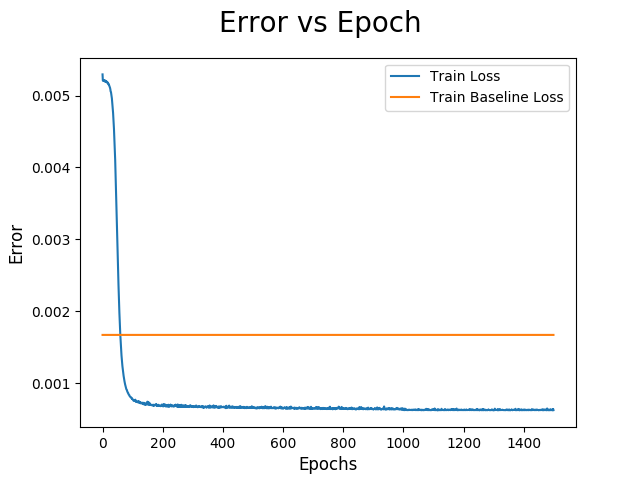

In [707]:
#plotting
fig2 = plt.figure()
plt.plot(epochs_arr_1c,train_arr_1c,label="Train Loss")
plt.plot(epochs_arr_1c,[train_baseline_loss for i in range(len(epochs_arr_1c))],label="Train Baseline Loss")
# plt.plot(epochs_arr,test_arr,label="Test Loss")
# plt.plot(epochs_arr,[test_baseline_loss for i in range(len(epochs_arr))],label="Test Baseline Loss")
plt.legend()
fig2.suptitle('Error vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
# plt.xticks(range(1,11))
plt.show()

### Learning rate Schedule
*Initial lr* = 0.1

After every *1000* steps, change lr by *lr = lr x 0.1*

### Performance
#### Training set 
**Binary Cross Entropy error**: 0.0006

**Classification Accuracy**: 98.81%

#### Test Set
**Binary Cross Entropy error**: 0.00075

**Classification Accuracy**: 98.3%

## Ques 1d

In [712]:
epochs_1d = 500
epochs_arr_1d = [i for i in range(epochs_1d)]
train_arr_1d, test_arr_1d, train_acc_1d, test_acc_1d =  ques_1a(epochs_1d, 'a')

train_acc_1d = np.array(train_acc_1d).flatten()
test_acc_1d = np.array(test_acc_1d).flatten()

Epoch # 0
==>> batch index: 1, train loss: 0.000089, accuracy: 21.233
==>> batch index: 1, test loss: 0.000074, accuracy: 21.011
Epoch # 1
==>> batch index: 1, train loss: 0.000089, accuracy: 21.233
==>> batch index: 1, test loss: 0.000074, accuracy: 21.011
Epoch # 2
==>> batch index: 1, train loss: 0.000088, accuracy: 21.233
==>> batch index: 1, test loss: 0.000073, accuracy: 21.011
Epoch # 3
==>> batch index: 1, train loss: 0.000088, accuracy: 21.233
==>> batch index: 1, test loss: 0.000072, accuracy: 21.011
Epoch # 4
==>> batch index: 1, train loss: 0.000087, accuracy: 21.233
==>> batch index: 1, test loss: 0.000071, accuracy: 21.011
Epoch # 5
==>> batch index: 1, train loss: 0.000086, accuracy: 21.233
==>> batch index: 1, test loss: 0.000071, accuracy: 78.989
Epoch # 6
==>> batch index: 1, train loss: 0.000084, accuracy: 78.767
==>> batch index: 1, test loss: 0.000069, accuracy: 78.989
Epoch # 7
==>> batch index: 1, train loss: 0.000083, accuracy: 78.767
==>> batch index: 1, test l

==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 65
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 66
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 67
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 68
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 69
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 70
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 71
==>> batch index: 1, train loss: 0.000064, accuracy: 78.767
==>> batch index: 1, test loss

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 128
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 129
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 130
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 131
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 132
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 133
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 134
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 191
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 192
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 193
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 194
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 195
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 196
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 197
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 254
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 255
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 256
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 257
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 258
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 259
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 260
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 317
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 318
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 319
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 320
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 321
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 322
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 323
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 324
==>> batch i

==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 380
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 381
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 382
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 383
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 384
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 385
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 386
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 443
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 444
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 445
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 446
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 447
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 448
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 449
==>> batch index: 1, train loss: 0.000063, accuracy: 78.767
==>> batch index: 1, test loss: 0.000053, accuracy: 78.989
Epoch # 450
==>> batch i

<IPython.core.display.Javascript object>


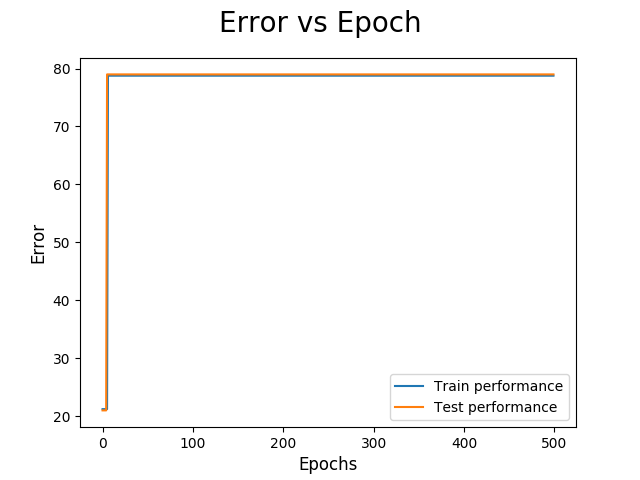

In [713]:
fig3 = plt.figure()
plt.plot(epochs_arr_1d,train_acc_1d,label="Train performance")
plt.plot(epochs_arr_1d,test_acc_1d,label="Test performance")
plt.legend()
fig3.suptitle('Error vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)
# plt.xticks(range(1,11))
plt.show()

## Ques 1e

In [710]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(5, 1)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(1, 1)
#         nn.init.xavier_normal(self.fc2.weight.data)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(5, 2)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(2, 1)
#         nn.init.xavier_normal(self.fc2.weight.data)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x
    
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(5, 10)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(10, 1)
#         nn.init.xavier_normal(self.fc2.weight.data)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x
    
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(5, 20)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(20, 1)
#         nn.init.xavier_normal(self.fc2.weight.data)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x

In [711]:
def ques_1e(epochs, s):
    train_arr = []
    test_arr = []
    train_acc = []
    test_acc = []
    
    train_loader_1c, test_loader_1c = get_loader(100, 100)
    model1 = Net2()
    model2 = Net3()
    model3 = Net1()
    model4 = Net4()
    model5 = Net5()
    
    nets = [Net2(), Net3(), Net1(), Net4(), Net5()]
    
    for net in nets:
        m = net
        if(use_cuda):
            m = m.cuda()
    
        optimizer = optim.Adam(m.parameters(), lr = 0.001)
        if(s == 'e'):
            criterion = F.binary_cross_entropy
        elif(s=='f'):
            criterion = nn.MSELoss()
            
        for epoch in range(epochs):
            print('Epoch # {}'.format(epoch))
#             scheduler.step()
            train_loss, train_c = train(m, 
                                              train_loader_1c, optimizer, criterion)
            test_loss, test_c = test(m, 
                                           test_loader_1c, optimizer, criterion)
        if(epoch == epochs-1):
            train_arr.append([train_loss])
            test_arr.append([test_loss])
            train_acc.append([(100.0*train_c)/len(train_loader.dataset)])
            test_acc.append([(100.0*test_c)/len(test_loader.dataset)])
    return train_arr, test_arr, train_acc, test_acc

In [731]:
epochs_1e = 500
epochs_arr_1e = [i for i in range(epochs_1e)]
train_arr_1e, test_arr_1e, train_acc_1e, test_acc_1e =  ques_1e(epochs_1e, 'e')

H = [1,2,5,10,20]
train_acc_1e = np.array(train_acc_1e).flatten()
test_acc_1e = np.array(test_acc_1e).flatten()

Epoch # 0
==>> batch index: 82, train loss: 1.092463, accuracy: 78.767
==>> batch index: 98, test loss: 1.061470, accuracy: 78.989
Epoch # 1
==>> batch index: 82, train loss: 1.063881, accuracy: 78.767
==>> batch index: 98, test loss: 1.035348, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 1.041314, accuracy: 78.767
==>> batch index: 98, test loss: 1.014834, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 1.021166, accuracy: 78.767
==>> batch index: 98, test loss: 0.999926, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 1.009067, accuracy: 78.767
==>> batch index: 98, test loss: 0.987637, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 0.999674, accuracy: 78.767
==>> batch index: 98, test loss: 0.981216, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 0.994356, accuracy: 78.767
==>> batch index: 98, test loss: 0.974436, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 0.990903, accuracy: 78.767
==>> batch i

==>> batch index: 98, test loss: 0.957122, accuracy: 78.989
Epoch # 64
==>> batch index: 82, train loss: 0.968716, accuracy: 78.767
==>> batch index: 98, test loss: 0.956464, accuracy: 78.989
Epoch # 65
==>> batch index: 82, train loss: 0.968533, accuracy: 78.767
==>> batch index: 98, test loss: 0.955579, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.970346, accuracy: 78.767
==>> batch index: 98, test loss: 0.956792, accuracy: 78.989
Epoch # 67
==>> batch index: 82, train loss: 0.968149, accuracy: 78.767
==>> batch index: 98, test loss: 0.954715, accuracy: 78.989
Epoch # 68
==>> batch index: 82, train loss: 0.970318, accuracy: 78.767
==>> batch index: 98, test loss: 0.954976, accuracy: 78.989
Epoch # 69
==>> batch index: 82, train loss: 0.966502, accuracy: 78.767
==>> batch index: 98, test loss: 0.954983, accuracy: 78.989
Epoch # 70
==>> batch index: 82, train loss: 0.963815, accuracy: 78.767
==>> batch index: 98, test loss: 0.954731, accuracy: 78.989
Epoch # 71
==>> 

==>> batch index: 82, train loss: 0.897145, accuracy: 78.767
==>> batch index: 98, test loss: 0.903558, accuracy: 78.989
Epoch # 128
==>> batch index: 82, train loss: 0.895704, accuracy: 78.767
==>> batch index: 98, test loss: 0.903139, accuracy: 78.989
Epoch # 129
==>> batch index: 82, train loss: 0.894330, accuracy: 78.767
==>> batch index: 98, test loss: 0.902066, accuracy: 78.989
Epoch # 130
==>> batch index: 82, train loss: 0.892054, accuracy: 78.767
==>> batch index: 98, test loss: 0.900662, accuracy: 78.989
Epoch # 131
==>> batch index: 82, train loss: 0.893208, accuracy: 78.767
==>> batch index: 98, test loss: 0.901336, accuracy: 78.989
Epoch # 132
==>> batch index: 82, train loss: 0.887956, accuracy: 78.767
==>> batch index: 98, test loss: 0.897278, accuracy: 78.989
Epoch # 133
==>> batch index: 82, train loss: 0.888065, accuracy: 78.767
==>> batch index: 98, test loss: 0.895440, accuracy: 78.989
Epoch # 134
==>> batch index: 82, train loss: 0.882440, accuracy: 78.767
==>> bat

==>> batch index: 82, train loss: 0.749449, accuracy: 78.742
==>> batch index: 98, test loss: 0.794702, accuracy: 78.999
Epoch # 191
==>> batch index: 82, train loss: 0.747370, accuracy: 78.742
==>> batch index: 98, test loss: 0.791050, accuracy: 78.999
Epoch # 192
==>> batch index: 82, train loss: 0.744341, accuracy: 78.742
==>> batch index: 98, test loss: 0.788965, accuracy: 78.999
Epoch # 193
==>> batch index: 82, train loss: 0.741997, accuracy: 78.742
==>> batch index: 98, test loss: 0.787115, accuracy: 79.009
Epoch # 194
==>> batch index: 82, train loss: 0.738991, accuracy: 78.742
==>> batch index: 98, test loss: 0.785628, accuracy: 79.009
Epoch # 195
==>> batch index: 82, train loss: 0.736037, accuracy: 78.742
==>> batch index: 98, test loss: 0.784061, accuracy: 79.009
Epoch # 196
==>> batch index: 82, train loss: 0.733603, accuracy: 78.742
==>> batch index: 98, test loss: 0.781236, accuracy: 79.009
Epoch # 197
==>> batch index: 82, train loss: 0.730607, accuracy: 78.742
==>> bat

==>> batch index: 82, train loss: 0.562469, accuracy: 83.814
==>> batch index: 98, test loss: 0.645186, accuracy: 79.050
Epoch # 253
==>> batch index: 82, train loss: 0.558697, accuracy: 83.802
==>> batch index: 98, test loss: 0.643342, accuracy: 79.050
Epoch # 254
==>> batch index: 82, train loss: 0.556228, accuracy: 83.937
==>> batch index: 98, test loss: 0.640999, accuracy: 79.050
Epoch # 255
==>> batch index: 82, train loss: 0.552966, accuracy: 83.913
==>> batch index: 98, test loss: 0.637340, accuracy: 79.050
Epoch # 256
==>> batch index: 82, train loss: 0.550685, accuracy: 84.023
==>> batch index: 98, test loss: 0.633702, accuracy: 79.050
Epoch # 257
==>> batch index: 82, train loss: 0.546301, accuracy: 84.170
==>> batch index: 98, test loss: 0.634129, accuracy: 79.050
Epoch # 258
==>> batch index: 82, train loss: 0.544063, accuracy: 84.084
==>> batch index: 98, test loss: 0.629479, accuracy: 79.050
Epoch # 259
==>> batch index: 82, train loss: 0.539537, accuracy: 84.318
==>> bat

==>> batch index: 98, test loss: 0.493791, accuracy: 84.526
Epoch # 315
==>> batch index: 82, train loss: 0.387215, accuracy: 94.584
==>> batch index: 98, test loss: 0.492185, accuracy: 84.516
Epoch # 316
==>> batch index: 82, train loss: 0.384590, accuracy: 94.560
==>> batch index: 98, test loss: 0.490603, accuracy: 84.537
Epoch # 317
==>> batch index: 82, train loss: 0.382907, accuracy: 94.805
==>> batch index: 98, test loss: 0.488237, accuracy: 84.629
Epoch # 318
==>> batch index: 82, train loss: 0.380145, accuracy: 94.891
==>> batch index: 98, test loss: 0.485552, accuracy: 84.762
Epoch # 319
==>> batch index: 82, train loss: 0.378667, accuracy: 95.039
==>> batch index: 98, test loss: 0.483837, accuracy: 84.701
Epoch # 320
==>> batch index: 82, train loss: 0.375290, accuracy: 94.977
==>> batch index: 98, test loss: 0.480453, accuracy: 85.018
Epoch # 321
==>> batch index: 82, train loss: 0.372470, accuracy: 95.137
==>> batch index: 98, test loss: 0.478808, accuracy: 84.967
Epoch # 3

==>> batch index: 98, test loss: 0.370243, accuracy: 88.710
Epoch # 378
==>> batch index: 82, train loss: 0.264739, accuracy: 97.237
==>> batch index: 98, test loss: 0.369499, accuracy: 88.454
Epoch # 379
==>> batch index: 82, train loss: 0.263041, accuracy: 97.151
==>> batch index: 98, test loss: 0.366402, accuracy: 89.059
Epoch # 380
==>> batch index: 82, train loss: 0.260961, accuracy: 97.397
==>> batch index: 98, test loss: 0.366227, accuracy: 88.792
Epoch # 381
==>> batch index: 82, train loss: 0.259769, accuracy: 97.225
==>> batch index: 98, test loss: 0.363524, accuracy: 89.141
Epoch # 382
==>> batch index: 82, train loss: 0.259651, accuracy: 97.409
==>> batch index: 98, test loss: 0.363641, accuracy: 88.792
Epoch # 383
==>> batch index: 82, train loss: 0.257467, accuracy: 97.335
==>> batch index: 98, test loss: 0.360971, accuracy: 89.151
Epoch # 384
==>> batch index: 82, train loss: 0.255807, accuracy: 97.384
==>> batch index: 98, test loss: 0.358362, accuracy: 89.930
Epoch # 3

==>> batch index: 98, test loss: 0.286190, accuracy: 94.196
Epoch # 440
==>> batch index: 82, train loss: 0.194121, accuracy: 98.195
==>> batch index: 98, test loss: 0.284941, accuracy: 94.196
Epoch # 441
==>> batch index: 82, train loss: 0.193931, accuracy: 98.268
==>> batch index: 98, test loss: 0.286378, accuracy: 94.145
Epoch # 442
==>> batch index: 82, train loss: 0.192306, accuracy: 98.219
==>> batch index: 98, test loss: 0.283047, accuracy: 94.227
Epoch # 443
==>> batch index: 82, train loss: 0.191587, accuracy: 98.207
==>> batch index: 98, test loss: 0.281370, accuracy: 94.247
Epoch # 444
==>> batch index: 82, train loss: 0.191526, accuracy: 98.281
==>> batch index: 98, test loss: 0.282775, accuracy: 94.186
Epoch # 445
==>> batch index: 82, train loss: 0.191032, accuracy: 98.256
==>> batch index: 98, test loss: 0.280247, accuracy: 94.247
Epoch # 446
==>> batch index: 82, train loss: 0.189314, accuracy: 98.268
==>> batch index: 98, test loss: 0.281726, accuracy: 94.165
Epoch # 4

==>> batch index: 82, train loss: 1.287250, accuracy: 73.806
==>> batch index: 98, test loss: 1.231992, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 1.214147, accuracy: 78.767
==>> batch index: 98, test loss: 1.167262, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 1.155963, accuracy: 78.767
==>> batch index: 98, test loss: 1.115543, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 1.110800, accuracy: 78.767
==>> batch index: 98, test loss: 1.075268, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 1.075629, accuracy: 78.767
==>> batch index: 98, test loss: 1.045790, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 1.048901, accuracy: 78.767
==>> batch index: 98, test loss: 1.022817, accuracy: 78.989
Epoch # 8
==>> batch index: 82, train loss: 1.029019, accuracy: 78.767
==>> batch index: 98, test loss: 1.005987, accuracy: 78.989
Epoch # 9
==>> batch index: 82, train loss: 1.014574, accuracy: 78.767
==>> batch index: 98, 

==>> batch index: 98, test loss: 0.946126, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.954921, accuracy: 78.767
==>> batch index: 98, test loss: 0.946098, accuracy: 78.989
Epoch # 67
==>> batch index: 82, train loss: 0.951957, accuracy: 78.767
==>> batch index: 98, test loss: 0.943493, accuracy: 78.989
Epoch # 68
==>> batch index: 82, train loss: 0.953246, accuracy: 78.767
==>> batch index: 98, test loss: 0.944581, accuracy: 78.989
Epoch # 69
==>> batch index: 82, train loss: 0.953010, accuracy: 78.767
==>> batch index: 98, test loss: 0.943316, accuracy: 78.989
Epoch # 70
==>> batch index: 82, train loss: 0.950714, accuracy: 78.767
==>> batch index: 98, test loss: 0.941593, accuracy: 78.989
Epoch # 71
==>> batch index: 82, train loss: 0.949267, accuracy: 78.767
==>> batch index: 98, test loss: 0.941231, accuracy: 78.989
Epoch # 72
==>> batch index: 82, train loss: 0.946543, accuracy: 78.767
==>> batch index: 98, test loss: 0.941317, accuracy: 78.989
Epoch # 73
==>> 

==>> batch index: 82, train loss: 0.842400, accuracy: 78.767
==>> batch index: 98, test loss: 0.861630, accuracy: 78.989
Epoch # 129
==>> batch index: 82, train loss: 0.838650, accuracy: 78.767
==>> batch index: 98, test loss: 0.858876, accuracy: 78.989
Epoch # 130
==>> batch index: 82, train loss: 0.836381, accuracy: 78.767
==>> batch index: 98, test loss: 0.855506, accuracy: 78.989
Epoch # 131
==>> batch index: 82, train loss: 0.832298, accuracy: 78.767
==>> batch index: 98, test loss: 0.854934, accuracy: 78.989
Epoch # 132
==>> batch index: 82, train loss: 0.830212, accuracy: 78.767
==>> batch index: 98, test loss: 0.852946, accuracy: 78.989
Epoch # 133
==>> batch index: 82, train loss: 0.827073, accuracy: 78.767
==>> batch index: 98, test loss: 0.851104, accuracy: 78.989
Epoch # 134
==>> batch index: 82, train loss: 0.824119, accuracy: 78.767
==>> batch index: 98, test loss: 0.847840, accuracy: 78.989
Epoch # 135
==>> batch index: 82, train loss: 0.823491, accuracy: 78.767
==>> bat

==>> batch index: 98, test loss: 0.698008, accuracy: 79.020
Epoch # 191
==>> batch index: 82, train loss: 0.626762, accuracy: 80.928
==>> batch index: 98, test loss: 0.695841, accuracy: 79.020
Epoch # 192
==>> batch index: 82, train loss: 0.623480, accuracy: 80.990
==>> batch index: 98, test loss: 0.692819, accuracy: 79.020
Epoch # 193
==>> batch index: 82, train loss: 0.621027, accuracy: 80.953
==>> batch index: 98, test loss: 0.689257, accuracy: 79.020
Epoch # 194
==>> batch index: 82, train loss: 0.615999, accuracy: 81.088
==>> batch index: 98, test loss: 0.686352, accuracy: 79.020
Epoch # 195
==>> batch index: 82, train loss: 0.613073, accuracy: 81.211
==>> batch index: 98, test loss: 0.683144, accuracy: 79.030
Epoch # 196
==>> batch index: 82, train loss: 0.609323, accuracy: 81.260
==>> batch index: 98, test loss: 0.679616, accuracy: 79.030
Epoch # 197
==>> batch index: 82, train loss: 0.604886, accuracy: 81.248
==>> batch index: 98, test loss: 0.676323, accuracy: 79.040
Epoch # 1

==>> batch index: 82, train loss: 0.405632, accuracy: 93.098
==>> batch index: 98, test loss: 0.506344, accuracy: 84.178
Epoch # 254
==>> batch index: 82, train loss: 0.402902, accuracy: 93.172
==>> batch index: 98, test loss: 0.503248, accuracy: 84.188
Epoch # 255
==>> batch index: 82, train loss: 0.400311, accuracy: 93.344
==>> batch index: 98, test loss: 0.500993, accuracy: 84.219
Epoch # 256
==>> batch index: 82, train loss: 0.396017, accuracy: 93.516
==>> batch index: 98, test loss: 0.497975, accuracy: 84.208
Epoch # 257
==>> batch index: 82, train loss: 0.393505, accuracy: 94.130
==>> batch index: 98, test loss: 0.495638, accuracy: 84.198
Epoch # 258
==>> batch index: 82, train loss: 0.390259, accuracy: 93.651
==>> batch index: 98, test loss: 0.492098, accuracy: 84.331
Epoch # 259
==>> batch index: 82, train loss: 0.388020, accuracy: 94.142
==>> batch index: 98, test loss: 0.489509, accuracy: 84.383
Epoch # 260
==>> batch index: 82, train loss: 0.384133, accuracy: 94.376
==>> bat

==>> batch index: 98, test loss: 0.353570, accuracy: 90.176
Epoch # 316
==>> batch index: 82, train loss: 0.252406, accuracy: 97.519
==>> batch index: 98, test loss: 0.353691, accuracy: 89.438
Epoch # 317
==>> batch index: 82, train loss: 0.250430, accuracy: 97.544
==>> batch index: 98, test loss: 0.350955, accuracy: 89.848
Epoch # 318
==>> batch index: 82, train loss: 0.249355, accuracy: 97.483
==>> batch index: 98, test loss: 0.348066, accuracy: 90.658
Epoch # 319
==>> batch index: 82, train loss: 0.247629, accuracy: 97.593
==>> batch index: 98, test loss: 0.347519, accuracy: 90.535
Epoch # 320
==>> batch index: 82, train loss: 0.246493, accuracy: 97.740
==>> batch index: 98, test loss: 0.346403, accuracy: 90.064
Epoch # 321
==>> batch index: 82, train loss: 0.244238, accuracy: 97.654
==>> batch index: 98, test loss: 0.345374, accuracy: 90.176
Epoch # 322
==>> batch index: 82, train loss: 0.242447, accuracy: 97.667
==>> batch index: 98, test loss: 0.342599, accuracy: 90.751
Epoch # 3

==>> batch index: 98, test loss: 0.262126, accuracy: 94.709
Epoch # 378
==>> batch index: 82, train loss: 0.177451, accuracy: 98.453
==>> batch index: 98, test loss: 0.262860, accuracy: 94.524
Epoch # 379
==>> batch index: 82, train loss: 0.177023, accuracy: 98.416
==>> batch index: 98, test loss: 0.260835, accuracy: 94.637
Epoch # 380
==>> batch index: 82, train loss: 0.176767, accuracy: 98.440
==>> batch index: 98, test loss: 0.261846, accuracy: 94.524
Epoch # 381
==>> batch index: 82, train loss: 0.176523, accuracy: 98.428
==>> batch index: 98, test loss: 0.260449, accuracy: 94.596
Epoch # 382
==>> batch index: 82, train loss: 0.174698, accuracy: 98.440
==>> batch index: 98, test loss: 0.260915, accuracy: 94.452
Epoch # 383
==>> batch index: 82, train loss: 0.173655, accuracy: 98.404
==>> batch index: 98, test loss: 0.257201, accuracy: 94.699
Epoch # 384
==>> batch index: 82, train loss: 0.174400, accuracy: 98.465
==>> batch index: 98, test loss: 0.255232, accuracy: 94.781
Epoch # 3

==>> batch index: 98, test loss: 0.214218, accuracy: 95.960
Epoch # 441
==>> batch index: 82, train loss: 0.145286, accuracy: 98.784
==>> batch index: 98, test loss: 0.213450, accuracy: 95.939
Epoch # 442
==>> batch index: 82, train loss: 0.145342, accuracy: 98.809
==>> batch index: 98, test loss: 0.216217, accuracy: 95.837
Epoch # 443
==>> batch index: 82, train loss: 0.146346, accuracy: 98.797
==>> batch index: 98, test loss: 0.215638, accuracy: 95.847
Epoch # 444
==>> batch index: 82, train loss: 0.144330, accuracy: 98.797
==>> batch index: 98, test loss: 0.215501, accuracy: 95.816
Epoch # 445
==>> batch index: 82, train loss: 0.144437, accuracy: 98.797
==>> batch index: 98, test loss: 0.211887, accuracy: 95.960
Epoch # 446
==>> batch index: 82, train loss: 0.144200, accuracy: 98.797
==>> batch index: 98, test loss: 0.212808, accuracy: 95.929
Epoch # 447
==>> batch index: 82, train loss: 0.144073, accuracy: 98.797
==>> batch index: 98, test loss: 0.210584, accuracy: 95.980
Epoch # 4

==>> batch index: 98, test loss: 0.986762, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 0.995203, accuracy: 78.767
==>> batch index: 98, test loss: 0.973736, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 0.989200, accuracy: 78.767
==>> batch index: 98, test loss: 0.969685, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 0.985165, accuracy: 78.767
==>> batch index: 98, test loss: 0.967409, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 0.984344, accuracy: 78.767
==>> batch index: 98, test loss: 0.966695, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 0.982931, accuracy: 78.767
==>> batch index: 98, test loss: 0.965109, accuracy: 78.989
Epoch # 8
==>> batch index: 82, train loss: 0.982429, accuracy: 78.767
==>> batch index: 98, test loss: 0.965691, accuracy: 78.989
Epoch # 9
==>> batch index: 82, train loss: 0.982038, accuracy: 78.767
==>> batch index: 98, test loss: 0.966515, accuracy: 78.989
Epoch # 10
==>> batch i

==>> batch index: 98, test loss: 0.930010, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.930822, accuracy: 78.767
==>> batch index: 98, test loss: 0.927429, accuracy: 78.989
Epoch # 67
==>> batch index: 82, train loss: 0.930210, accuracy: 78.767
==>> batch index: 98, test loss: 0.926034, accuracy: 78.989
Epoch # 68
==>> batch index: 82, train loss: 0.926390, accuracy: 78.767
==>> batch index: 98, test loss: 0.925612, accuracy: 78.989
Epoch # 69
==>> batch index: 82, train loss: 0.925441, accuracy: 78.767
==>> batch index: 98, test loss: 0.925679, accuracy: 78.989
Epoch # 70
==>> batch index: 82, train loss: 0.923523, accuracy: 78.767
==>> batch index: 98, test loss: 0.923355, accuracy: 78.989
Epoch # 71
==>> batch index: 82, train loss: 0.921103, accuracy: 78.767
==>> batch index: 98, test loss: 0.921683, accuracy: 78.989
Epoch # 72
==>> batch index: 82, train loss: 0.919532, accuracy: 78.767
==>> batch index: 98, test loss: 0.920065, accuracy: 78.989
Epoch # 73
==>> 

==>> batch index: 98, test loss: 0.790275, accuracy: 78.999
Epoch # 128
==>> batch index: 82, train loss: 0.741482, accuracy: 78.742
==>> batch index: 98, test loss: 0.787464, accuracy: 78.999
Epoch # 129
==>> batch index: 82, train loss: 0.740222, accuracy: 78.742
==>> batch index: 98, test loss: 0.782927, accuracy: 78.999
Epoch # 130
==>> batch index: 82, train loss: 0.734016, accuracy: 78.742
==>> batch index: 98, test loss: 0.780497, accuracy: 79.009
Epoch # 131
==>> batch index: 82, train loss: 0.730779, accuracy: 78.742
==>> batch index: 98, test loss: 0.777640, accuracy: 79.009
Epoch # 132
==>> batch index: 82, train loss: 0.726184, accuracy: 78.742
==>> batch index: 98, test loss: 0.774271, accuracy: 79.009
Epoch # 133
==>> batch index: 82, train loss: 0.722741, accuracy: 78.742
==>> batch index: 98, test loss: 0.771294, accuracy: 79.009
Epoch # 134
==>> batch index: 82, train loss: 0.716841, accuracy: 78.742
==>> batch index: 98, test loss: 0.767592, accuracy: 79.009
Epoch # 1

==>> batch index: 98, test loss: 0.566606, accuracy: 80.630
Epoch # 190
==>> batch index: 82, train loss: 0.467414, accuracy: 87.621
==>> batch index: 98, test loss: 0.563444, accuracy: 80.845
Epoch # 191
==>> batch index: 82, train loss: 0.462485, accuracy: 88.665
==>> batch index: 98, test loss: 0.562367, accuracy: 80.732
Epoch # 192
==>> batch index: 82, train loss: 0.459525, accuracy: 88.456
==>> batch index: 98, test loss: 0.555250, accuracy: 81.060
Epoch # 193
==>> batch index: 82, train loss: 0.456350, accuracy: 88.825
==>> batch index: 98, test loss: 0.553141, accuracy: 81.101
Epoch # 194
==>> batch index: 82, train loss: 0.451654, accuracy: 89.181
==>> batch index: 98, test loss: 0.548886, accuracy: 81.573
Epoch # 195
==>> batch index: 82, train loss: 0.448103, accuracy: 89.181
==>> batch index: 98, test loss: 0.545091, accuracy: 82.055
Epoch # 196
==>> batch index: 82, train loss: 0.443463, accuracy: 89.709
==>> batch index: 98, test loss: 0.543077, accuracy: 81.840
Epoch # 1

==>> batch index: 98, test loss: 0.372934, accuracy: 87.797
Epoch # 252
==>> batch index: 82, train loss: 0.267730, accuracy: 97.053
==>> batch index: 98, test loss: 0.369690, accuracy: 88.208
Epoch # 253
==>> batch index: 82, train loss: 0.265084, accuracy: 97.077
==>> batch index: 98, test loss: 0.371210, accuracy: 87.582
Epoch # 254
==>> batch index: 82, train loss: 0.262547, accuracy: 97.077
==>> batch index: 98, test loss: 0.366451, accuracy: 88.074
Epoch # 255
==>> batch index: 82, train loss: 0.261095, accuracy: 97.139
==>> batch index: 98, test loss: 0.363463, accuracy: 88.126
Epoch # 256
==>> batch index: 82, train loss: 0.258890, accuracy: 97.126
==>> batch index: 98, test loss: 0.362782, accuracy: 88.095
Epoch # 257
==>> batch index: 82, train loss: 0.257217, accuracy: 97.163
==>> batch index: 98, test loss: 0.362789, accuracy: 87.828
Epoch # 258
==>> batch index: 82, train loss: 0.254768, accuracy: 97.188
==>> batch index: 98, test loss: 0.357527, accuracy: 88.341
Epoch # 2

==>> batch index: 98, test loss: 0.260664, accuracy: 94.473
Epoch # 315
==>> batch index: 82, train loss: 0.174639, accuracy: 98.440
==>> batch index: 98, test loss: 0.259732, accuracy: 94.545
Epoch # 316
==>> batch index: 82, train loss: 0.173907, accuracy: 98.354
==>> batch index: 98, test loss: 0.258096, accuracy: 94.606
Epoch # 317
==>> batch index: 82, train loss: 0.172630, accuracy: 98.367
==>> batch index: 98, test loss: 0.254032, accuracy: 94.986
Epoch # 318
==>> batch index: 82, train loss: 0.172334, accuracy: 98.416
==>> batch index: 98, test loss: 0.254350, accuracy: 94.781
Epoch # 319
==>> batch index: 82, train loss: 0.171403, accuracy: 98.416
==>> batch index: 98, test loss: 0.254754, accuracy: 94.688
Epoch # 320
==>> batch index: 82, train loss: 0.172247, accuracy: 98.428
==>> batch index: 98, test loss: 0.254162, accuracy: 94.627
Epoch # 321
==>> batch index: 82, train loss: 0.169914, accuracy: 98.453
==>> batch index: 98, test loss: 0.251329, accuracy: 94.934
Epoch # 3

==>> batch index: 98, test loss: 0.208824, accuracy: 95.950
Epoch # 377
==>> batch index: 82, train loss: 0.142220, accuracy: 98.809
==>> batch index: 98, test loss: 0.212338, accuracy: 95.816
Epoch # 378
==>> batch index: 82, train loss: 0.140917, accuracy: 98.760
==>> batch index: 98, test loss: 0.207434, accuracy: 95.950
Epoch # 379
==>> batch index: 82, train loss: 0.140589, accuracy: 98.772
==>> batch index: 98, test loss: 0.206489, accuracy: 95.960
Epoch # 380
==>> batch index: 82, train loss: 0.140674, accuracy: 98.797
==>> batch index: 98, test loss: 0.205491, accuracy: 96.001
Epoch # 381
==>> batch index: 82, train loss: 0.139861, accuracy: 98.797
==>> batch index: 98, test loss: 0.209451, accuracy: 95.888
Epoch # 382
==>> batch index: 82, train loss: 0.139670, accuracy: 98.772
==>> batch index: 98, test loss: 0.208237, accuracy: 95.939
Epoch # 383
==>> batch index: 82, train loss: 0.140105, accuracy: 98.784
==>> batch index: 98, test loss: 0.203422, accuracy: 96.011
Epoch # 3

==>> batch index: 98, test loss: 0.184727, accuracy: 96.196
Epoch # 440
==>> batch index: 82, train loss: 0.129244, accuracy: 98.784
==>> batch index: 98, test loss: 0.186873, accuracy: 96.093
Epoch # 441
==>> batch index: 82, train loss: 0.128708, accuracy: 98.784
==>> batch index: 98, test loss: 0.187981, accuracy: 96.073
Epoch # 442
==>> batch index: 82, train loss: 0.128281, accuracy: 98.809
==>> batch index: 98, test loss: 0.187757, accuracy: 96.083
Epoch # 443
==>> batch index: 82, train loss: 0.129015, accuracy: 98.784
==>> batch index: 98, test loss: 0.187440, accuracy: 96.073
Epoch # 444
==>> batch index: 82, train loss: 0.128632, accuracy: 98.797
==>> batch index: 98, test loss: 0.181193, accuracy: 96.534
Epoch # 445
==>> batch index: 82, train loss: 0.127913, accuracy: 98.760
==>> batch index: 98, test loss: 0.181442, accuracy: 96.452
Epoch # 446
==>> batch index: 82, train loss: 0.128844, accuracy: 98.809
==>> batch index: 98, test loss: 0.188607, accuracy: 96.052
Epoch # 4

==>> batch index: 82, train loss: 1.087222, accuracy: 78.767
==>> batch index: 98, test loss: 1.032094, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 1.026387, accuracy: 78.767
==>> batch index: 98, test loss: 0.993179, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 0.999517, accuracy: 78.767
==>> batch index: 98, test loss: 0.977125, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 0.987757, accuracy: 78.767
==>> batch index: 98, test loss: 0.970951, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 0.988073, accuracy: 78.767
==>> batch index: 98, test loss: 0.967512, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 0.983657, accuracy: 78.767
==>> batch index: 98, test loss: 0.967268, accuracy: 78.989
Epoch # 8
==>> batch index: 82, train loss: 0.982593, accuracy: 78.767
==>> batch index: 98, test loss: 0.967203, accuracy: 78.989
Epoch # 9
==>> batch index: 82, train loss: 0.983757, accuracy: 78.767
==>> batch index: 98, 

==>> batch index: 98, test loss: 0.889136, accuracy: 78.989
Epoch # 65
==>> batch index: 82, train loss: 0.876103, accuracy: 78.767
==>> batch index: 98, test loss: 0.885193, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.870348, accuracy: 78.767
==>> batch index: 98, test loss: 0.881651, accuracy: 78.989
Epoch # 67
==>> batch index: 82, train loss: 0.864843, accuracy: 78.767
==>> batch index: 98, test loss: 0.877351, accuracy: 78.989
Epoch # 68
==>> batch index: 82, train loss: 0.858520, accuracy: 78.767
==>> batch index: 98, test loss: 0.872949, accuracy: 78.989
Epoch # 69
==>> batch index: 82, train loss: 0.853008, accuracy: 78.767
==>> batch index: 98, test loss: 0.867346, accuracy: 78.989
Epoch # 70
==>> batch index: 82, train loss: 0.848515, accuracy: 78.767
==>> batch index: 98, test loss: 0.865472, accuracy: 78.989
Epoch # 71
==>> batch index: 82, train loss: 0.840202, accuracy: 78.767
==>> batch index: 98, test loss: 0.860337, accuracy: 78.989
Epoch # 72
==>> 

==>> batch index: 98, test loss: 0.537723, accuracy: 83.429
Epoch # 127
==>> batch index: 82, train loss: 0.434481, accuracy: 90.962
==>> batch index: 98, test loss: 0.530722, accuracy: 84.085
Epoch # 128
==>> batch index: 82, train loss: 0.427940, accuracy: 92.214
==>> batch index: 98, test loss: 0.524823, accuracy: 84.178
Epoch # 129
==>> batch index: 82, train loss: 0.421318, accuracy: 92.497
==>> batch index: 98, test loss: 0.517721, accuracy: 84.301
Epoch # 130
==>> batch index: 82, train loss: 0.415697, accuracy: 93.233
==>> batch index: 98, test loss: 0.514140, accuracy: 84.219
Epoch # 131
==>> batch index: 82, train loss: 0.408366, accuracy: 93.663
==>> batch index: 98, test loss: 0.509579, accuracy: 84.311
Epoch # 132
==>> batch index: 82, train loss: 0.402761, accuracy: 93.909
==>> batch index: 98, test loss: 0.505469, accuracy: 84.249
Epoch # 133
==>> batch index: 82, train loss: 0.396755, accuracy: 94.240
==>> batch index: 98, test loss: 0.497343, accuracy: 84.537
Epoch # 1

==>> batch index: 98, test loss: 0.289017, accuracy: 94.176
Epoch # 189
==>> batch index: 82, train loss: 0.197216, accuracy: 98.256
==>> batch index: 98, test loss: 0.292529, accuracy: 93.837
Epoch # 190
==>> batch index: 82, train loss: 0.195508, accuracy: 98.170
==>> batch index: 98, test loss: 0.283834, accuracy: 94.268
Epoch # 191
==>> batch index: 82, train loss: 0.193234, accuracy: 98.318
==>> batch index: 98, test loss: 0.284947, accuracy: 94.165
Epoch # 192
==>> batch index: 82, train loss: 0.192553, accuracy: 98.268
==>> batch index: 98, test loss: 0.281831, accuracy: 94.217
Epoch # 193
==>> batch index: 82, train loss: 0.190279, accuracy: 98.330
==>> batch index: 98, test loss: 0.281393, accuracy: 94.155
Epoch # 194
==>> batch index: 82, train loss: 0.189003, accuracy: 98.367
==>> batch index: 98, test loss: 0.280027, accuracy: 94.186
Epoch # 195
==>> batch index: 82, train loss: 0.187783, accuracy: 98.293
==>> batch index: 98, test loss: 0.270861, accuracy: 94.627
Epoch # 1

==>> batch index: 98, test loss: 0.207889, accuracy: 95.888
Epoch # 252
==>> batch index: 82, train loss: 0.141644, accuracy: 98.784
==>> batch index: 98, test loss: 0.213858, accuracy: 95.642
Epoch # 253
==>> batch index: 82, train loss: 0.142511, accuracy: 98.760
==>> batch index: 98, test loss: 0.214056, accuracy: 95.601
Epoch # 254
==>> batch index: 82, train loss: 0.141419, accuracy: 98.674
==>> batch index: 98, test loss: 0.204703, accuracy: 95.970
Epoch # 255
==>> batch index: 82, train loss: 0.140746, accuracy: 98.821
==>> batch index: 98, test loss: 0.205059, accuracy: 95.960
Epoch # 256
==>> batch index: 82, train loss: 0.141261, accuracy: 98.821
==>> batch index: 98, test loss: 0.203538, accuracy: 95.980
Epoch # 257
==>> batch index: 82, train loss: 0.141094, accuracy: 98.821
==>> batch index: 98, test loss: 0.204749, accuracy: 95.939
Epoch # 258
==>> batch index: 82, train loss: 0.139766, accuracy: 98.797
==>> batch index: 98, test loss: 0.206625, accuracy: 95.816
Epoch # 2

==>> batch index: 98, test loss: 0.183952, accuracy: 96.062
Epoch # 314
==>> batch index: 82, train loss: 0.129506, accuracy: 98.809
==>> batch index: 98, test loss: 0.192918, accuracy: 95.847
Epoch # 315
==>> batch index: 82, train loss: 0.128999, accuracy: 98.784
==>> batch index: 98, test loss: 0.174838, accuracy: 96.760
Epoch # 316
==>> batch index: 82, train loss: 0.129579, accuracy: 98.784
==>> batch index: 98, test loss: 0.189261, accuracy: 95.991
Epoch # 317
==>> batch index: 82, train loss: 0.131563, accuracy: 98.784
==>> batch index: 98, test loss: 0.181409, accuracy: 96.103
Epoch # 318
==>> batch index: 82, train loss: 0.129698, accuracy: 98.760
==>> batch index: 98, test loss: 0.184030, accuracy: 96.052
Epoch # 319
==>> batch index: 82, train loss: 0.129331, accuracy: 98.760
==>> batch index: 98, test loss: 0.185759, accuracy: 96.042
Epoch # 320
==>> batch index: 82, train loss: 0.129111, accuracy: 98.784
==>> batch index: 98, test loss: 0.186551, accuracy: 96.032
Epoch # 3

==>> batch index: 82, train loss: 0.126186, accuracy: 98.809
==>> batch index: 98, test loss: 0.183202, accuracy: 95.970
Epoch # 377
==>> batch index: 82, train loss: 0.127453, accuracy: 98.760
==>> batch index: 98, test loss: 0.180221, accuracy: 96.052
Epoch # 378
==>> batch index: 82, train loss: 0.125569, accuracy: 98.821
==>> batch index: 98, test loss: 0.182078, accuracy: 96.042
Epoch # 379
==>> batch index: 82, train loss: 0.125696, accuracy: 98.772
==>> batch index: 98, test loss: 0.175027, accuracy: 96.093
Epoch # 380
==>> batch index: 82, train loss: 0.125544, accuracy: 98.797
==>> batch index: 98, test loss: 0.174310, accuracy: 96.165
Epoch # 381
==>> batch index: 82, train loss: 0.125720, accuracy: 98.797
==>> batch index: 98, test loss: 0.187158, accuracy: 95.816
Epoch # 382
==>> batch index: 82, train loss: 0.125540, accuracy: 98.760
==>> batch index: 98, test loss: 0.175543, accuracy: 96.093
Epoch # 383
==>> batch index: 82, train loss: 0.125872, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.124658, accuracy: 98.809
==>> batch index: 98, test loss: 0.177593, accuracy: 96.052
Epoch # 439
==>> batch index: 82, train loss: 0.124151, accuracy: 98.772
==>> batch index: 98, test loss: 0.177706, accuracy: 96.042
Epoch # 440
==>> batch index: 82, train loss: 0.124711, accuracy: 98.797
==>> batch index: 98, test loss: 0.180198, accuracy: 95.950
Epoch # 441
==>> batch index: 82, train loss: 0.124069, accuracy: 98.797
==>> batch index: 98, test loss: 0.184332, accuracy: 95.796
Epoch # 442
==>> batch index: 82, train loss: 0.125843, accuracy: 98.821
==>> batch index: 98, test loss: 0.183370, accuracy: 95.837
Epoch # 443
==>> batch index: 82, train loss: 0.124327, accuracy: 98.784
==>> batch index: 98, test loss: 0.170529, accuracy: 96.155
Epoch # 444
==>> batch index: 82, train loss: 0.124223, accuracy: 98.809
==>> batch index: 98, test loss: 0.174049, accuracy: 96.062
Epoch # 445
==>> batch index: 82, train loss: 0.124336, accuracy: 98.821
==>> bat

==>> batch index: 98, test loss: 0.993406, accuracy: 78.989
Epoch # 1
==>> batch index: 82, train loss: 0.993946, accuracy: 78.767
==>> batch index: 98, test loss: 0.968596, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 0.984664, accuracy: 78.767
==>> batch index: 98, test loss: 0.968707, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 0.983382, accuracy: 78.767
==>> batch index: 98, test loss: 0.968706, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 0.984325, accuracy: 78.767
==>> batch index: 98, test loss: 0.967370, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 0.984151, accuracy: 78.767
==>> batch index: 98, test loss: 0.966214, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 0.982419, accuracy: 78.767
==>> batch index: 98, test loss: 0.966631, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 0.982342, accuracy: 78.767
==>> batch index: 98, test loss: 0.965979, accuracy: 78.989
Epoch # 8
==>> batch in

==>> batch index: 82, train loss: 0.717389, accuracy: 78.742
==>> batch index: 98, test loss: 0.767124, accuracy: 79.009
Epoch # 65
==>> batch index: 82, train loss: 0.706325, accuracy: 78.742
==>> batch index: 98, test loss: 0.758967, accuracy: 79.009
Epoch # 66
==>> batch index: 82, train loss: 0.696888, accuracy: 79.025
==>> batch index: 98, test loss: 0.750645, accuracy: 79.009
Epoch # 67
==>> batch index: 82, train loss: 0.685111, accuracy: 79.528
==>> batch index: 98, test loss: 0.744236, accuracy: 79.020
Epoch # 68
==>> batch index: 82, train loss: 0.677265, accuracy: 80.081
==>> batch index: 98, test loss: 0.737128, accuracy: 79.020
Epoch # 69
==>> batch index: 82, train loss: 0.666602, accuracy: 80.548
==>> batch index: 98, test loss: 0.730285, accuracy: 79.020
Epoch # 70
==>> batch index: 82, train loss: 0.657211, accuracy: 80.707
==>> batch index: 98, test loss: 0.718555, accuracy: 79.020
Epoch # 71
==>> batch index: 82, train loss: 0.648032, accuracy: 81.076
==>> batch inde

==>> batch index: 82, train loss: 0.247918, accuracy: 97.593
==>> batch index: 98, test loss: 0.349211, accuracy: 90.833
Epoch # 128
==>> batch index: 82, train loss: 0.243800, accuracy: 97.654
==>> batch index: 98, test loss: 0.353555, accuracy: 88.392
Epoch # 129
==>> batch index: 82, train loss: 0.240902, accuracy: 97.556
==>> batch index: 98, test loss: 0.335201, accuracy: 93.314
Epoch # 130
==>> batch index: 82, train loss: 0.237002, accuracy: 97.667
==>> batch index: 98, test loss: 0.336033, accuracy: 92.320
Epoch # 131
==>> batch index: 82, train loss: 0.233546, accuracy: 97.765
==>> batch index: 98, test loss: 0.332826, accuracy: 92.678
Epoch # 132
==>> batch index: 82, train loss: 0.231653, accuracy: 97.839
==>> batch index: 98, test loss: 0.340756, accuracy: 88.946
Epoch # 133
==>> batch index: 82, train loss: 0.227930, accuracy: 97.826
==>> batch index: 98, test loss: 0.320921, accuracy: 93.827
Epoch # 134
==>> batch index: 82, train loss: 0.224450, accuracy: 97.851
==>> bat

==>> batch index: 82, train loss: 0.146782, accuracy: 98.711
==>> batch index: 98, test loss: 0.222770, accuracy: 95.180
Epoch # 190
==>> batch index: 82, train loss: 0.146068, accuracy: 98.686
==>> batch index: 98, test loss: 0.211821, accuracy: 95.898
Epoch # 191
==>> batch index: 82, train loss: 0.145934, accuracy: 98.735
==>> batch index: 98, test loss: 0.221032, accuracy: 95.355
Epoch # 192
==>> batch index: 82, train loss: 0.145802, accuracy: 98.711
==>> batch index: 98, test loss: 0.215015, accuracy: 95.714
Epoch # 193
==>> batch index: 82, train loss: 0.144363, accuracy: 98.711
==>> batch index: 98, test loss: 0.212690, accuracy: 95.816
Epoch # 194
==>> batch index: 82, train loss: 0.144102, accuracy: 98.711
==>> batch index: 98, test loss: 0.206724, accuracy: 96.001
Epoch # 195
==>> batch index: 82, train loss: 0.143302, accuracy: 98.711
==>> batch index: 98, test loss: 0.213061, accuracy: 95.714
Epoch # 196
==>> batch index: 82, train loss: 0.145956, accuracy: 98.784
==>> bat

==>> batch index: 82, train loss: 0.130326, accuracy: 98.833
==>> batch index: 98, test loss: 0.188090, accuracy: 96.032
Epoch # 252
==>> batch index: 82, train loss: 0.130396, accuracy: 98.797
==>> batch index: 98, test loss: 0.196629, accuracy: 95.673
Epoch # 253
==>> batch index: 82, train loss: 0.131012, accuracy: 98.772
==>> batch index: 98, test loss: 0.189324, accuracy: 95.909
Epoch # 254
==>> batch index: 82, train loss: 0.129567, accuracy: 98.772
==>> batch index: 98, test loss: 0.179518, accuracy: 96.196
Epoch # 255
==>> batch index: 82, train loss: 0.131077, accuracy: 98.797
==>> batch index: 98, test loss: 0.183220, accuracy: 96.052
Epoch # 256
==>> batch index: 82, train loss: 0.129595, accuracy: 98.809
==>> batch index: 98, test loss: 0.189473, accuracy: 95.909
Epoch # 257
==>> batch index: 82, train loss: 0.129489, accuracy: 98.772
==>> batch index: 98, test loss: 0.185242, accuracy: 96.062
Epoch # 258
==>> batch index: 82, train loss: 0.129785, accuracy: 98.772
==>> bat

==>> batch index: 82, train loss: 0.127825, accuracy: 98.797
==>> batch index: 98, test loss: 0.194413, accuracy: 95.550
Epoch # 314
==>> batch index: 82, train loss: 0.128080, accuracy: 98.797
==>> batch index: 98, test loss: 0.190337, accuracy: 95.642
Epoch # 315
==>> batch index: 82, train loss: 0.126312, accuracy: 98.821
==>> batch index: 98, test loss: 0.171279, accuracy: 96.308
Epoch # 316
==>> batch index: 82, train loss: 0.126153, accuracy: 98.797
==>> batch index: 98, test loss: 0.190991, accuracy: 95.632
Epoch # 317
==>> batch index: 82, train loss: 0.126465, accuracy: 98.809
==>> batch index: 98, test loss: 0.182191, accuracy: 95.960
Epoch # 318
==>> batch index: 82, train loss: 0.127574, accuracy: 98.797
==>> batch index: 98, test loss: 0.171805, accuracy: 96.237
Epoch # 319
==>> batch index: 82, train loss: 0.126793, accuracy: 98.809
==>> batch index: 98, test loss: 0.171622, accuracy: 96.175
Epoch # 320
==>> batch index: 82, train loss: 0.127214, accuracy: 98.809
==>> bat

==>> batch index: 98, test loss: 0.172294, accuracy: 96.083
Epoch # 376
==>> batch index: 82, train loss: 0.125079, accuracy: 98.809
==>> batch index: 98, test loss: 0.180367, accuracy: 95.929
Epoch # 377
==>> batch index: 82, train loss: 0.125131, accuracy: 98.797
==>> batch index: 98, test loss: 0.176149, accuracy: 96.052
Epoch # 378
==>> batch index: 82, train loss: 0.125572, accuracy: 98.809
==>> batch index: 98, test loss: 0.184645, accuracy: 95.765
Epoch # 379
==>> batch index: 82, train loss: 0.126278, accuracy: 98.797
==>> batch index: 98, test loss: 0.178332, accuracy: 95.991
Epoch # 380
==>> batch index: 82, train loss: 0.125573, accuracy: 98.772
==>> batch index: 98, test loss: 0.188165, accuracy: 95.652
Epoch # 381
==>> batch index: 82, train loss: 0.125035, accuracy: 98.809
==>> batch index: 98, test loss: 0.176609, accuracy: 96.042
Epoch # 382
==>> batch index: 82, train loss: 0.124741, accuracy: 98.797
==>> batch index: 98, test loss: 0.182322, accuracy: 95.868
Epoch # 3

==>> batch index: 82, train loss: 0.127446, accuracy: 98.809
==>> batch index: 98, test loss: 0.185328, accuracy: 95.724
Epoch # 439
==>> batch index: 82, train loss: 0.124234, accuracy: 98.784
==>> batch index: 98, test loss: 0.166818, accuracy: 96.380
Epoch # 440
==>> batch index: 82, train loss: 0.126917, accuracy: 98.833
==>> batch index: 98, test loss: 0.181103, accuracy: 95.847
Epoch # 441
==>> batch index: 82, train loss: 0.127620, accuracy: 98.784
==>> batch index: 98, test loss: 0.167752, accuracy: 96.257
Epoch # 442
==>> batch index: 82, train loss: 0.127645, accuracy: 98.797
==>> batch index: 98, test loss: 0.177403, accuracy: 96.001
Epoch # 443
==>> batch index: 82, train loss: 0.130064, accuracy: 98.809
==>> batch index: 98, test loss: 0.180167, accuracy: 95.898
Epoch # 444
==>> batch index: 82, train loss: 0.127354, accuracy: 98.797
==>> batch index: 98, test loss: 0.176872, accuracy: 96.001
Epoch # 445
==>> batch index: 82, train loss: 0.127093, accuracy: 98.821
==>> bat

<IPython.core.display.Javascript object>


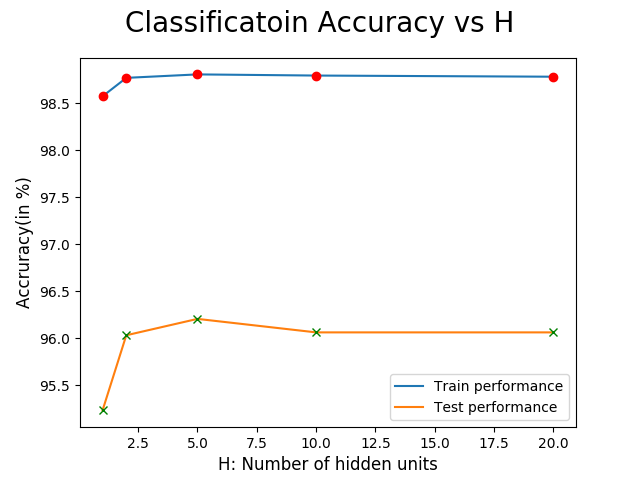

In [732]:
fig4 = plt.figure()
plt.plot(H,train_acc_1e,label="Train performance")
plt.plot(H,test_acc_1e,label="Test performance")
plt.legend()
plt.plot(H,train_acc_1e,'ro')
plt.plot(H,test_acc_1e,'gx')
fig4.suptitle('Classificatoin Accuracy vs H', fontsize=20)
plt.xlabel('H: Number of hidden units', fontsize=12)
plt.ylabel('Accruracy(in %)', fontsize=12)
# plt.xticks(range(1,11))
plt.show()

## Ques 1f

In [733]:
#1a
train_arr_1fa, test_arr_1fa, train_acc_1fa, test_acc_1fa =  ques_1a(epochs_1a, 'f')

train_arr_1fa = np.array(train_arr_1fa).flatten()
test_arr_1fa = np.array(test_arr_1fa).flatten()

#1c
train_arr_1fc, test_arr_1fc, train_acc_1fc, test_acc_1fc =  ques_1c(epochs_1c, 'f')

train_arr_1fc = np.array(train_arr_1fc).flatten()
test_arr_1fc = np.array(test_arr_1fc).flatten()

#1d
train_arr_1fd, test_arr_1fd, train_acc_1fd, test_acc_1fd =  ques_1a(epochs_1d, 'f')

train_acc_1fd = np.array(train_acc_1fd).flatten()
test_acc_1fd = np.array(test_acc_1fd).flatten()

#1e
train_arr_1fe, test_arr_1fe, train_acc_1fe, test_acc_1fe =  ques_1e(epochs_1e, 'f')

train_acc_1fe = np.array(train_acc_1fe).flatten()
test_acc_1fe = np.array(test_acc_1fe).flatten()

Epoch # 0
==>> batch index: 1, train loss: 0.000038, accuracy: 21.233
==>> batch index: 1, test loss: 0.000032, accuracy: 21.011
Epoch # 1
==>> batch index: 1, train loss: 0.000038, accuracy: 21.233
==>> batch index: 1, test loss: 0.000032, accuracy: 21.011
Epoch # 2
==>> batch index: 1, train loss: 0.000038, accuracy: 21.233
==>> batch index: 1, test loss: 0.000032, accuracy: 21.011
Epoch # 3
==>> batch index: 1, train loss: 0.000038, accuracy: 21.233
==>> batch index: 1, test loss: 0.000031, accuracy: 21.011
Epoch # 4
==>> batch index: 1, train loss: 0.000037, accuracy: 21.233
==>> batch index: 1, test loss: 0.000031, accuracy: 21.011
Epoch # 5
==>> batch index: 1, train loss: 0.000037, accuracy: 21.233
==>> batch index: 1, test loss: 0.000031, accuracy: 21.011
Epoch # 6
==>> batch index: 1, train loss: 0.000037, accuracy: 21.233
==>> batch index: 1, test loss: 0.000030, accuracy: 21.011
Epoch # 7
==>> batch index: 1, train loss: 0.000036, accuracy: 21.233
==>> batch index: 1, test l

==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 64
==>> batch index: 1, train loss: 0.000022, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 65
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 66
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 67
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 68
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 69
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 70
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000018, accuracy: 78.989
Epoch # 71
==>> batch index: 1,

==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 127
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 128
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 129
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 130
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 131
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 132
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 133
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 134
==>> batch i

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 190
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 191
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 192
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 193
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 194
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 195
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 196
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 254
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 255
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 256
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 257
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 258
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 259
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 260
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 318
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 319
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 320
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 321
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 322
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 323
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 324
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 381
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 382
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 383
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 384
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 385
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 386
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 387
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 444
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 445
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 446
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 447
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 448
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 449
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 450
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 451
==>> batch i

==>> batch index: 98, test loss: 0.312367, accuracy: 78.989
Epoch # 8
==>> batch index: 82, train loss: 0.318579, accuracy: 78.767
==>> batch index: 98, test loss: 0.313114, accuracy: 78.989
Epoch # 9
==>> batch index: 82, train loss: 0.318982, accuracy: 78.767
==>> batch index: 98, test loss: 0.313394, accuracy: 78.989
Epoch # 10
==>> batch index: 82, train loss: 0.318690, accuracy: 78.767
==>> batch index: 98, test loss: 0.312898, accuracy: 78.989
Epoch # 11
==>> batch index: 82, train loss: 0.318802, accuracy: 78.767
==>> batch index: 98, test loss: 0.313132, accuracy: 78.989
Epoch # 12
==>> batch index: 82, train loss: 0.318070, accuracy: 78.767
==>> batch index: 98, test loss: 0.312314, accuracy: 78.989
Epoch # 13
==>> batch index: 82, train loss: 0.318678, accuracy: 78.767
==>> batch index: 98, test loss: 0.312733, accuracy: 78.989
Epoch # 14
==>> batch index: 82, train loss: 0.318725, accuracy: 78.767
==>> batch index: 98, test loss: 0.312889, accuracy: 78.989
Epoch # 15
==>> ba

==>> batch index: 98, test loss: 0.310700, accuracy: 78.989
Epoch # 71
==>> batch index: 82, train loss: 0.316287, accuracy: 78.767
==>> batch index: 98, test loss: 0.311033, accuracy: 78.989
Epoch # 72
==>> batch index: 82, train loss: 0.316367, accuracy: 78.767
==>> batch index: 98, test loss: 0.311054, accuracy: 78.989
Epoch # 73
==>> batch index: 82, train loss: 0.315947, accuracy: 78.767
==>> batch index: 98, test loss: 0.310274, accuracy: 78.989
Epoch # 74
==>> batch index: 82, train loss: 0.316750, accuracy: 78.767
==>> batch index: 98, test loss: 0.310235, accuracy: 78.989
Epoch # 75
==>> batch index: 82, train loss: 0.315982, accuracy: 78.767
==>> batch index: 98, test loss: 0.310414, accuracy: 78.989
Epoch # 76
==>> batch index: 82, train loss: 0.315653, accuracy: 78.767
==>> batch index: 98, test loss: 0.310583, accuracy: 78.989
Epoch # 77
==>> batch index: 82, train loss: 0.316530, accuracy: 78.767
==>> batch index: 98, test loss: 0.310826, accuracy: 78.989
Epoch # 78
==>> 

==>> batch index: 82, train loss: 0.280187, accuracy: 78.767
==>> batch index: 98, test loss: 0.280154, accuracy: 78.989
Epoch # 135
==>> batch index: 82, train loss: 0.278138, accuracy: 78.767
==>> batch index: 98, test loss: 0.278462, accuracy: 78.989
Epoch # 136
==>> batch index: 82, train loss: 0.276633, accuracy: 78.755
==>> batch index: 98, test loss: 0.277572, accuracy: 78.989
Epoch # 137
==>> batch index: 82, train loss: 0.274823, accuracy: 78.767
==>> batch index: 98, test loss: 0.275421, accuracy: 78.989
Epoch # 138
==>> batch index: 82, train loss: 0.272061, accuracy: 78.767
==>> batch index: 98, test loss: 0.273636, accuracy: 78.989
Epoch # 139
==>> batch index: 82, train loss: 0.268990, accuracy: 78.767
==>> batch index: 98, test loss: 0.271273, accuracy: 78.989
Epoch # 140
==>> batch index: 82, train loss: 0.266732, accuracy: 78.742
==>> batch index: 98, test loss: 0.269763, accuracy: 78.999
Epoch # 141
==>> batch index: 82, train loss: 0.264153, accuracy: 78.755
==>> bat

==>> batch index: 82, train loss: 0.072222, accuracy: 98.809
==>> batch index: 98, test loss: 0.095862, accuracy: 96.216
Epoch # 198
==>> batch index: 82, train loss: 0.071561, accuracy: 98.809
==>> batch index: 98, test loss: 0.093731, accuracy: 96.708
Epoch # 199
==>> batch index: 82, train loss: 0.069743, accuracy: 98.821
==>> batch index: 98, test loss: 0.090030, accuracy: 98.329
Epoch # 200
==>> batch index: 82, train loss: 0.068655, accuracy: 98.809
==>> batch index: 98, test loss: 0.093222, accuracy: 95.950
Epoch # 201
==>> batch index: 82, train loss: 0.067102, accuracy: 98.711
==>> batch index: 98, test loss: 0.087202, accuracy: 98.718
Epoch # 202
==>> batch index: 82, train loss: 0.066762, accuracy: 98.809
==>> batch index: 98, test loss: 0.090848, accuracy: 96.308
Epoch # 203
==>> batch index: 82, train loss: 0.065730, accuracy: 98.797
==>> batch index: 98, test loss: 0.087710, accuracy: 97.190
Epoch # 204
==>> batch index: 82, train loss: 0.064207, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.041783, accuracy: 98.661
==>> batch index: 98, test loss: 0.059295, accuracy: 99.333
Epoch # 260
==>> batch index: 82, train loss: 0.041859, accuracy: 98.588
==>> batch index: 98, test loss: 0.059013, accuracy: 99.364
Epoch # 261
==>> batch index: 82, train loss: 0.041927, accuracy: 98.612
==>> batch index: 98, test loss: 0.054236, accuracy: 99.364
Epoch # 262
==>> batch index: 82, train loss: 0.041423, accuracy: 98.661
==>> batch index: 98, test loss: 0.055851, accuracy: 99.374
Epoch # 263
==>> batch index: 82, train loss: 0.041259, accuracy: 98.649
==>> batch index: 98, test loss: 0.053445, accuracy: 99.374
Epoch # 264
==>> batch index: 82, train loss: 0.041163, accuracy: 98.588
==>> batch index: 98, test loss: 0.056816, accuracy: 99.364
Epoch # 265
==>> batch index: 82, train loss: 0.040894, accuracy: 98.625
==>> batch index: 98, test loss: 0.053435, accuracy: 99.364
Epoch # 266
==>> batch index: 82, train loss: 0.041219, accuracy: 98.551
==>> bat

==>> batch index: 82, train loss: 0.036116, accuracy: 98.625
==>> batch index: 98, test loss: 0.047065, accuracy: 99.364
Epoch # 322
==>> batch index: 82, train loss: 0.036025, accuracy: 98.588
==>> batch index: 98, test loss: 0.042794, accuracy: 99.364
Epoch # 323
==>> batch index: 82, train loss: 0.035903, accuracy: 98.637
==>> batch index: 98, test loss: 0.043625, accuracy: 99.364
Epoch # 324
==>> batch index: 82, train loss: 0.035607, accuracy: 98.784
==>> batch index: 98, test loss: 0.045542, accuracy: 99.374
Epoch # 325
==>> batch index: 82, train loss: 0.035499, accuracy: 98.711
==>> batch index: 98, test loss: 0.052666, accuracy: 98.985
Epoch # 326
==>> batch index: 82, train loss: 0.035802, accuracy: 98.711
==>> batch index: 98, test loss: 0.044451, accuracy: 99.374
Epoch # 327
==>> batch index: 82, train loss: 0.035495, accuracy: 98.698
==>> batch index: 98, test loss: 0.048520, accuracy: 99.364
Epoch # 328
==>> batch index: 82, train loss: 0.035643, accuracy: 98.711
==>> bat

==>> batch index: 98, test loss: 0.036557, accuracy: 99.344
Epoch # 384
==>> batch index: 82, train loss: 0.032946, accuracy: 98.772
==>> batch index: 98, test loss: 0.037818, accuracy: 99.344
Epoch # 385
==>> batch index: 82, train loss: 0.032924, accuracy: 98.723
==>> batch index: 98, test loss: 0.035475, accuracy: 99.333
Epoch # 386
==>> batch index: 82, train loss: 0.032789, accuracy: 98.772
==>> batch index: 98, test loss: 0.039416, accuracy: 99.364
Epoch # 387
==>> batch index: 82, train loss: 0.032989, accuracy: 98.735
==>> batch index: 98, test loss: 0.049930, accuracy: 98.800
Epoch # 388
==>> batch index: 82, train loss: 0.032904, accuracy: 98.784
==>> batch index: 98, test loss: 0.047213, accuracy: 99.272
Epoch # 389
==>> batch index: 82, train loss: 0.032932, accuracy: 98.760
==>> batch index: 98, test loss: 0.040109, accuracy: 99.374
Epoch # 390
==>> batch index: 82, train loss: 0.033350, accuracy: 98.760
==>> batch index: 98, test loss: 0.050550, accuracy: 98.636
Epoch # 3

==>> batch index: 82, train loss: 0.031317, accuracy: 98.747
==>> batch index: 98, test loss: 0.058456, accuracy: 96.678
Epoch # 448
==>> batch index: 82, train loss: 0.031443, accuracy: 98.723
==>> batch index: 98, test loss: 0.057614, accuracy: 96.749
Epoch # 449
==>> batch index: 82, train loss: 0.031389, accuracy: 98.797
==>> batch index: 98, test loss: 0.040796, accuracy: 99.364
Epoch # 450
==>> batch index: 82, train loss: 0.031804, accuracy: 98.809
==>> batch index: 98, test loss: 0.046627, accuracy: 98.862
Epoch # 451
==>> batch index: 82, train loss: 0.031154, accuracy: 98.833
==>> batch index: 98, test loss: 0.046858, accuracy: 98.821
Epoch # 452
==>> batch index: 82, train loss: 0.031598, accuracy: 98.772
==>> batch index: 98, test loss: 0.034037, accuracy: 99.344
Epoch # 453
==>> batch index: 82, train loss: 0.031195, accuracy: 98.809
==>> batch index: 98, test loss: 0.041963, accuracy: 99.364
Epoch # 454
==>> batch index: 82, train loss: 0.031209, accuracy: 98.747
==>> bat

==>> batch index: 82, train loss: 0.030061, accuracy: 98.833
==>> batch index: 98, test loss: 0.044292, accuracy: 98.862
Epoch # 510
==>> batch index: 82, train loss: 0.029962, accuracy: 98.809
==>> batch index: 98, test loss: 0.048550, accuracy: 98.205
Epoch # 511
==>> batch index: 82, train loss: 0.030133, accuracy: 98.809
==>> batch index: 98, test loss: 0.047954, accuracy: 98.267
Epoch # 512
==>> batch index: 82, train loss: 0.030303, accuracy: 98.821
==>> batch index: 98, test loss: 0.049108, accuracy: 98.134
Epoch # 513
==>> batch index: 82, train loss: 0.030437, accuracy: 98.821
==>> batch index: 98, test loss: 0.045077, accuracy: 98.728
Epoch # 514
==>> batch index: 82, train loss: 0.030345, accuracy: 98.809
==>> batch index: 98, test loss: 0.043313, accuracy: 98.923
Epoch # 515
==>> batch index: 82, train loss: 0.030090, accuracy: 98.821
==>> batch index: 98, test loss: 0.052459, accuracy: 97.283
Epoch # 516
==>> batch index: 82, train loss: 0.030001, accuracy: 98.846
==>> bat

==>> batch index: 82, train loss: 0.029103, accuracy: 98.797
==>> batch index: 98, test loss: 0.049768, accuracy: 97.559
Epoch # 573
==>> batch index: 82, train loss: 0.029205, accuracy: 98.809
==>> batch index: 98, test loss: 0.043610, accuracy: 98.677
Epoch # 574
==>> batch index: 82, train loss: 0.029653, accuracy: 98.833
==>> batch index: 98, test loss: 0.035901, accuracy: 99.374
Epoch # 575
==>> batch index: 82, train loss: 0.029742, accuracy: 98.809
==>> batch index: 98, test loss: 0.057341, accuracy: 96.370
Epoch # 576
==>> batch index: 82, train loss: 0.029281, accuracy: 98.833
==>> batch index: 98, test loss: 0.047894, accuracy: 98.031
Epoch # 577
==>> batch index: 82, train loss: 0.029501, accuracy: 98.797
==>> batch index: 98, test loss: 0.041086, accuracy: 99.057
Epoch # 578
==>> batch index: 82, train loss: 0.029128, accuracy: 98.821
==>> batch index: 98, test loss: 0.035778, accuracy: 99.374
Epoch # 579
==>> batch index: 82, train loss: 0.029594, accuracy: 98.833
==>> bat

==>> batch index: 98, test loss: 0.039297, accuracy: 99.149
Epoch # 636
==>> batch index: 82, train loss: 0.028503, accuracy: 98.833
==>> batch index: 98, test loss: 0.042915, accuracy: 98.605
Epoch # 637
==>> batch index: 82, train loss: 0.028505, accuracy: 98.821
==>> batch index: 98, test loss: 0.050972, accuracy: 97.006
Epoch # 638
==>> batch index: 82, train loss: 0.028627, accuracy: 98.833
==>> batch index: 98, test loss: 0.040102, accuracy: 98.923
Epoch # 639
==>> batch index: 82, train loss: 0.028762, accuracy: 98.797
==>> batch index: 98, test loss: 0.045272, accuracy: 98.216
Epoch # 640
==>> batch index: 82, train loss: 0.028952, accuracy: 98.833
==>> batch index: 98, test loss: 0.049598, accuracy: 97.262
Epoch # 641
==>> batch index: 82, train loss: 0.028730, accuracy: 98.833
==>> batch index: 98, test loss: 0.051038, accuracy: 96.985
Epoch # 642
==>> batch index: 82, train loss: 0.028365, accuracy: 98.833
==>> batch index: 98, test loss: 0.046802, accuracy: 97.898
Epoch # 6

==>> batch index: 98, test loss: 0.036410, accuracy: 99.354
Epoch # 698
==>> batch index: 82, train loss: 0.027812, accuracy: 98.809
==>> batch index: 98, test loss: 0.039346, accuracy: 98.872
Epoch # 699
==>> batch index: 82, train loss: 0.027910, accuracy: 98.833
==>> batch index: 98, test loss: 0.045714, accuracy: 97.898
Epoch # 700
==>> batch index: 82, train loss: 0.027930, accuracy: 98.809
==>> batch index: 98, test loss: 0.044806, accuracy: 98.062
Epoch # 701
==>> batch index: 82, train loss: 0.028059, accuracy: 98.833
==>> batch index: 98, test loss: 0.048232, accuracy: 97.395
Epoch # 702
==>> batch index: 82, train loss: 0.027899, accuracy: 98.833
==>> batch index: 98, test loss: 0.058743, accuracy: 95.847
Epoch # 703
==>> batch index: 82, train loss: 0.028005, accuracy: 98.833
==>> batch index: 98, test loss: 0.047085, accuracy: 97.570
Epoch # 704
==>> batch index: 82, train loss: 0.028072, accuracy: 98.809
==>> batch index: 98, test loss: 0.042816, accuracy: 98.370
Epoch # 7

==>> batch index: 82, train loss: 0.027587, accuracy: 98.833
==>> batch index: 98, test loss: 0.046602, accuracy: 97.549
Epoch # 761
==>> batch index: 82, train loss: 0.027332, accuracy: 98.833
==>> batch index: 98, test loss: 0.042516, accuracy: 98.267
Epoch # 762
==>> batch index: 82, train loss: 0.027351, accuracy: 98.821
==>> batch index: 98, test loss: 0.044504, accuracy: 97.959
Epoch # 763
==>> batch index: 82, train loss: 0.027406, accuracy: 98.833
==>> batch index: 98, test loss: 0.058887, accuracy: 95.734
Epoch # 764
==>> batch index: 82, train loss: 0.027830, accuracy: 98.833
==>> batch index: 98, test loss: 0.043382, accuracy: 98.154
Epoch # 765
==>> batch index: 82, train loss: 0.027325, accuracy: 98.833
==>> batch index: 98, test loss: 0.032109, accuracy: 99.374
Epoch # 766
==>> batch index: 82, train loss: 0.027385, accuracy: 98.809
==>> batch index: 98, test loss: 0.033085, accuracy: 99.364
Epoch # 767
==>> batch index: 82, train loss: 0.027449, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.026971, accuracy: 98.809
==>> batch index: 98, test loss: 0.046460, accuracy: 97.416
Epoch # 823
==>> batch index: 82, train loss: 0.026861, accuracy: 98.833
==>> batch index: 98, test loss: 0.045466, accuracy: 97.549
Epoch # 824
==>> batch index: 82, train loss: 0.026997, accuracy: 98.833
==>> batch index: 98, test loss: 0.035043, accuracy: 99.272
Epoch # 825
==>> batch index: 82, train loss: 0.026843, accuracy: 98.833
==>> batch index: 98, test loss: 0.045627, accuracy: 97.518
Epoch # 826
==>> batch index: 82, train loss: 0.026927, accuracy: 98.833
==>> batch index: 98, test loss: 0.035634, accuracy: 99.159
Epoch # 827
==>> batch index: 82, train loss: 0.027184, accuracy: 98.833
==>> batch index: 98, test loss: 0.043153, accuracy: 98.052
Epoch # 828
==>> batch index: 82, train loss: 0.027473, accuracy: 98.833
==>> batch index: 98, test loss: 0.035360, accuracy: 99.169
Epoch # 829
==>> batch index: 82, train loss: 0.027158, accuracy: 98.833
==>> bat

==>> batch index: 98, test loss: 0.038230, accuracy: 98.636
Epoch # 885
==>> batch index: 82, train loss: 0.026656, accuracy: 98.833
==>> batch index: 98, test loss: 0.030399, accuracy: 99.374
Epoch # 886
==>> batch index: 82, train loss: 0.026795, accuracy: 98.821
==>> batch index: 98, test loss: 0.033260, accuracy: 99.344
Epoch # 887
==>> batch index: 82, train loss: 0.026938, accuracy: 98.846
==>> batch index: 98, test loss: 0.051310, accuracy: 96.637
Epoch # 888
==>> batch index: 82, train loss: 0.026774, accuracy: 98.833
==>> batch index: 98, test loss: 0.042399, accuracy: 98.052
Epoch # 889
==>> batch index: 82, train loss: 0.026482, accuracy: 98.833
==>> batch index: 98, test loss: 0.062266, accuracy: 95.263
Epoch # 890
==>> batch index: 82, train loss: 0.026828, accuracy: 98.846
==>> batch index: 98, test loss: 0.040503, accuracy: 98.277
Epoch # 891
==>> batch index: 82, train loss: 0.027145, accuracy: 98.833
==>> batch index: 98, test loss: 0.044189, accuracy: 97.611
Epoch # 8

==>> batch index: 98, test loss: 0.043317, accuracy: 97.724
Epoch # 947
==>> batch index: 82, train loss: 0.026757, accuracy: 98.833
==>> batch index: 98, test loss: 0.032252, accuracy: 99.333
Epoch # 948
==>> batch index: 82, train loss: 0.026482, accuracy: 98.797
==>> batch index: 98, test loss: 0.036425, accuracy: 98.800
Epoch # 949
==>> batch index: 82, train loss: 0.026199, accuracy: 98.833
==>> batch index: 98, test loss: 0.032195, accuracy: 99.344
Epoch # 950
==>> batch index: 82, train loss: 0.026476, accuracy: 98.833
==>> batch index: 98, test loss: 0.043799, accuracy: 97.549
Epoch # 951
==>> batch index: 82, train loss: 0.026404, accuracy: 98.833
==>> batch index: 98, test loss: 0.031857, accuracy: 99.354
Epoch # 952
==>> batch index: 82, train loss: 0.026528, accuracy: 98.784
==>> batch index: 98, test loss: 0.045321, accuracy: 97.303
Epoch # 953
==>> batch index: 82, train loss: 0.026616, accuracy: 98.833
==>> batch index: 98, test loss: 0.031333, accuracy: 99.364
Epoch # 9

==>> batch index: 82, train loss: 0.025867, accuracy: 98.833
==>> batch index: 98, test loss: 0.043527, accuracy: 97.529
Epoch # 1009
==>> batch index: 82, train loss: 0.026142, accuracy: 98.833
==>> batch index: 98, test loss: 0.039914, accuracy: 98.185
Epoch # 1010
==>> batch index: 82, train loss: 0.025871, accuracy: 98.833
==>> batch index: 98, test loss: 0.039637, accuracy: 98.236
Epoch # 1011
==>> batch index: 82, train loss: 0.026044, accuracy: 98.833
==>> batch index: 98, test loss: 0.039082, accuracy: 98.288
Epoch # 1012
==>> batch index: 82, train loss: 0.026121, accuracy: 98.833
==>> batch index: 98, test loss: 0.037920, accuracy: 98.441
Epoch # 1013
==>> batch index: 82, train loss: 0.025810, accuracy: 98.833
==>> batch index: 98, test loss: 0.041344, accuracy: 97.980
Epoch # 1014
==>> batch index: 82, train loss: 0.025853, accuracy: 98.833
==>> batch index: 98, test loss: 0.042093, accuracy: 97.806
Epoch # 1015
==>> batch index: 82, train loss: 0.025859, accuracy: 98.833
=

==>> batch index: 98, test loss: 0.042652, accuracy: 97.703
Epoch # 1071
==>> batch index: 82, train loss: 0.025801, accuracy: 98.833
==>> batch index: 98, test loss: 0.040608, accuracy: 98.062
Epoch # 1072
==>> batch index: 82, train loss: 0.026110, accuracy: 98.833
==>> batch index: 98, test loss: 0.040691, accuracy: 98.041
Epoch # 1073
==>> batch index: 82, train loss: 0.025779, accuracy: 98.833
==>> batch index: 98, test loss: 0.041904, accuracy: 97.918
Epoch # 1074
==>> batch index: 82, train loss: 0.026419, accuracy: 98.833
==>> batch index: 98, test loss: 0.040449, accuracy: 98.082
Epoch # 1075
==>> batch index: 82, train loss: 0.025762, accuracy: 98.833
==>> batch index: 98, test loss: 0.042323, accuracy: 97.785
Epoch # 1076
==>> batch index: 82, train loss: 0.025882, accuracy: 98.833
==>> batch index: 98, test loss: 0.041999, accuracy: 97.836
Epoch # 1077
==>> batch index: 82, train loss: 0.025801, accuracy: 98.833
==>> batch index: 98, test loss: 0.042392, accuracy: 97.775
Ep

==>> batch index: 98, test loss: 0.039485, accuracy: 98.247
Epoch # 1133
==>> batch index: 82, train loss: 0.026143, accuracy: 98.833
==>> batch index: 98, test loss: 0.037109, accuracy: 98.564
Epoch # 1134
==>> batch index: 82, train loss: 0.025749, accuracy: 98.833
==>> batch index: 98, test loss: 0.041693, accuracy: 97.959
Epoch # 1135
==>> batch index: 82, train loss: 0.025740, accuracy: 98.833
==>> batch index: 98, test loss: 0.042893, accuracy: 97.642
Epoch # 1136
==>> batch index: 82, train loss: 0.025798, accuracy: 98.833
==>> batch index: 98, test loss: 0.040027, accuracy: 98.123
Epoch # 1137
==>> batch index: 82, train loss: 0.025765, accuracy: 98.833
==>> batch index: 98, test loss: 0.038579, accuracy: 98.339
Epoch # 1138
==>> batch index: 82, train loss: 0.025836, accuracy: 98.833
==>> batch index: 98, test loss: 0.039540, accuracy: 98.195
Epoch # 1139
==>> batch index: 82, train loss: 0.026110, accuracy: 98.833
==>> batch index: 98, test loss: 0.041524, accuracy: 97.980
Ep

==>> batch index: 82, train loss: 0.025728, accuracy: 98.833
==>> batch index: 98, test loss: 0.039578, accuracy: 98.185
Epoch # 1195
==>> batch index: 82, train loss: 0.025733, accuracy: 98.833
==>> batch index: 98, test loss: 0.040392, accuracy: 98.072
Epoch # 1196
==>> batch index: 82, train loss: 0.026037, accuracy: 98.833
==>> batch index: 98, test loss: 0.041920, accuracy: 97.806
Epoch # 1197
==>> batch index: 82, train loss: 0.025754, accuracy: 98.833
==>> batch index: 98, test loss: 0.037459, accuracy: 98.523
Epoch # 1198
==>> batch index: 82, train loss: 0.026049, accuracy: 98.833
==>> batch index: 98, test loss: 0.042217, accuracy: 97.785
Epoch # 1199
==>> batch index: 82, train loss: 0.025760, accuracy: 98.833
==>> batch index: 98, test loss: 0.043672, accuracy: 97.518
Epoch # 1200
==>> batch index: 82, train loss: 0.025723, accuracy: 98.833
==>> batch index: 98, test loss: 0.040729, accuracy: 98.041
Epoch # 1201
==>> batch index: 82, train loss: 0.025767, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.025793, accuracy: 98.833
==>> batch index: 98, test loss: 0.039016, accuracy: 98.257
Epoch # 1257
==>> batch index: 82, train loss: 0.026007, accuracy: 98.833
==>> batch index: 98, test loss: 0.040030, accuracy: 98.113
Epoch # 1258
==>> batch index: 82, train loss: 0.026006, accuracy: 98.833
==>> batch index: 98, test loss: 0.038936, accuracy: 98.267
Epoch # 1259
==>> batch index: 82, train loss: 0.025682, accuracy: 98.833
==>> batch index: 98, test loss: 0.042602, accuracy: 97.744
Epoch # 1260
==>> batch index: 82, train loss: 0.025787, accuracy: 98.833
==>> batch index: 98, test loss: 0.040819, accuracy: 98.031
Epoch # 1261
==>> batch index: 82, train loss: 0.025771, accuracy: 98.833
==>> batch index: 98, test loss: 0.040343, accuracy: 98.082
Epoch # 1262
==>> batch index: 82, train loss: 0.025727, accuracy: 98.833
==>> batch index: 98, test loss: 0.041588, accuracy: 97.877
Epoch # 1263
==>> batch index: 82, train loss: 0.026019, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.025694, accuracy: 98.833
==>> batch index: 98, test loss: 0.039511, accuracy: 98.185
Epoch # 1319
==>> batch index: 82, train loss: 0.025965, accuracy: 98.833
==>> batch index: 98, test loss: 0.042069, accuracy: 97.785
Epoch # 1320
==>> batch index: 82, train loss: 0.026061, accuracy: 98.833
==>> batch index: 98, test loss: 0.040103, accuracy: 98.113
Epoch # 1321
==>> batch index: 82, train loss: 0.025736, accuracy: 98.833
==>> batch index: 98, test loss: 0.037999, accuracy: 98.380
Epoch # 1322
==>> batch index: 82, train loss: 0.025705, accuracy: 98.833
==>> batch index: 98, test loss: 0.038441, accuracy: 98.339
Epoch # 1323
==>> batch index: 82, train loss: 0.026013, accuracy: 98.833
==>> batch index: 98, test loss: 0.040750, accuracy: 98.041
Epoch # 1324
==>> batch index: 82, train loss: 0.026404, accuracy: 98.833
==>> batch index: 98, test loss: 0.040877, accuracy: 98.000
Epoch # 1325
==>> batch index: 82, train loss: 0.025721, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.025782, accuracy: 98.833
==>> batch index: 98, test loss: 0.039252, accuracy: 98.195
Epoch # 1381
==>> batch index: 82, train loss: 0.025708, accuracy: 98.833
==>> batch index: 98, test loss: 0.039986, accuracy: 98.113
Epoch # 1382
==>> batch index: 82, train loss: 0.025684, accuracy: 98.833
==>> batch index: 98, test loss: 0.041673, accuracy: 97.816
Epoch # 1383
==>> batch index: 82, train loss: 0.025940, accuracy: 98.833
==>> batch index: 98, test loss: 0.038997, accuracy: 98.247
Epoch # 1384
==>> batch index: 82, train loss: 0.025718, accuracy: 98.833
==>> batch index: 98, test loss: 0.039109, accuracy: 98.236
Epoch # 1385
==>> batch index: 82, train loss: 0.025651, accuracy: 98.833
==>> batch index: 98, test loss: 0.041089, accuracy: 97.959
Epoch # 1386
==>> batch index: 82, train loss: 0.025948, accuracy: 98.833
==>> batch index: 98, test loss: 0.040968, accuracy: 97.970
Epoch # 1387
==>> batch index: 82, train loss: 0.025700, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.025746, accuracy: 98.833
==>> batch index: 98, test loss: 0.038415, accuracy: 98.308
Epoch # 1443
==>> batch index: 82, train loss: 0.025693, accuracy: 98.833
==>> batch index: 98, test loss: 0.040889, accuracy: 98.011
Epoch # 1444
==>> batch index: 82, train loss: 0.025922, accuracy: 98.833
==>> batch index: 98, test loss: 0.041564, accuracy: 97.939
Epoch # 1445
==>> batch index: 82, train loss: 0.025891, accuracy: 98.833
==>> batch index: 98, test loss: 0.037319, accuracy: 98.452
Epoch # 1446
==>> batch index: 82, train loss: 0.025712, accuracy: 98.833
==>> batch index: 98, test loss: 0.040124, accuracy: 98.062
Epoch # 1447
==>> batch index: 82, train loss: 0.025640, accuracy: 98.833
==>> batch index: 98, test loss: 0.038303, accuracy: 98.329
Epoch # 1448
==>> batch index: 82, train loss: 0.025828, accuracy: 98.833
==>> batch index: 98, test loss: 0.041451, accuracy: 97.888
Epoch # 1449
==>> batch index: 82, train loss: 0.025622, accuracy: 98.833
=

==>> batch index: 1, test loss: 0.000023, accuracy: 78.989
Epoch # 4
==>> batch index: 1, train loss: 0.000027, accuracy: 78.767
==>> batch index: 1, test loss: 0.000023, accuracy: 78.989
Epoch # 5
==>> batch index: 1, train loss: 0.000027, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 6
==>> batch index: 1, train loss: 0.000027, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 7
==>> batch index: 1, train loss: 0.000027, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 8
==>> batch index: 1, train loss: 0.000026, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 9
==>> batch index: 1, train loss: 0.000026, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 10
==>> batch index: 1, train loss: 0.000026, accuracy: 78.767
==>> batch index: 1, test loss: 0.000022, accuracy: 78.989
Epoch # 11
==>> batch index: 1, train

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 69
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 70
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 71
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 72
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 73
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 74
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 75
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 132
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 133
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 134
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 135
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 136
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 137
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 138
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 195
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 196
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 197
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 198
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 199
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 200
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 201
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 202
==>> batch i

==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 258
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 259
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 260
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 261
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 262
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 263
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 264
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 265
==>> batch i

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 322
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 323
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 324
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 325
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 326
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 327
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 328
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 385
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 386
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 387
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 388
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 389
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 390
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 391
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, te

==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 448
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 449
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 450
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 451
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 452
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 453
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 454
==>> batch index: 1, train loss: 0.000021, accuracy: 78.767
==>> batch index: 1, test loss: 0.000017, accuracy: 78.989
Epoch # 455
==>> batch i

==>> batch index: 98, test loss: 0.333918, accuracy: 78.989
Epoch # 12
==>> batch index: 82, train loss: 0.337189, accuracy: 78.767
==>> batch index: 98, test loss: 0.329656, accuracy: 78.989
Epoch # 13
==>> batch index: 82, train loss: 0.334102, accuracy: 78.767
==>> batch index: 98, test loss: 0.326310, accuracy: 78.989
Epoch # 14
==>> batch index: 82, train loss: 0.331218, accuracy: 78.767
==>> batch index: 98, test loss: 0.323595, accuracy: 78.989
Epoch # 15
==>> batch index: 82, train loss: 0.327933, accuracy: 78.767
==>> batch index: 98, test loss: 0.321634, accuracy: 78.989
Epoch # 16
==>> batch index: 82, train loss: 0.326277, accuracy: 78.767
==>> batch index: 98, test loss: 0.319817, accuracy: 78.989
Epoch # 17
==>> batch index: 82, train loss: 0.324731, accuracy: 78.767
==>> batch index: 98, test loss: 0.318558, accuracy: 78.989
Epoch # 18
==>> batch index: 82, train loss: 0.323935, accuracy: 78.767
==>> batch index: 98, test loss: 0.317208, accuracy: 78.989
Epoch # 19
==>> 

==>> batch index: 98, test loss: 0.311470, accuracy: 78.989
Epoch # 76
==>> batch index: 82, train loss: 0.316938, accuracy: 78.767
==>> batch index: 98, test loss: 0.311202, accuracy: 78.989
Epoch # 77
==>> batch index: 82, train loss: 0.317562, accuracy: 78.767
==>> batch index: 98, test loss: 0.311448, accuracy: 78.989
Epoch # 78
==>> batch index: 82, train loss: 0.317113, accuracy: 78.767
==>> batch index: 98, test loss: 0.311278, accuracy: 78.989
Epoch # 79
==>> batch index: 82, train loss: 0.317541, accuracy: 78.767
==>> batch index: 98, test loss: 0.311409, accuracy: 78.989
Epoch # 80
==>> batch index: 82, train loss: 0.316209, accuracy: 78.767
==>> batch index: 98, test loss: 0.310935, accuracy: 78.989
Epoch # 81
==>> batch index: 82, train loss: 0.316289, accuracy: 78.767
==>> batch index: 98, test loss: 0.310951, accuracy: 78.989
Epoch # 82
==>> batch index: 82, train loss: 0.316874, accuracy: 78.767
==>> batch index: 98, test loss: 0.311489, accuracy: 78.989
Epoch # 83
==>> 

==>> batch index: 98, test loss: 0.299395, accuracy: 78.989
Epoch # 138
==>> batch index: 82, train loss: 0.299655, accuracy: 78.767
==>> batch index: 98, test loss: 0.299209, accuracy: 78.989
Epoch # 139
==>> batch index: 82, train loss: 0.300106, accuracy: 78.767
==>> batch index: 98, test loss: 0.298348, accuracy: 78.989
Epoch # 140
==>> batch index: 82, train loss: 0.299399, accuracy: 78.767
==>> batch index: 98, test loss: 0.297670, accuracy: 78.989
Epoch # 141
==>> batch index: 82, train loss: 0.298322, accuracy: 78.767
==>> batch index: 98, test loss: 0.297848, accuracy: 78.989
Epoch # 142
==>> batch index: 82, train loss: 0.297933, accuracy: 78.767
==>> batch index: 98, test loss: 0.297830, accuracy: 78.989
Epoch # 143
==>> batch index: 82, train loss: 0.296710, accuracy: 78.767
==>> batch index: 98, test loss: 0.297421, accuracy: 78.989
Epoch # 144
==>> batch index: 82, train loss: 0.296274, accuracy: 78.767
==>> batch index: 98, test loss: 0.296889, accuracy: 78.989
Epoch # 1

==>> batch index: 98, test loss: 0.262638, accuracy: 78.989
Epoch # 200
==>> batch index: 82, train loss: 0.248203, accuracy: 78.755
==>> batch index: 98, test loss: 0.262114, accuracy: 78.999
Epoch # 201
==>> batch index: 82, train loss: 0.247457, accuracy: 78.755
==>> batch index: 98, test loss: 0.261036, accuracy: 78.999
Epoch # 202
==>> batch index: 82, train loss: 0.245618, accuracy: 78.755
==>> batch index: 98, test loss: 0.260842, accuracy: 78.999
Epoch # 203
==>> batch index: 82, train loss: 0.244651, accuracy: 78.742
==>> batch index: 98, test loss: 0.259358, accuracy: 78.999
Epoch # 204
==>> batch index: 82, train loss: 0.243579, accuracy: 78.742
==>> batch index: 98, test loss: 0.258822, accuracy: 78.999
Epoch # 205
==>> batch index: 82, train loss: 0.242107, accuracy: 78.742
==>> batch index: 98, test loss: 0.257963, accuracy: 78.999
Epoch # 206
==>> batch index: 82, train loss: 0.241202, accuracy: 78.742
==>> batch index: 98, test loss: 0.256725, accuracy: 78.999
Epoch # 2

==>> batch index: 98, test loss: 0.202156, accuracy: 79.553
Epoch # 263
==>> batch index: 82, train loss: 0.168989, accuracy: 85.423
==>> batch index: 98, test loss: 0.201227, accuracy: 79.789
Epoch # 264
==>> batch index: 82, train loss: 0.168199, accuracy: 85.693
==>> batch index: 98, test loss: 0.199956, accuracy: 79.963
Epoch # 265
==>> batch index: 82, train loss: 0.166951, accuracy: 86.246
==>> batch index: 98, test loss: 0.198941, accuracy: 80.086
Epoch # 266
==>> batch index: 82, train loss: 0.165613, accuracy: 86.234
==>> batch index: 98, test loss: 0.197888, accuracy: 80.148
Epoch # 267
==>> batch index: 82, train loss: 0.164330, accuracy: 86.614
==>> batch index: 98, test loss: 0.196604, accuracy: 80.425
Epoch # 268
==>> batch index: 82, train loss: 0.163014, accuracy: 86.921
==>> batch index: 98, test loss: 0.195968, accuracy: 80.425
Epoch # 269
==>> batch index: 82, train loss: 0.162169, accuracy: 87.216
==>> batch index: 98, test loss: 0.194691, accuracy: 80.712
Epoch # 2

==>> batch index: 98, test loss: 0.143399, accuracy: 86.710
Epoch # 325
==>> batch index: 82, train loss: 0.104262, accuracy: 96.819
==>> batch index: 98, test loss: 0.142332, accuracy: 86.710
Epoch # 326
==>> batch index: 82, train loss: 0.103543, accuracy: 96.807
==>> batch index: 98, test loss: 0.141919, accuracy: 86.690
Epoch # 327
==>> batch index: 82, train loss: 0.102780, accuracy: 96.832
==>> batch index: 98, test loss: 0.140429, accuracy: 87.059
Epoch # 328
==>> batch index: 82, train loss: 0.101906, accuracy: 96.832
==>> batch index: 98, test loss: 0.140228, accuracy: 86.905
Epoch # 329
==>> batch index: 82, train loss: 0.101412, accuracy: 96.893
==>> batch index: 98, test loss: 0.139454, accuracy: 87.008
Epoch # 330
==>> batch index: 82, train loss: 0.100220, accuracy: 96.918
==>> batch index: 98, test loss: 0.138433, accuracy: 87.182
Epoch # 331
==>> batch index: 82, train loss: 0.099770, accuracy: 96.918
==>> batch index: 98, test loss: 0.137579, accuracy: 87.182
Epoch # 3

==>> batch index: 98, test loss: 0.101656, accuracy: 94.196
Epoch # 387
==>> batch index: 82, train loss: 0.066828, accuracy: 98.158
==>> batch index: 98, test loss: 0.100585, accuracy: 94.278
Epoch # 388
==>> batch index: 82, train loss: 0.066207, accuracy: 98.219
==>> batch index: 98, test loss: 0.100888, accuracy: 94.176
Epoch # 389
==>> batch index: 82, train loss: 0.065863, accuracy: 98.195
==>> batch index: 98, test loss: 0.099661, accuracy: 94.278
Epoch # 390
==>> batch index: 82, train loss: 0.065516, accuracy: 98.182
==>> batch index: 98, test loss: 0.099101, accuracy: 94.360
Epoch # 391
==>> batch index: 82, train loss: 0.064967, accuracy: 98.268
==>> batch index: 98, test loss: 0.099282, accuracy: 94.258
Epoch # 392
==>> batch index: 82, train loss: 0.064641, accuracy: 98.232
==>> batch index: 98, test loss: 0.098262, accuracy: 94.370
Epoch # 393
==>> batch index: 82, train loss: 0.064267, accuracy: 98.281
==>> batch index: 98, test loss: 0.097879, accuracy: 94.432
Epoch # 3

==>> batch index: 98, test loss: 0.076169, accuracy: 96.134
Epoch # 449
==>> batch index: 82, train loss: 0.048213, accuracy: 98.661
==>> batch index: 98, test loss: 0.075084, accuracy: 96.329
Epoch # 450
==>> batch index: 82, train loss: 0.048056, accuracy: 98.661
==>> batch index: 98, test loss: 0.074983, accuracy: 96.319
Epoch # 451
==>> batch index: 82, train loss: 0.048100, accuracy: 98.686
==>> batch index: 98, test loss: 0.074998, accuracy: 96.267
Epoch # 452
==>> batch index: 82, train loss: 0.047697, accuracy: 98.661
==>> batch index: 98, test loss: 0.075441, accuracy: 96.062
Epoch # 453
==>> batch index: 82, train loss: 0.047505, accuracy: 98.661
==>> batch index: 98, test loss: 0.074396, accuracy: 96.319
Epoch # 454
==>> batch index: 82, train loss: 0.047450, accuracy: 98.686
==>> batch index: 98, test loss: 0.074006, accuracy: 96.319
Epoch # 455
==>> batch index: 82, train loss: 0.047142, accuracy: 98.686
==>> batch index: 98, test loss: 0.073744, accuracy: 96.349
Epoch # 4

==>> batch index: 98, test loss: 0.317193, accuracy: 78.989
Epoch # 11
==>> batch index: 82, train loss: 0.323070, accuracy: 78.767
==>> batch index: 98, test loss: 0.314980, accuracy: 78.989
Epoch # 12
==>> batch index: 82, train loss: 0.319865, accuracy: 78.767
==>> batch index: 98, test loss: 0.313602, accuracy: 78.989
Epoch # 13
==>> batch index: 82, train loss: 0.319160, accuracy: 78.767
==>> batch index: 98, test loss: 0.312677, accuracy: 78.989
Epoch # 14
==>> batch index: 82, train loss: 0.318373, accuracy: 78.767
==>> batch index: 98, test loss: 0.312114, accuracy: 78.989
Epoch # 15
==>> batch index: 82, train loss: 0.317841, accuracy: 78.767
==>> batch index: 98, test loss: 0.312137, accuracy: 78.989
Epoch # 16
==>> batch index: 82, train loss: 0.317637, accuracy: 78.767
==>> batch index: 98, test loss: 0.312016, accuracy: 78.989
Epoch # 17
==>> batch index: 82, train loss: 0.316834, accuracy: 78.767
==>> batch index: 98, test loss: 0.311506, accuracy: 78.989
Epoch # 18
==>> 

==>> batch index: 98, test loss: 0.301620, accuracy: 78.989
Epoch # 74
==>> batch index: 82, train loss: 0.303805, accuracy: 78.767
==>> batch index: 98, test loss: 0.301505, accuracy: 78.989
Epoch # 75
==>> batch index: 82, train loss: 0.304034, accuracy: 78.767
==>> batch index: 98, test loss: 0.301102, accuracy: 78.989
Epoch # 76
==>> batch index: 82, train loss: 0.303270, accuracy: 78.767
==>> batch index: 98, test loss: 0.300785, accuracy: 78.989
Epoch # 77
==>> batch index: 82, train loss: 0.302512, accuracy: 78.767
==>> batch index: 98, test loss: 0.300750, accuracy: 78.989
Epoch # 78
==>> batch index: 82, train loss: 0.302065, accuracy: 78.767
==>> batch index: 98, test loss: 0.300136, accuracy: 78.989
Epoch # 79
==>> batch index: 82, train loss: 0.302107, accuracy: 78.767
==>> batch index: 98, test loss: 0.300267, accuracy: 78.989
Epoch # 80
==>> batch index: 82, train loss: 0.300792, accuracy: 78.767
==>> batch index: 98, test loss: 0.299822, accuracy: 78.989
Epoch # 81
==>> 

==>> batch index: 98, test loss: 0.267369, accuracy: 78.989
Epoch # 136
==>> batch index: 82, train loss: 0.256141, accuracy: 78.767
==>> batch index: 98, test loss: 0.266820, accuracy: 78.989
Epoch # 137
==>> batch index: 82, train loss: 0.254619, accuracy: 78.767
==>> batch index: 98, test loss: 0.265179, accuracy: 78.989
Epoch # 138
==>> batch index: 82, train loss: 0.253833, accuracy: 78.767
==>> batch index: 98, test loss: 0.264822, accuracy: 78.989
Epoch # 139
==>> batch index: 82, train loss: 0.252791, accuracy: 78.755
==>> batch index: 98, test loss: 0.263846, accuracy: 78.989
Epoch # 140
==>> batch index: 82, train loss: 0.251019, accuracy: 78.755
==>> batch index: 98, test loss: 0.262753, accuracy: 78.999
Epoch # 141
==>> batch index: 82, train loss: 0.250287, accuracy: 78.755
==>> batch index: 98, test loss: 0.262083, accuracy: 78.999
Epoch # 142
==>> batch index: 82, train loss: 0.248758, accuracy: 78.755
==>> batch index: 98, test loss: 0.260767, accuracy: 78.999
Epoch # 1

==>> batch index: 98, test loss: 0.198387, accuracy: 80.107
Epoch # 198
==>> batch index: 82, train loss: 0.167270, accuracy: 85.288
==>> batch index: 98, test loss: 0.197019, accuracy: 80.312
Epoch # 199
==>> batch index: 82, train loss: 0.165679, accuracy: 85.865
==>> batch index: 98, test loss: 0.196360, accuracy: 80.312
Epoch # 200
==>> batch index: 82, train loss: 0.164227, accuracy: 86.172
==>> batch index: 98, test loss: 0.194898, accuracy: 80.301
Epoch # 201
==>> batch index: 82, train loss: 0.163288, accuracy: 86.135
==>> batch index: 98, test loss: 0.193703, accuracy: 80.619
Epoch # 202
==>> batch index: 82, train loss: 0.161015, accuracy: 87.241
==>> batch index: 98, test loss: 0.192101, accuracy: 80.630
Epoch # 203
==>> batch index: 82, train loss: 0.159855, accuracy: 87.253
==>> batch index: 98, test loss: 0.191051, accuracy: 80.722
Epoch # 204
==>> batch index: 82, train loss: 0.158476, accuracy: 87.523
==>> batch index: 98, test loss: 0.190061, accuracy: 80.896
Epoch # 2

==>> batch index: 98, test loss: 0.129240, accuracy: 87.961
Epoch # 260
==>> batch index: 82, train loss: 0.092278, accuracy: 97.225
==>> batch index: 98, test loss: 0.128043, accuracy: 88.372
Epoch # 261
==>> batch index: 82, train loss: 0.091403, accuracy: 97.225
==>> batch index: 98, test loss: 0.127150, accuracy: 88.864
Epoch # 262
==>> batch index: 82, train loss: 0.090348, accuracy: 97.470
==>> batch index: 98, test loss: 0.126334, accuracy: 88.813
Epoch # 263
==>> batch index: 82, train loss: 0.089662, accuracy: 97.335
==>> batch index: 98, test loss: 0.125869, accuracy: 88.679
Epoch # 264
==>> batch index: 82, train loss: 0.088715, accuracy: 97.630
==>> batch index: 98, test loss: 0.124785, accuracy: 88.977
Epoch # 265
==>> batch index: 82, train loss: 0.088099, accuracy: 97.532
==>> batch index: 98, test loss: 0.123561, accuracy: 89.858
Epoch # 266
==>> batch index: 82, train loss: 0.086974, accuracy: 97.753
==>> batch index: 98, test loss: 0.123365, accuracy: 89.192
Epoch # 2

==>> batch index: 98, test loss: 0.086167, accuracy: 95.775
Epoch # 323
==>> batch index: 82, train loss: 0.055786, accuracy: 98.600
==>> batch index: 98, test loss: 0.084829, accuracy: 95.960
Epoch # 324
==>> batch index: 82, train loss: 0.055489, accuracy: 98.612
==>> batch index: 98, test loss: 0.085004, accuracy: 95.837
Epoch # 325
==>> batch index: 82, train loss: 0.055171, accuracy: 98.674
==>> batch index: 98, test loss: 0.084884, accuracy: 95.816
Epoch # 326
==>> batch index: 82, train loss: 0.055185, accuracy: 98.674
==>> batch index: 98, test loss: 0.084464, accuracy: 95.816
Epoch # 327
==>> batch index: 82, train loss: 0.054467, accuracy: 98.649
==>> batch index: 98, test loss: 0.083691, accuracy: 95.929
Epoch # 328
==>> batch index: 82, train loss: 0.054247, accuracy: 98.686
==>> batch index: 98, test loss: 0.082939, accuracy: 95.960
Epoch # 329
==>> batch index: 82, train loss: 0.053845, accuracy: 98.649
==>> batch index: 98, test loss: 0.082120, accuracy: 96.001
Epoch # 3

==>> batch index: 98, test loss: 0.064867, accuracy: 97.098
Epoch # 386
==>> batch index: 82, train loss: 0.041696, accuracy: 98.809
==>> batch index: 98, test loss: 0.064215, accuracy: 97.252
Epoch # 387
==>> batch index: 82, train loss: 0.041701, accuracy: 98.809
==>> batch index: 98, test loss: 0.063534, accuracy: 97.313
Epoch # 388
==>> batch index: 82, train loss: 0.041162, accuracy: 98.797
==>> batch index: 98, test loss: 0.063231, accuracy: 97.313
Epoch # 389
==>> batch index: 82, train loss: 0.041032, accuracy: 98.809
==>> batch index: 98, test loss: 0.064568, accuracy: 96.965
Epoch # 390
==>> batch index: 82, train loss: 0.041285, accuracy: 98.821
==>> batch index: 98, test loss: 0.063328, accuracy: 97.252
Epoch # 391
==>> batch index: 82, train loss: 0.040898, accuracy: 98.797
==>> batch index: 98, test loss: 0.063254, accuracy: 97.252
Epoch # 392
==>> batch index: 82, train loss: 0.040764, accuracy: 98.821
==>> batch index: 98, test loss: 0.063241, accuracy: 97.262
Epoch # 3

==>> batch index: 98, test loss: 0.055016, accuracy: 97.611
Epoch # 448
==>> batch index: 82, train loss: 0.035548, accuracy: 98.833
==>> batch index: 98, test loss: 0.055705, accuracy: 97.354
Epoch # 449
==>> batch index: 82, train loss: 0.035510, accuracy: 98.833
==>> batch index: 98, test loss: 0.055103, accuracy: 97.539
Epoch # 450
==>> batch index: 82, train loss: 0.035213, accuracy: 98.821
==>> batch index: 98, test loss: 0.054468, accuracy: 97.672
Epoch # 451
==>> batch index: 82, train loss: 0.035083, accuracy: 98.833
==>> batch index: 98, test loss: 0.054144, accuracy: 97.683
Epoch # 452
==>> batch index: 82, train loss: 0.035115, accuracy: 98.833
==>> batch index: 98, test loss: 0.053883, accuracy: 97.713
Epoch # 453
==>> batch index: 82, train loss: 0.034933, accuracy: 98.833
==>> batch index: 98, test loss: 0.054904, accuracy: 97.477
Epoch # 454
==>> batch index: 82, train loss: 0.034809, accuracy: 98.833
==>> batch index: 98, test loss: 0.053765, accuracy: 97.713
Epoch # 4

==>> batch index: 98, test loss: 0.312741, accuracy: 78.989
Epoch # 11
==>> batch index: 82, train loss: 0.317356, accuracy: 78.767
==>> batch index: 98, test loss: 0.311802, accuracy: 78.989
Epoch # 12
==>> batch index: 82, train loss: 0.317366, accuracy: 78.767
==>> batch index: 98, test loss: 0.312027, accuracy: 78.989
Epoch # 13
==>> batch index: 82, train loss: 0.318031, accuracy: 78.767
==>> batch index: 98, test loss: 0.311759, accuracy: 78.989
Epoch # 14
==>> batch index: 82, train loss: 0.317338, accuracy: 78.767
==>> batch index: 98, test loss: 0.311745, accuracy: 78.989
Epoch # 15
==>> batch index: 82, train loss: 0.316853, accuracy: 78.767
==>> batch index: 98, test loss: 0.311536, accuracy: 78.989
Epoch # 16
==>> batch index: 82, train loss: 0.316543, accuracy: 78.767
==>> batch index: 98, test loss: 0.311522, accuracy: 78.989
Epoch # 17
==>> batch index: 82, train loss: 0.317979, accuracy: 78.767
==>> batch index: 98, test loss: 0.311427, accuracy: 78.989
Epoch # 18
==>> 

==>> batch index: 98, test loss: 0.298879, accuracy: 78.989
Epoch # 74
==>> batch index: 82, train loss: 0.299068, accuracy: 78.767
==>> batch index: 98, test loss: 0.298593, accuracy: 78.989
Epoch # 75
==>> batch index: 82, train loss: 0.299350, accuracy: 78.767
==>> batch index: 98, test loss: 0.298119, accuracy: 78.989
Epoch # 76
==>> batch index: 82, train loss: 0.297559, accuracy: 78.767
==>> batch index: 98, test loss: 0.297432, accuracy: 78.989
Epoch # 77
==>> batch index: 82, train loss: 0.297677, accuracy: 78.767
==>> batch index: 98, test loss: 0.297118, accuracy: 78.989
Epoch # 78
==>> batch index: 82, train loss: 0.296964, accuracy: 78.767
==>> batch index: 98, test loss: 0.296790, accuracy: 78.989
Epoch # 79
==>> batch index: 82, train loss: 0.295742, accuracy: 78.767
==>> batch index: 98, test loss: 0.295614, accuracy: 78.989
Epoch # 80
==>> batch index: 82, train loss: 0.295442, accuracy: 78.767
==>> batch index: 98, test loss: 0.295431, accuracy: 78.989
Epoch # 81
==>> 

==>> batch index: 98, test loss: 0.240680, accuracy: 79.009
Epoch # 137
==>> batch index: 82, train loss: 0.218817, accuracy: 78.742
==>> batch index: 98, test loss: 0.239597, accuracy: 79.009
Epoch # 138
==>> batch index: 82, train loss: 0.217634, accuracy: 78.767
==>> batch index: 98, test loss: 0.237784, accuracy: 79.009
Epoch # 139
==>> batch index: 82, train loss: 0.215341, accuracy: 79.357
==>> batch index: 98, test loss: 0.236530, accuracy: 79.009
Epoch # 140
==>> batch index: 82, train loss: 0.213089, accuracy: 79.381
==>> batch index: 98, test loss: 0.235191, accuracy: 79.020
Epoch # 141
==>> batch index: 82, train loss: 0.211929, accuracy: 80.007
==>> batch index: 98, test loss: 0.233377, accuracy: 79.020
Epoch # 142
==>> batch index: 82, train loss: 0.209842, accuracy: 80.155
==>> batch index: 98, test loss: 0.232162, accuracy: 79.020
Epoch # 143
==>> batch index: 82, train loss: 0.208289, accuracy: 80.499
==>> batch index: 98, test loss: 0.230661, accuracy: 79.020
Epoch # 1

==>> batch index: 98, test loss: 0.151976, accuracy: 85.634
Epoch # 199
==>> batch index: 82, train loss: 0.113938, accuracy: 95.997
==>> batch index: 98, test loss: 0.150714, accuracy: 85.777
Epoch # 200
==>> batch index: 82, train loss: 0.112144, accuracy: 96.218
==>> batch index: 98, test loss: 0.148824, accuracy: 85.900
Epoch # 201
==>> batch index: 82, train loss: 0.111223, accuracy: 96.267
==>> batch index: 98, test loss: 0.147813, accuracy: 85.921
Epoch # 202
==>> batch index: 82, train loss: 0.109902, accuracy: 96.451
==>> batch index: 98, test loss: 0.146559, accuracy: 85.982
Epoch # 203
==>> batch index: 82, train loss: 0.108348, accuracy: 96.574
==>> batch index: 98, test loss: 0.144825, accuracy: 86.126
Epoch # 204
==>> batch index: 82, train loss: 0.107293, accuracy: 96.500
==>> batch index: 98, test loss: 0.144146, accuracy: 86.116
Epoch # 205
==>> batch index: 82, train loss: 0.105875, accuracy: 96.746
==>> batch index: 98, test loss: 0.143558, accuracy: 86.034
Epoch # 2

==>> batch index: 82, train loss: 0.059713, accuracy: 98.465
==>> batch index: 98, test loss: 0.091545, accuracy: 94.914
Epoch # 263
==>> batch index: 82, train loss: 0.059308, accuracy: 98.453
==>> batch index: 98, test loss: 0.090513, accuracy: 95.273
Epoch # 264
==>> batch index: 82, train loss: 0.058778, accuracy: 98.490
==>> batch index: 98, test loss: 0.088705, accuracy: 95.755
Epoch # 265
==>> batch index: 82, train loss: 0.058564, accuracy: 98.453
==>> batch index: 98, test loss: 0.087835, accuracy: 95.826
Epoch # 266
==>> batch index: 82, train loss: 0.057977, accuracy: 98.539
==>> batch index: 98, test loss: 0.088578, accuracy: 95.478
Epoch # 267
==>> batch index: 82, train loss: 0.057373, accuracy: 98.477
==>> batch index: 98, test loss: 0.087334, accuracy: 95.755
Epoch # 268
==>> batch index: 82, train loss: 0.057230, accuracy: 98.539
==>> batch index: 98, test loss: 0.087962, accuracy: 95.478
Epoch # 269
==>> batch index: 82, train loss: 0.056652, accuracy: 98.526
==>> bat

==>> batch index: 82, train loss: 0.041436, accuracy: 98.772
==>> batch index: 98, test loss: 0.063963, accuracy: 97.211
Epoch # 326
==>> batch index: 82, train loss: 0.041221, accuracy: 98.772
==>> batch index: 98, test loss: 0.064431, accuracy: 97.098
Epoch # 327
==>> batch index: 82, train loss: 0.041278, accuracy: 98.760
==>> batch index: 98, test loss: 0.063782, accuracy: 97.180
Epoch # 328
==>> batch index: 82, train loss: 0.041381, accuracy: 98.760
==>> batch index: 98, test loss: 0.062733, accuracy: 97.365
Epoch # 329
==>> batch index: 82, train loss: 0.040862, accuracy: 98.760
==>> batch index: 98, test loss: 0.062615, accuracy: 97.354
Epoch # 330
==>> batch index: 82, train loss: 0.040701, accuracy: 98.784
==>> batch index: 98, test loss: 0.062980, accuracy: 97.231
Epoch # 331
==>> batch index: 82, train loss: 0.040617, accuracy: 98.784
==>> batch index: 98, test loss: 0.062631, accuracy: 97.252
Epoch # 332
==>> batch index: 82, train loss: 0.040550, accuracy: 98.797
==>> bat

==>> batch index: 98, test loss: 0.053858, accuracy: 97.590
Epoch # 388
==>> batch index: 82, train loss: 0.034626, accuracy: 98.833
==>> batch index: 98, test loss: 0.053427, accuracy: 97.683
Epoch # 389
==>> batch index: 82, train loss: 0.034513, accuracy: 98.833
==>> batch index: 98, test loss: 0.052728, accuracy: 97.785
Epoch # 390
==>> batch index: 82, train loss: 0.034587, accuracy: 98.833
==>> batch index: 98, test loss: 0.053656, accuracy: 97.570
Epoch # 391
==>> batch index: 82, train loss: 0.034254, accuracy: 98.833
==>> batch index: 98, test loss: 0.052569, accuracy: 97.785
Epoch # 392
==>> batch index: 82, train loss: 0.034201, accuracy: 98.833
==>> batch index: 98, test loss: 0.055636, accuracy: 97.252
Epoch # 393
==>> batch index: 82, train loss: 0.034173, accuracy: 98.833
==>> batch index: 98, test loss: 0.053405, accuracy: 97.559
Epoch # 394
==>> batch index: 82, train loss: 0.034101, accuracy: 98.833
==>> batch index: 98, test loss: 0.051067, accuracy: 98.247
Epoch # 3

==>> batch index: 98, test loss: 0.049698, accuracy: 97.549
Epoch # 451
==>> batch index: 82, train loss: 0.031180, accuracy: 98.833
==>> batch index: 98, test loss: 0.047190, accuracy: 98.164
Epoch # 452
==>> batch index: 82, train loss: 0.031318, accuracy: 98.833
==>> batch index: 98, test loss: 0.049490, accuracy: 97.631
Epoch # 453
==>> batch index: 82, train loss: 0.031063, accuracy: 98.833
==>> batch index: 98, test loss: 0.048177, accuracy: 97.785
Epoch # 454
==>> batch index: 82, train loss: 0.031352, accuracy: 98.833
==>> batch index: 98, test loss: 0.047896, accuracy: 97.847
Epoch # 455
==>> batch index: 82, train loss: 0.031006, accuracy: 98.833
==>> batch index: 98, test loss: 0.047818, accuracy: 97.847
Epoch # 456
==>> batch index: 82, train loss: 0.031494, accuracy: 98.833
==>> batch index: 98, test loss: 0.048190, accuracy: 97.785
Epoch # 457
==>> batch index: 82, train loss: 0.031222, accuracy: 98.833
==>> batch index: 98, test loss: 0.048896, accuracy: 97.683
Epoch # 4

==>> batch index: 98, test loss: 0.311645, accuracy: 78.989
Epoch # 13
==>> batch index: 82, train loss: 0.318074, accuracy: 78.767
==>> batch index: 98, test loss: 0.311348, accuracy: 78.989
Epoch # 14
==>> batch index: 82, train loss: 0.317574, accuracy: 78.767
==>> batch index: 98, test loss: 0.311346, accuracy: 78.989
Epoch # 15
==>> batch index: 82, train loss: 0.317630, accuracy: 78.767
==>> batch index: 98, test loss: 0.311162, accuracy: 78.989
Epoch # 16
==>> batch index: 82, train loss: 0.316409, accuracy: 78.767
==>> batch index: 98, test loss: 0.311450, accuracy: 78.989
Epoch # 17
==>> batch index: 82, train loss: 0.316280, accuracy: 78.767
==>> batch index: 98, test loss: 0.310833, accuracy: 78.989
Epoch # 18
==>> batch index: 82, train loss: 0.317713, accuracy: 78.767
==>> batch index: 98, test loss: 0.310808, accuracy: 78.989
Epoch # 19
==>> batch index: 82, train loss: 0.315588, accuracy: 78.767
==>> batch index: 98, test loss: 0.311107, accuracy: 78.989
Epoch # 20
==>> 

==>> batch index: 98, test loss: 0.268982, accuracy: 78.989
Epoch # 76
==>> batch index: 82, train loss: 0.255694, accuracy: 78.767
==>> batch index: 98, test loss: 0.267103, accuracy: 78.999
Epoch # 77
==>> batch index: 82, train loss: 0.253819, accuracy: 78.755
==>> batch index: 98, test loss: 0.265214, accuracy: 78.999
Epoch # 78
==>> batch index: 82, train loss: 0.251161, accuracy: 78.755
==>> batch index: 98, test loss: 0.263228, accuracy: 78.999
Epoch # 79
==>> batch index: 82, train loss: 0.248692, accuracy: 78.742
==>> batch index: 98, test loss: 0.261318, accuracy: 78.999
Epoch # 80
==>> batch index: 82, train loss: 0.246204, accuracy: 78.742
==>> batch index: 98, test loss: 0.259205, accuracy: 79.009
Epoch # 81
==>> batch index: 82, train loss: 0.242745, accuracy: 78.742
==>> batch index: 98, test loss: 0.257922, accuracy: 79.009
Epoch # 82
==>> batch index: 82, train loss: 0.240951, accuracy: 78.742
==>> batch index: 98, test loss: 0.255453, accuracy: 79.009
Epoch # 83
==>> 

==>> batch index: 98, test loss: 0.135380, accuracy: 87.397
Epoch # 139
==>> batch index: 82, train loss: 0.096219, accuracy: 97.004
==>> batch index: 98, test loss: 0.133705, accuracy: 87.469
Epoch # 140
==>> batch index: 82, train loss: 0.094944, accuracy: 97.077
==>> batch index: 98, test loss: 0.130608, accuracy: 89.469
Epoch # 141
==>> batch index: 82, train loss: 0.093044, accuracy: 97.237
==>> batch index: 98, test loss: 0.131744, accuracy: 87.377
Epoch # 142
==>> batch index: 82, train loss: 0.091436, accuracy: 97.090
==>> batch index: 98, test loss: 0.127282, accuracy: 90.463
Epoch # 143
==>> batch index: 82, train loss: 0.090188, accuracy: 97.311
==>> batch index: 98, test loss: 0.126962, accuracy: 88.997
Epoch # 144
==>> batch index: 82, train loss: 0.088488, accuracy: 97.335
==>> batch index: 98, test loss: 0.124378, accuracy: 90.884
Epoch # 145
==>> batch index: 82, train loss: 0.087067, accuracy: 97.483
==>> batch index: 98, test loss: 0.124191, accuracy: 89.653
Epoch # 1

==>> batch index: 82, train loss: 0.045968, accuracy: 98.686
==>> batch index: 98, test loss: 0.072399, accuracy: 96.349
Epoch # 202
==>> batch index: 82, train loss: 0.045864, accuracy: 98.674
==>> batch index: 98, test loss: 0.072740, accuracy: 96.237
Epoch # 203
==>> batch index: 82, train loss: 0.045375, accuracy: 98.686
==>> batch index: 98, test loss: 0.072365, accuracy: 96.237
Epoch # 204
==>> batch index: 82, train loss: 0.045048, accuracy: 98.698
==>> batch index: 98, test loss: 0.072383, accuracy: 96.093
Epoch # 205
==>> batch index: 82, train loss: 0.044671, accuracy: 98.723
==>> batch index: 98, test loss: 0.070144, accuracy: 96.667
Epoch # 206
==>> batch index: 82, train loss: 0.044428, accuracy: 98.661
==>> batch index: 98, test loss: 0.069632, accuracy: 96.688
Epoch # 207
==>> batch index: 82, train loss: 0.044667, accuracy: 98.723
==>> batch index: 98, test loss: 0.069460, accuracy: 96.555
Epoch # 208
==>> batch index: 82, train loss: 0.043837, accuracy: 98.723
==>> bat

==>> batch index: 98, test loss: 0.054896, accuracy: 97.293
Epoch # 264
==>> batch index: 82, train loss: 0.034368, accuracy: 98.833
==>> batch index: 98, test loss: 0.058326, accuracy: 96.596
Epoch # 265
==>> batch index: 82, train loss: 0.034076, accuracy: 98.821
==>> batch index: 98, test loss: 0.054171, accuracy: 97.324
Epoch # 266
==>> batch index: 82, train loss: 0.033838, accuracy: 98.833
==>> batch index: 98, test loss: 0.054127, accuracy: 97.334
Epoch # 267
==>> batch index: 82, train loss: 0.033753, accuracy: 98.821
==>> batch index: 98, test loss: 0.051024, accuracy: 98.021
Epoch # 268
==>> batch index: 82, train loss: 0.033687, accuracy: 98.821
==>> batch index: 98, test loss: 0.051544, accuracy: 97.806
Epoch # 269
==>> batch index: 82, train loss: 0.033855, accuracy: 98.833
==>> batch index: 98, test loss: 0.052400, accuracy: 97.672
Epoch # 270
==>> batch index: 82, train loss: 0.033505, accuracy: 98.833
==>> batch index: 98, test loss: 0.051550, accuracy: 97.775
Epoch # 2

==>> batch index: 98, test loss: 0.048709, accuracy: 97.436
Epoch # 326
==>> batch index: 82, train loss: 0.029948, accuracy: 98.833
==>> batch index: 98, test loss: 0.047515, accuracy: 97.652
Epoch # 327
==>> batch index: 82, train loss: 0.029960, accuracy: 98.833
==>> batch index: 98, test loss: 0.048395, accuracy: 97.426
Epoch # 328
==>> batch index: 82, train loss: 0.030564, accuracy: 98.821
==>> batch index: 98, test loss: 0.046097, accuracy: 97.847
Epoch # 329
==>> batch index: 82, train loss: 0.030136, accuracy: 98.833
==>> batch index: 98, test loss: 0.044576, accuracy: 98.267
Epoch # 330
==>> batch index: 82, train loss: 0.030123, accuracy: 98.833
==>> batch index: 98, test loss: 0.050203, accuracy: 97.221
Epoch # 331
==>> batch index: 82, train loss: 0.029820, accuracy: 98.833
==>> batch index: 98, test loss: 0.049506, accuracy: 97.211
Epoch # 332
==>> batch index: 82, train loss: 0.029744, accuracy: 98.821
==>> batch index: 98, test loss: 0.045635, accuracy: 97.867
Epoch # 3

==>> batch index: 82, train loss: 0.028077, accuracy: 98.833
==>> batch index: 98, test loss: 0.042541, accuracy: 98.052
Epoch # 390
==>> batch index: 82, train loss: 0.027810, accuracy: 98.833
==>> batch index: 98, test loss: 0.043810, accuracy: 97.693
Epoch # 391
==>> batch index: 82, train loss: 0.027923, accuracy: 98.833
==>> batch index: 98, test loss: 0.046130, accuracy: 97.293
Epoch # 392
==>> batch index: 82, train loss: 0.028052, accuracy: 98.821
==>> batch index: 98, test loss: 0.043766, accuracy: 97.693
Epoch # 393
==>> batch index: 82, train loss: 0.028320, accuracy: 98.833
==>> batch index: 98, test loss: 0.044876, accuracy: 97.498
Epoch # 394
==>> batch index: 82, train loss: 0.027768, accuracy: 98.833
==>> batch index: 98, test loss: 0.045561, accuracy: 97.354
Epoch # 395
==>> batch index: 82, train loss: 0.027781, accuracy: 98.833
==>> batch index: 98, test loss: 0.046519, accuracy: 97.262
Epoch # 396
==>> batch index: 82, train loss: 0.028266, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.026874, accuracy: 98.833
==>> batch index: 98, test loss: 0.041229, accuracy: 97.754
Epoch # 453
==>> batch index: 82, train loss: 0.026883, accuracy: 98.833
==>> batch index: 98, test loss: 0.043609, accuracy: 97.354
Epoch # 454
==>> batch index: 82, train loss: 0.026655, accuracy: 98.833
==>> batch index: 98, test loss: 0.044429, accuracy: 97.242
Epoch # 455
==>> batch index: 82, train loss: 0.026455, accuracy: 98.833
==>> batch index: 98, test loss: 0.040190, accuracy: 98.021
Epoch # 456
==>> batch index: 82, train loss: 0.026564, accuracy: 98.833
==>> batch index: 98, test loss: 0.041825, accuracy: 97.672
Epoch # 457
==>> batch index: 82, train loss: 0.026439, accuracy: 98.833
==>> batch index: 98, test loss: 0.041484, accuracy: 97.693
Epoch # 458
==>> batch index: 82, train loss: 0.027130, accuracy: 98.833
==>> batch index: 98, test loss: 0.042826, accuracy: 97.467
Epoch # 459
==>> batch index: 82, train loss: 0.026528, accuracy: 98.833
==>> bat

==>> batch index: 98, test loss: 0.310682, accuracy: 78.989
Epoch # 15
==>> batch index: 82, train loss: 0.315932, accuracy: 78.767
==>> batch index: 98, test loss: 0.310512, accuracy: 78.989
Epoch # 16
==>> batch index: 82, train loss: 0.314999, accuracy: 78.767
==>> batch index: 98, test loss: 0.310439, accuracy: 78.989
Epoch # 17
==>> batch index: 82, train loss: 0.315233, accuracy: 78.767
==>> batch index: 98, test loss: 0.310330, accuracy: 78.989
Epoch # 18
==>> batch index: 82, train loss: 0.315674, accuracy: 78.767
==>> batch index: 98, test loss: 0.310050, accuracy: 78.989
Epoch # 19
==>> batch index: 82, train loss: 0.314647, accuracy: 78.767
==>> batch index: 98, test loss: 0.309088, accuracy: 78.989
Epoch # 20
==>> batch index: 82, train loss: 0.314359, accuracy: 78.767
==>> batch index: 98, test loss: 0.309694, accuracy: 78.989
Epoch # 21
==>> batch index: 82, train loss: 0.314273, accuracy: 78.767
==>> batch index: 98, test loss: 0.309278, accuracy: 78.989
Epoch # 22
==>> 

==>> batch index: 82, train loss: 0.171623, accuracy: 85.472
==>> batch index: 98, test loss: 0.202291, accuracy: 79.891
Epoch # 79
==>> batch index: 82, train loss: 0.167630, accuracy: 86.786
==>> batch index: 98, test loss: 0.198740, accuracy: 80.414
Epoch # 80
==>> batch index: 82, train loss: 0.164171, accuracy: 87.327
==>> batch index: 98, test loss: 0.195715, accuracy: 81.347
Epoch # 81
==>> batch index: 82, train loss: 0.159836, accuracy: 88.591
==>> batch index: 98, test loss: 0.192443, accuracy: 81.481
Epoch # 82
==>> batch index: 82, train loss: 0.156516, accuracy: 89.218
==>> batch index: 98, test loss: 0.190685, accuracy: 81.040
Epoch # 83
==>> batch index: 82, train loss: 0.153006, accuracy: 89.549
==>> batch index: 98, test loss: 0.187685, accuracy: 81.409
Epoch # 84
==>> batch index: 82, train loss: 0.149381, accuracy: 90.151
==>> batch index: 98, test loss: 0.183562, accuracy: 83.275
Epoch # 85
==>> batch index: 82, train loss: 0.145938, accuracy: 91.011
==>> batch inde

==>> batch index: 82, train loss: 0.051593, accuracy: 98.563
==>> batch index: 98, test loss: 0.085572, accuracy: 94.637
Epoch # 142
==>> batch index: 82, train loss: 0.051233, accuracy: 98.539
==>> batch index: 98, test loss: 0.080917, accuracy: 95.826
Epoch # 143
==>> batch index: 82, train loss: 0.050881, accuracy: 98.600
==>> batch index: 98, test loss: 0.078052, accuracy: 96.288
Epoch # 144
==>> batch index: 82, train loss: 0.050329, accuracy: 98.661
==>> batch index: 98, test loss: 0.078478, accuracy: 95.970
Epoch # 145
==>> batch index: 82, train loss: 0.049529, accuracy: 98.674
==>> batch index: 98, test loss: 0.078805, accuracy: 95.939
Epoch # 146
==>> batch index: 82, train loss: 0.049196, accuracy: 98.649
==>> batch index: 98, test loss: 0.075930, accuracy: 96.339
Epoch # 147
==>> batch index: 82, train loss: 0.048754, accuracy: 98.698
==>> batch index: 98, test loss: 0.077416, accuracy: 95.960
Epoch # 148
==>> batch index: 82, train loss: 0.048288, accuracy: 98.674
==>> bat

==>> batch index: 82, train loss: 0.034364, accuracy: 98.833
==>> batch index: 98, test loss: 0.057206, accuracy: 96.801
Epoch # 204
==>> batch index: 82, train loss: 0.034087, accuracy: 98.821
==>> batch index: 98, test loss: 0.054790, accuracy: 97.252
Epoch # 205
==>> batch index: 82, train loss: 0.034345, accuracy: 98.821
==>> batch index: 98, test loss: 0.052135, accuracy: 97.765
Epoch # 206
==>> batch index: 82, train loss: 0.034034, accuracy: 98.833
==>> batch index: 98, test loss: 0.053407, accuracy: 97.354
Epoch # 207
==>> batch index: 82, train loss: 0.033719, accuracy: 98.833
==>> batch index: 98, test loss: 0.053429, accuracy: 97.344
Epoch # 208
==>> batch index: 82, train loss: 0.033647, accuracy: 98.833
==>> batch index: 98, test loss: 0.051971, accuracy: 97.703
Epoch # 209
==>> batch index: 82, train loss: 0.033448, accuracy: 98.821
==>> batch index: 98, test loss: 0.051681, accuracy: 97.693
Epoch # 210
==>> batch index: 82, train loss: 0.033386, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.029525, accuracy: 98.833
==>> batch index: 98, test loss: 0.045237, accuracy: 97.847
Epoch # 267
==>> batch index: 82, train loss: 0.029535, accuracy: 98.833
==>> batch index: 98, test loss: 0.044808, accuracy: 97.929
Epoch # 268
==>> batch index: 82, train loss: 0.029247, accuracy: 98.821
==>> batch index: 98, test loss: 0.041854, accuracy: 98.493
Epoch # 269
==>> batch index: 82, train loss: 0.029826, accuracy: 98.833
==>> batch index: 98, test loss: 0.044167, accuracy: 98.113
Epoch # 270
==>> batch index: 82, train loss: 0.029160, accuracy: 98.833
==>> batch index: 98, test loss: 0.048613, accuracy: 97.242
Epoch # 271
==>> batch index: 82, train loss: 0.029078, accuracy: 98.833
==>> batch index: 98, test loss: 0.044392, accuracy: 97.959
Epoch # 272
==>> batch index: 82, train loss: 0.029343, accuracy: 98.833
==>> batch index: 98, test loss: 0.049337, accuracy: 97.190
Epoch # 273
==>> batch index: 82, train loss: 0.029048, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.027391, accuracy: 98.833
==>> batch index: 98, test loss: 0.043270, accuracy: 97.621
Epoch # 330
==>> batch index: 82, train loss: 0.027343, accuracy: 98.833
==>> batch index: 98, test loss: 0.045640, accuracy: 97.252
Epoch # 331
==>> batch index: 82, train loss: 0.027458, accuracy: 98.821
==>> batch index: 98, test loss: 0.041405, accuracy: 97.857
Epoch # 332
==>> batch index: 82, train loss: 0.026976, accuracy: 98.833
==>> batch index: 98, test loss: 0.047100, accuracy: 97.088
Epoch # 333
==>> batch index: 82, train loss: 0.027305, accuracy: 98.833
==>> batch index: 98, test loss: 0.040224, accuracy: 98.154
Epoch # 334
==>> batch index: 82, train loss: 0.027016, accuracy: 98.833
==>> batch index: 98, test loss: 0.042600, accuracy: 97.703
Epoch # 335
==>> batch index: 82, train loss: 0.027097, accuracy: 98.833
==>> batch index: 98, test loss: 0.042855, accuracy: 97.683
Epoch # 336
==>> batch index: 82, train loss: 0.026947, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.025822, accuracy: 98.833
==>> batch index: 98, test loss: 0.041428, accuracy: 97.457
Epoch # 393
==>> batch index: 82, train loss: 0.025775, accuracy: 98.833
==>> batch index: 98, test loss: 0.042034, accuracy: 97.375
Epoch # 394
==>> batch index: 82, train loss: 0.025713, accuracy: 98.821
==>> batch index: 98, test loss: 0.038246, accuracy: 98.093
Epoch # 395
==>> batch index: 82, train loss: 0.026075, accuracy: 98.833
==>> batch index: 98, test loss: 0.039155, accuracy: 97.918
Epoch # 396
==>> batch index: 82, train loss: 0.026344, accuracy: 98.821
==>> batch index: 98, test loss: 0.037978, accuracy: 98.113
Epoch # 397
==>> batch index: 82, train loss: 0.026066, accuracy: 98.833
==>> batch index: 98, test loss: 0.040697, accuracy: 97.590
Epoch # 398
==>> batch index: 82, train loss: 0.025808, accuracy: 98.833
==>> batch index: 98, test loss: 0.040541, accuracy: 97.631
Epoch # 399
==>> batch index: 82, train loss: 0.025689, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.025262, accuracy: 98.833
==>> batch index: 98, test loss: 0.040576, accuracy: 97.334
Epoch # 455
==>> batch index: 82, train loss: 0.024888, accuracy: 98.821
==>> batch index: 98, test loss: 0.036805, accuracy: 98.041
Epoch # 456
==>> batch index: 82, train loss: 0.026014, accuracy: 98.833
==>> batch index: 98, test loss: 0.037063, accuracy: 98.011
Epoch # 457
==>> batch index: 82, train loss: 0.024892, accuracy: 98.833
==>> batch index: 98, test loss: 0.040359, accuracy: 97.365
Epoch # 458
==>> batch index: 82, train loss: 0.024938, accuracy: 98.821
==>> batch index: 98, test loss: 0.038736, accuracy: 97.662
Epoch # 459
==>> batch index: 82, train loss: 0.025442, accuracy: 98.821
==>> batch index: 98, test loss: 0.038834, accuracy: 97.672
Epoch # 460
==>> batch index: 82, train loss: 0.025503, accuracy: 98.833
==>> batch index: 98, test loss: 0.040142, accuracy: 97.436
Epoch # 461
==>> batch index: 82, train loss: 0.024882, accuracy: 98.821
==>> bat

<IPython.core.display.Javascript object>


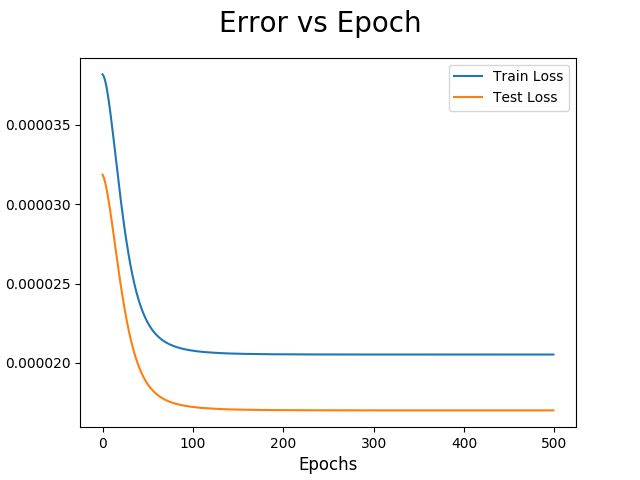

<IPython.core.display.Javascript object>


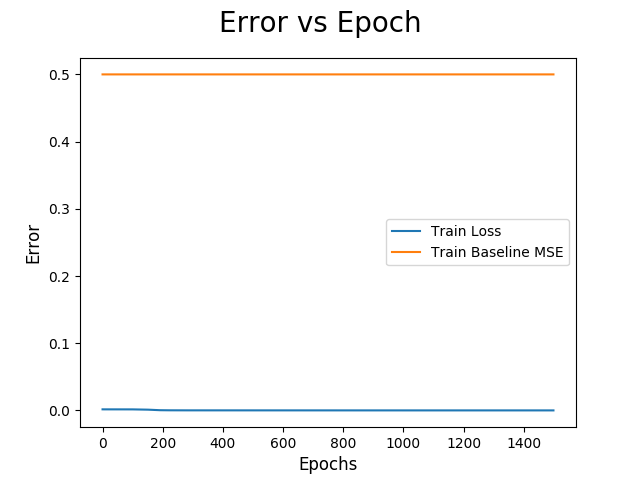

<IPython.core.display.Javascript object>


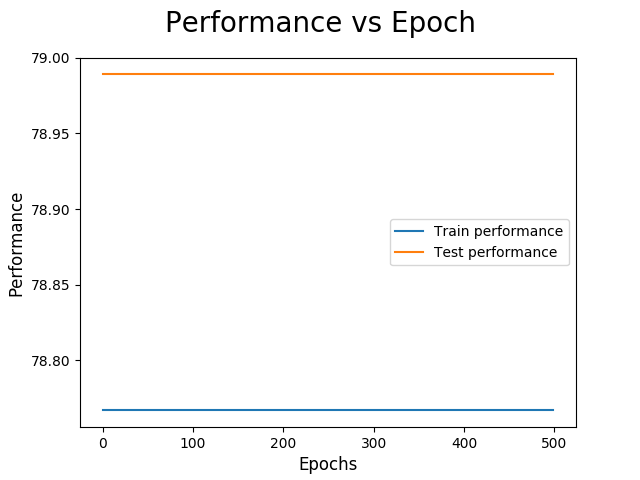

<IPython.core.display.Javascript object>


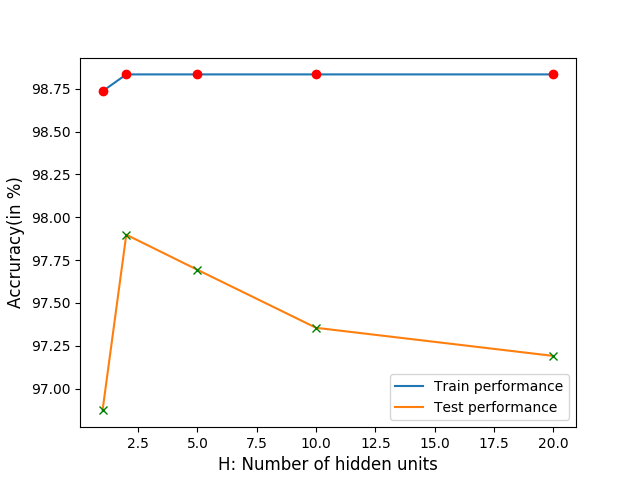

In [734]:
fig5 = plt.figure()
plt.plot(epochs_arr_1a,train_arr_1fa,label="Train Loss")
plt.plot(epochs_arr_1a,test_arr_1fa,label="Test Loss")
plt.legend()
fig5.suptitle('Error vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)

fig6 = plt.figure()
plt.plot(epochs_arr_1c,train_arr_1fc,label="Train Loss")
plt.plot(epochs_arr_1c,[train_baseline_MSE for i in range(len(epochs_arr_1c))],label="Train Baseline MSE")
plt.legend()
fig6.suptitle('Error vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)

fig7 = plt.figure()
plt.plot(epochs_arr_1d,train_acc_1fd,label="Train performance")
plt.plot(epochs_arr_1d,test_acc_1fd,label="Test performance")
plt.legend()
fig7.suptitle('Performance vs Epoch', fontsize=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Performance', fontsize=12)

fig8 = plt.figure()
plt.plot(H,train_acc_1fe,label="Train performance")
plt.plot(H,test_acc_1fe,label="Test performance")
plt.legend()
plt.plot(H,train_acc_1fe,'ro')
plt.plot(H,test_acc_1fe,'gx')
fig4.suptitle('Classificatoin Accuracy vs H', fontsize=20)
plt.xlabel('H: Number of hidden units', fontsize=12)
plt.ylabel('Accruracy(in %)', fontsize=12)

## Ques 1g

In [760]:
class Net2d(nn.Module):
    def __init__(self, h1, h2):
        super(Net2d, self).__init__()
        self.fc1 = nn.Linear(5, h1)
#         nn.init.xavier_normal(self.fc1.weight.data)
        self.fc2 = nn.Linear(h1, h2)
#         nn.init.xavier_normal(self.fc2.weight.data)
        self.fc3 = nn.Linear(h2, 1)
    
    def forward(self, x):
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        x=F.sigmoid(self.fc3(x))
        return x

In [761]:
def ques_1g(epochs):
    train_arr = []
    test_arr = []
    train_acc = []
    test_acc = []
    
    train_loader_1c, test_loader_1c = get_loader(100, 100)
    
    h1 = [2, 3, 5, 10]
    h2 = [1, 2, 3, 5]
    
    for i in range(4):
        m = Net2d(h1[i], h2[i])
        if(use_cuda):
            m = m.cuda()
    
        optimizer = optim.Adam(m.parameters(), lr = 0.001)
            
        criterion = F.binary_cross_entropy
            
        for epoch in range(epochs):
            print('Epoch # {}'.format(epoch))
#             scheduler.step()
            train_loss, train_c = train(m, 
                                              train_loader_1c, optimizer, criterion)
            test_loss, test_c = test(m, 
                                           test_loader_1c, optimizer, criterion)
        if(epoch == epochs-1):
            train_arr.append([train_loss])
            test_arr.append([test_loss])
            train_acc.append([(100.0*train_c)/len(train_loader.dataset)])
            test_acc.append([(100.0*test_c)/len(test_loader.dataset)])
    return train_arr, test_arr, train_acc, test_acc
    

In [765]:
epochs_1g = 1500
epochs_arr_1g = [i for i in range(epochs_1g)]
train_arr_1g, test_arr_1g, train_acc_1g, test_acc_1g =  ques_1g(epochs_1g)

train_acc_1e = np.array(train_acc_1e).flatten()
test_acc_1e = np.array(test_acc_1e).flatten()

Epoch # 0
==>> batch index: 82, train loss: 1.280656, accuracy: 78.767
==>> batch index: 98, test loss: 1.229697, accuracy: 78.989
Epoch # 1
==>> batch index: 82, train loss: 1.213416, accuracy: 78.767
==>> batch index: 98, test loss: 1.166938, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 1.155320, accuracy: 78.767
==>> batch index: 98, test loss: 1.114606, accuracy: 78.989
Epoch # 3
==>> batch index: 82, train loss: 1.107825, accuracy: 78.767
==>> batch index: 98, test loss: 1.072222, accuracy: 78.989
Epoch # 4
==>> batch index: 82, train loss: 1.070842, accuracy: 78.767
==>> batch index: 98, test loss: 1.040012, accuracy: 78.989
Epoch # 5
==>> batch index: 82, train loss: 1.043724, accuracy: 78.767
==>> batch index: 98, test loss: 1.015794, accuracy: 78.989
Epoch # 6
==>> batch index: 82, train loss: 1.023346, accuracy: 78.767
==>> batch index: 98, test loss: 0.999332, accuracy: 78.989
Epoch # 7
==>> batch index: 82, train loss: 1.010664, accuracy: 78.767
==>> batch i

==>> batch index: 82, train loss: 0.976835, accuracy: 78.767
==>> batch index: 98, test loss: 0.962784, accuracy: 78.989
Epoch # 64
==>> batch index: 82, train loss: 0.976020, accuracy: 78.767
==>> batch index: 98, test loss: 0.961354, accuracy: 78.989
Epoch # 65
==>> batch index: 82, train loss: 0.974055, accuracy: 78.767
==>> batch index: 98, test loss: 0.962452, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.976783, accuracy: 78.767
==>> batch index: 98, test loss: 0.962547, accuracy: 78.989
Epoch # 67
==>> batch index: 82, train loss: 0.975133, accuracy: 78.767
==>> batch index: 98, test loss: 0.961755, accuracy: 78.989
Epoch # 68
==>> batch index: 82, train loss: 0.975463, accuracy: 78.767
==>> batch index: 98, test loss: 0.960702, accuracy: 78.989
Epoch # 69
==>> batch index: 82, train loss: 0.972560, accuracy: 78.767
==>> batch index: 98, test loss: 0.959896, accuracy: 78.989
Epoch # 70
==>> batch index: 82, train loss: 0.972102, accuracy: 78.767
==>> batch inde

==>> batch index: 82, train loss: 0.864290, accuracy: 78.767
==>> batch index: 98, test loss: 0.879716, accuracy: 78.989
Epoch # 127
==>> batch index: 82, train loss: 0.862230, accuracy: 78.767
==>> batch index: 98, test loss: 0.876987, accuracy: 78.989
Epoch # 128
==>> batch index: 82, train loss: 0.856274, accuracy: 78.767
==>> batch index: 98, test loss: 0.871463, accuracy: 78.989
Epoch # 129
==>> batch index: 82, train loss: 0.852576, accuracy: 78.767
==>> batch index: 98, test loss: 0.869279, accuracy: 78.989
Epoch # 130
==>> batch index: 82, train loss: 0.845808, accuracy: 78.767
==>> batch index: 98, test loss: 0.864858, accuracy: 78.989
Epoch # 131
==>> batch index: 82, train loss: 0.842358, accuracy: 78.767
==>> batch index: 98, test loss: 0.861295, accuracy: 78.989
Epoch # 132
==>> batch index: 82, train loss: 0.836445, accuracy: 78.767
==>> batch index: 98, test loss: 0.855772, accuracy: 78.989
Epoch # 133
==>> batch index: 82, train loss: 0.830033, accuracy: 78.767
==>> bat

==>> batch index: 82, train loss: 0.404560, accuracy: 93.221
==>> batch index: 98, test loss: 0.498635, accuracy: 84.352
Epoch # 190
==>> batch index: 82, train loss: 0.399188, accuracy: 93.909
==>> batch index: 98, test loss: 0.493507, accuracy: 84.352
Epoch # 191
==>> batch index: 82, train loss: 0.391540, accuracy: 94.376
==>> batch index: 98, test loss: 0.486013, accuracy: 84.516
Epoch # 192
==>> batch index: 82, train loss: 0.385480, accuracy: 94.793
==>> batch index: 98, test loss: 0.480380, accuracy: 84.639
Epoch # 193
==>> batch index: 82, train loss: 0.379053, accuracy: 95.088
==>> batch index: 98, test loss: 0.475861, accuracy: 84.567
Epoch # 194
==>> batch index: 82, train loss: 0.371235, accuracy: 95.174
==>> batch index: 98, test loss: 0.468015, accuracy: 85.039
Epoch # 195
==>> batch index: 82, train loss: 0.365486, accuracy: 95.567
==>> batch index: 98, test loss: 0.461257, accuracy: 85.644
Epoch # 196
==>> batch index: 82, train loss: 0.359401, accuracy: 95.923
==>> bat

==>> batch index: 82, train loss: 0.166903, accuracy: 98.539
==>> batch index: 98, test loss: 0.239274, accuracy: 95.755
Epoch # 252
==>> batch index: 82, train loss: 0.165271, accuracy: 98.526
==>> batch index: 98, test loss: 0.239267, accuracy: 95.662
Epoch # 253
==>> batch index: 82, train loss: 0.164548, accuracy: 98.551
==>> batch index: 98, test loss: 0.242813, accuracy: 95.263
Epoch # 254
==>> batch index: 82, train loss: 0.162004, accuracy: 98.551
==>> batch index: 98, test loss: 0.234436, accuracy: 95.785
Epoch # 255
==>> batch index: 82, train loss: 0.160891, accuracy: 98.600
==>> batch index: 98, test loss: 0.236542, accuracy: 95.560
Epoch # 256
==>> batch index: 82, train loss: 0.159337, accuracy: 98.539
==>> batch index: 98, test loss: 0.226829, accuracy: 95.950
Epoch # 257
==>> batch index: 82, train loss: 0.158277, accuracy: 98.526
==>> batch index: 98, test loss: 0.226091, accuracy: 95.939
Epoch # 258
==>> batch index: 82, train loss: 0.156638, accuracy: 98.600
==>> bat

==>> batch index: 82, train loss: 0.121554, accuracy: 98.760
==>> batch index: 98, test loss: 0.174477, accuracy: 96.462
Epoch # 314
==>> batch index: 82, train loss: 0.119746, accuracy: 98.772
==>> batch index: 98, test loss: 0.174628, accuracy: 96.329
Epoch # 315
==>> batch index: 82, train loss: 0.119423, accuracy: 98.784
==>> batch index: 98, test loss: 0.172691, accuracy: 96.596
Epoch # 316
==>> batch index: 82, train loss: 0.118955, accuracy: 98.760
==>> batch index: 98, test loss: 0.170652, accuracy: 96.678
Epoch # 317
==>> batch index: 82, train loss: 0.119581, accuracy: 98.784
==>> batch index: 98, test loss: 0.171418, accuracy: 96.616
Epoch # 318
==>> batch index: 82, train loss: 0.118586, accuracy: 98.797
==>> batch index: 98, test loss: 0.170320, accuracy: 96.637
Epoch # 319
==>> batch index: 82, train loss: 0.118096, accuracy: 98.772
==>> batch index: 98, test loss: 0.170375, accuracy: 96.606
Epoch # 320
==>> batch index: 82, train loss: 0.118151, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.110812, accuracy: 98.821
==>> batch index: 98, test loss: 0.159206, accuracy: 96.667
Epoch # 376
==>> batch index: 82, train loss: 0.109872, accuracy: 98.809
==>> batch index: 98, test loss: 0.158488, accuracy: 96.678
Epoch # 377
==>> batch index: 82, train loss: 0.109730, accuracy: 98.809
==>> batch index: 98, test loss: 0.161670, accuracy: 96.473
Epoch # 378
==>> batch index: 82, train loss: 0.110510, accuracy: 98.809
==>> batch index: 98, test loss: 0.161146, accuracy: 96.503
Epoch # 379
==>> batch index: 82, train loss: 0.109955, accuracy: 98.797
==>> batch index: 98, test loss: 0.151140, accuracy: 97.190
Epoch # 380
==>> batch index: 82, train loss: 0.109421, accuracy: 98.821
==>> batch index: 98, test loss: 0.162048, accuracy: 96.380
Epoch # 381
==>> batch index: 82, train loss: 0.109704, accuracy: 98.809
==>> batch index: 98, test loss: 0.162908, accuracy: 96.288
Epoch # 382
==>> batch index: 82, train loss: 0.110574, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.106592, accuracy: 98.821
==>> batch index: 98, test loss: 0.155641, accuracy: 96.585
Epoch # 438
==>> batch index: 82, train loss: 0.107387, accuracy: 98.797
==>> batch index: 98, test loss: 0.146499, accuracy: 97.221
Epoch # 439
==>> batch index: 82, train loss: 0.106745, accuracy: 98.821
==>> batch index: 98, test loss: 0.152159, accuracy: 96.862
Epoch # 440
==>> batch index: 82, train loss: 0.107452, accuracy: 98.821
==>> batch index: 98, test loss: 0.148464, accuracy: 97.129
Epoch # 441
==>> batch index: 82, train loss: 0.107247, accuracy: 98.821
==>> batch index: 98, test loss: 0.151466, accuracy: 96.934
Epoch # 442
==>> batch index: 82, train loss: 0.108155, accuracy: 98.821
==>> batch index: 98, test loss: 0.152341, accuracy: 96.872
Epoch # 443
==>> batch index: 82, train loss: 0.106347, accuracy: 98.809
==>> batch index: 98, test loss: 0.151771, accuracy: 96.903
Epoch # 444
==>> batch index: 82, train loss: 0.107408, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.106053, accuracy: 98.809
==>> batch index: 98, test loss: 0.145423, accuracy: 97.170
Epoch # 500
==>> batch index: 82, train loss: 0.104824, accuracy: 98.833
==>> batch index: 98, test loss: 0.155226, accuracy: 96.534
Epoch # 501
==>> batch index: 82, train loss: 0.105762, accuracy: 98.821
==>> batch index: 98, test loss: 0.148944, accuracy: 97.006
Epoch # 502
==>> batch index: 82, train loss: 0.104624, accuracy: 98.821
==>> batch index: 98, test loss: 0.151100, accuracy: 96.903
Epoch # 503
==>> batch index: 82, train loss: 0.105744, accuracy: 98.809
==>> batch index: 98, test loss: 0.145224, accuracy: 97.180
Epoch # 504
==>> batch index: 82, train loss: 0.106950, accuracy: 98.821
==>> batch index: 98, test loss: 0.143801, accuracy: 97.242
Epoch # 505
==>> batch index: 82, train loss: 0.104620, accuracy: 98.809
==>> batch index: 98, test loss: 0.144502, accuracy: 97.231
Epoch # 506
==>> batch index: 82, train loss: 0.105916, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.103529, accuracy: 98.821
==>> batch index: 98, test loss: 0.145756, accuracy: 97.139
Epoch # 563
==>> batch index: 82, train loss: 0.103362, accuracy: 98.821
==>> batch index: 98, test loss: 0.145011, accuracy: 97.170
Epoch # 564
==>> batch index: 82, train loss: 0.103369, accuracy: 98.821
==>> batch index: 98, test loss: 0.144072, accuracy: 97.211
Epoch # 565
==>> batch index: 82, train loss: 0.104467, accuracy: 98.821
==>> batch index: 98, test loss: 0.150633, accuracy: 96.903
Epoch # 566
==>> batch index: 82, train loss: 0.103514, accuracy: 98.821
==>> batch index: 98, test loss: 0.147256, accuracy: 97.108
Epoch # 567
==>> batch index: 82, train loss: 0.103885, accuracy: 98.821
==>> batch index: 98, test loss: 0.141814, accuracy: 97.272
Epoch # 568
==>> batch index: 82, train loss: 0.103505, accuracy: 98.821
==>> batch index: 98, test loss: 0.138393, accuracy: 97.426
Epoch # 569
==>> batch index: 82, train loss: 0.104656, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.102777, accuracy: 98.821
==>> batch index: 98, test loss: 0.146475, accuracy: 97.108
Epoch # 625
==>> batch index: 82, train loss: 0.102571, accuracy: 98.821
==>> batch index: 98, test loss: 0.143944, accuracy: 97.201
Epoch # 626
==>> batch index: 82, train loss: 0.102648, accuracy: 98.821
==>> batch index: 98, test loss: 0.149882, accuracy: 96.954
Epoch # 627
==>> batch index: 82, train loss: 0.103277, accuracy: 98.821
==>> batch index: 98, test loss: 0.147945, accuracy: 97.047
Epoch # 628
==>> batch index: 82, train loss: 0.102359, accuracy: 98.821
==>> batch index: 98, test loss: 0.140708, accuracy: 97.365
Epoch # 629
==>> batch index: 82, train loss: 0.103627, accuracy: 98.821
==>> batch index: 98, test loss: 0.138072, accuracy: 97.406
Epoch # 630
==>> batch index: 82, train loss: 0.102278, accuracy: 98.821
==>> batch index: 98, test loss: 0.148183, accuracy: 97.047
Epoch # 631
==>> batch index: 82, train loss: 0.102340, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.102426, accuracy: 98.833
==>> batch index: 98, test loss: 0.144512, accuracy: 97.149
Epoch # 688
==>> batch index: 82, train loss: 0.101788, accuracy: 98.821
==>> batch index: 98, test loss: 0.140728, accuracy: 97.313
Epoch # 689
==>> batch index: 82, train loss: 0.101769, accuracy: 98.821
==>> batch index: 98, test loss: 0.145703, accuracy: 97.129
Epoch # 690
==>> batch index: 82, train loss: 0.101517, accuracy: 98.821
==>> batch index: 98, test loss: 0.141835, accuracy: 97.221
Epoch # 691
==>> batch index: 82, train loss: 0.101998, accuracy: 98.821
==>> batch index: 98, test loss: 0.142735, accuracy: 97.221
Epoch # 692
==>> batch index: 82, train loss: 0.101770, accuracy: 98.821
==>> batch index: 98, test loss: 0.144286, accuracy: 97.160
Epoch # 693
==>> batch index: 82, train loss: 0.101580, accuracy: 98.821
==>> batch index: 98, test loss: 0.142111, accuracy: 97.231
Epoch # 694
==>> batch index: 82, train loss: 0.102600, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.100977, accuracy: 98.821
==>> batch index: 98, test loss: 0.149507, accuracy: 97.026
Epoch # 750
==>> batch index: 82, train loss: 0.104296, accuracy: 98.821
==>> batch index: 98, test loss: 0.136819, accuracy: 97.508
Epoch # 751
==>> batch index: 82, train loss: 0.100952, accuracy: 98.821
==>> batch index: 98, test loss: 0.138978, accuracy: 97.354
Epoch # 752
==>> batch index: 82, train loss: 0.100890, accuracy: 98.821
==>> batch index: 98, test loss: 0.139173, accuracy: 97.375
Epoch # 753
==>> batch index: 82, train loss: 0.101978, accuracy: 98.821
==>> batch index: 98, test loss: 0.143350, accuracy: 97.190
Epoch # 754
==>> batch index: 82, train loss: 0.101839, accuracy: 98.821
==>> batch index: 98, test loss: 0.140538, accuracy: 97.262
Epoch # 755
==>> batch index: 82, train loss: 0.101492, accuracy: 98.821
==>> batch index: 98, test loss: 0.140131, accuracy: 97.334
Epoch # 756
==>> batch index: 82, train loss: 0.102914, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.100174, accuracy: 98.821
==>> batch index: 98, test loss: 0.138954, accuracy: 97.375
Epoch # 812
==>> batch index: 82, train loss: 0.102449, accuracy: 98.821
==>> batch index: 98, test loss: 0.139382, accuracy: 97.334
Epoch # 813
==>> batch index: 82, train loss: 0.101236, accuracy: 98.821
==>> batch index: 98, test loss: 0.143005, accuracy: 97.190
Epoch # 814
==>> batch index: 82, train loss: 0.100140, accuracy: 98.821
==>> batch index: 98, test loss: 0.146421, accuracy: 97.119
Epoch # 815
==>> batch index: 82, train loss: 0.102556, accuracy: 98.821
==>> batch index: 98, test loss: 0.151659, accuracy: 96.770
Epoch # 816
==>> batch index: 82, train loss: 0.100254, accuracy: 98.821
==>> batch index: 98, test loss: 0.142722, accuracy: 97.190
Epoch # 817
==>> batch index: 82, train loss: 0.100068, accuracy: 98.821
==>> batch index: 98, test loss: 0.133970, accuracy: 97.662
Epoch # 818
==>> batch index: 82, train loss: 0.101386, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.099538, accuracy: 98.821
==>> batch index: 98, test loss: 0.135718, accuracy: 97.488
Epoch # 874
==>> batch index: 82, train loss: 0.101606, accuracy: 98.821
==>> batch index: 98, test loss: 0.135193, accuracy: 97.529
Epoch # 875
==>> batch index: 82, train loss: 0.100869, accuracy: 98.821
==>> batch index: 98, test loss: 0.137198, accuracy: 97.395
Epoch # 876
==>> batch index: 82, train loss: 0.099511, accuracy: 98.833
==>> batch index: 98, test loss: 0.133659, accuracy: 97.652
Epoch # 877
==>> batch index: 82, train loss: 0.099602, accuracy: 98.821
==>> batch index: 98, test loss: 0.135997, accuracy: 97.488
Epoch # 878
==>> batch index: 82, train loss: 0.099542, accuracy: 98.833
==>> batch index: 98, test loss: 0.137961, accuracy: 97.426
Epoch # 879
==>> batch index: 82, train loss: 0.099586, accuracy: 98.821
==>> batch index: 98, test loss: 0.138034, accuracy: 97.375
Epoch # 880
==>> batch index: 82, train loss: 0.099667, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.099145, accuracy: 98.821
==>> batch index: 98, test loss: 0.136052, accuracy: 97.477
Epoch # 936
==>> batch index: 82, train loss: 0.099445, accuracy: 98.833
==>> batch index: 98, test loss: 0.135472, accuracy: 97.477
Epoch # 937
==>> batch index: 82, train loss: 0.098927, accuracy: 98.821
==>> batch index: 98, test loss: 0.139271, accuracy: 97.303
Epoch # 938
==>> batch index: 82, train loss: 0.100468, accuracy: 98.821
==>> batch index: 98, test loss: 0.135761, accuracy: 97.416
Epoch # 939
==>> batch index: 82, train loss: 0.100257, accuracy: 98.821
==>> batch index: 98, test loss: 0.134109, accuracy: 97.600
Epoch # 940
==>> batch index: 82, train loss: 0.099899, accuracy: 98.821
==>> batch index: 98, test loss: 0.135991, accuracy: 97.447
Epoch # 941
==>> batch index: 82, train loss: 0.099010, accuracy: 98.821
==>> batch index: 98, test loss: 0.137095, accuracy: 97.406
Epoch # 942
==>> batch index: 82, train loss: 0.100080, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.098617, accuracy: 98.833
==>> batch index: 98, test loss: 0.141551, accuracy: 97.211
Epoch # 998
==>> batch index: 82, train loss: 0.099392, accuracy: 98.821
==>> batch index: 98, test loss: 0.138208, accuracy: 97.354
Epoch # 999
==>> batch index: 82, train loss: 0.100612, accuracy: 98.821
==>> batch index: 98, test loss: 0.130843, accuracy: 97.888
Epoch # 1000
==>> batch index: 82, train loss: 0.098457, accuracy: 98.821
==>> batch index: 98, test loss: 0.134956, accuracy: 97.508
Epoch # 1001
==>> batch index: 82, train loss: 0.098399, accuracy: 98.833
==>> batch index: 98, test loss: 0.137925, accuracy: 97.354
Epoch # 1002
==>> batch index: 82, train loss: 0.098454, accuracy: 98.821
==>> batch index: 98, test loss: 0.135906, accuracy: 97.426
Epoch # 1003
==>> batch index: 82, train loss: 0.098430, accuracy: 98.833
==>> batch index: 98, test loss: 0.141266, accuracy: 97.231
Epoch # 1004
==>> batch index: 82, train loss: 0.098517, accuracy: 98.821
==>

==>> batch index: 82, train loss: 0.098910, accuracy: 98.821
==>> batch index: 98, test loss: 0.131130, accuracy: 97.806
Epoch # 1060
==>> batch index: 82, train loss: 0.098857, accuracy: 98.821
==>> batch index: 98, test loss: 0.135294, accuracy: 97.436
Epoch # 1061
==>> batch index: 82, train loss: 0.097978, accuracy: 98.821
==>> batch index: 98, test loss: 0.133131, accuracy: 97.580
Epoch # 1062
==>> batch index: 82, train loss: 0.099201, accuracy: 98.821
==>> batch index: 98, test loss: 0.133798, accuracy: 97.580
Epoch # 1063
==>> batch index: 82, train loss: 0.099256, accuracy: 98.821
==>> batch index: 98, test loss: 0.131561, accuracy: 97.806
Epoch # 1064
==>> batch index: 82, train loss: 0.097985, accuracy: 98.821
==>> batch index: 98, test loss: 0.134148, accuracy: 97.539
Epoch # 1065
==>> batch index: 82, train loss: 0.099113, accuracy: 98.833
==>> batch index: 98, test loss: 0.138733, accuracy: 97.334
Epoch # 1066
==>> batch index: 82, train loss: 0.099144, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.097497, accuracy: 98.821
==>> batch index: 98, test loss: 0.138130, accuracy: 97.334
Epoch # 1123
==>> batch index: 82, train loss: 0.098648, accuracy: 98.833
==>> batch index: 98, test loss: 0.132854, accuracy: 97.600
Epoch # 1124
==>> batch index: 82, train loss: 0.098908, accuracy: 98.821
==>> batch index: 98, test loss: 0.134549, accuracy: 97.498
Epoch # 1125
==>> batch index: 82, train loss: 0.097454, accuracy: 98.821
==>> batch index: 98, test loss: 0.136782, accuracy: 97.426
Epoch # 1126
==>> batch index: 82, train loss: 0.097620, accuracy: 98.821
==>> batch index: 98, test loss: 0.128101, accuracy: 97.990
Epoch # 1127
==>> batch index: 82, train loss: 0.097508, accuracy: 98.833
==>> batch index: 98, test loss: 0.131292, accuracy: 97.826
Epoch # 1128
==>> batch index: 82, train loss: 0.097468, accuracy: 98.833
==>> batch index: 98, test loss: 0.129560, accuracy: 97.898
Epoch # 1129
==>> batch index: 82, train loss: 0.098362, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.097105, accuracy: 98.833
==>> batch index: 98, test loss: 0.131308, accuracy: 97.785
Epoch # 1185
==>> batch index: 82, train loss: 0.097068, accuracy: 98.833
==>> batch index: 98, test loss: 0.134268, accuracy: 97.498
Epoch # 1186
==>> batch index: 82, train loss: 0.098374, accuracy: 98.833
==>> batch index: 98, test loss: 0.136075, accuracy: 97.416
Epoch # 1187
==>> batch index: 82, train loss: 0.098130, accuracy: 98.833
==>> batch index: 98, test loss: 0.136265, accuracy: 97.416
Epoch # 1188
==>> batch index: 82, train loss: 0.097182, accuracy: 98.821
==>> batch index: 98, test loss: 0.134711, accuracy: 97.498
Epoch # 1189
==>> batch index: 82, train loss: 0.097175, accuracy: 98.833
==>> batch index: 98, test loss: 0.129699, accuracy: 97.877
Epoch # 1190
==>> batch index: 82, train loss: 0.098098, accuracy: 98.833
==>> batch index: 98, test loss: 0.132491, accuracy: 97.734
Epoch # 1191
==>> batch index: 82, train loss: 0.098307, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.096678, accuracy: 98.821
==>> batch index: 98, test loss: 0.130124, accuracy: 97.857
Epoch # 1247
==>> batch index: 82, train loss: 0.096810, accuracy: 98.821
==>> batch index: 98, test loss: 0.137936, accuracy: 97.375
Epoch # 1248
==>> batch index: 82, train loss: 0.096733, accuracy: 98.821
==>> batch index: 98, test loss: 0.134960, accuracy: 97.467
Epoch # 1249
==>> batch index: 82, train loss: 0.097885, accuracy: 98.821
==>> batch index: 98, test loss: 0.132266, accuracy: 97.765
Epoch # 1250
==>> batch index: 82, train loss: 0.097008, accuracy: 98.821
==>> batch index: 98, test loss: 0.136181, accuracy: 97.416
Epoch # 1251
==>> batch index: 82, train loss: 0.096938, accuracy: 98.821
==>> batch index: 98, test loss: 0.128718, accuracy: 97.929
Epoch # 1252
==>> batch index: 82, train loss: 0.097917, accuracy: 98.833
==>> batch index: 98, test loss: 0.126886, accuracy: 98.021
Epoch # 1253
==>> batch index: 82, train loss: 0.097069, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.096363, accuracy: 98.821
==>> batch index: 98, test loss: 0.131790, accuracy: 97.754
Epoch # 1309
==>> batch index: 82, train loss: 0.096412, accuracy: 98.821
==>> batch index: 98, test loss: 0.132406, accuracy: 97.703
Epoch # 1310
==>> batch index: 82, train loss: 0.096599, accuracy: 98.821
==>> batch index: 98, test loss: 0.127594, accuracy: 97.980
Epoch # 1311
==>> batch index: 82, train loss: 0.096641, accuracy: 98.821
==>> batch index: 98, test loss: 0.128448, accuracy: 97.918
Epoch # 1312
==>> batch index: 82, train loss: 0.097558, accuracy: 98.833
==>> batch index: 98, test loss: 0.134342, accuracy: 97.488
Epoch # 1313
==>> batch index: 82, train loss: 0.096349, accuracy: 98.821
==>> batch index: 98, test loss: 0.131206, accuracy: 97.806
Epoch # 1314
==>> batch index: 82, train loss: 0.096337, accuracy: 98.821
==>> batch index: 98, test loss: 0.130865, accuracy: 97.826
Epoch # 1315
==>> batch index: 82, train loss: 0.096253, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.096020, accuracy: 98.833
==>> batch index: 98, test loss: 0.131803, accuracy: 97.765
Epoch # 1372
==>> batch index: 82, train loss: 0.096119, accuracy: 98.821
==>> batch index: 98, test loss: 0.133403, accuracy: 97.549
Epoch # 1373
==>> batch index: 82, train loss: 0.096245, accuracy: 98.833
==>> batch index: 98, test loss: 0.131064, accuracy: 97.795
Epoch # 1374
==>> batch index: 82, train loss: 0.096039, accuracy: 98.833
==>> batch index: 98, test loss: 0.133601, accuracy: 97.600
Epoch # 1375
==>> batch index: 82, train loss: 0.096108, accuracy: 98.821
==>> batch index: 98, test loss: 0.134485, accuracy: 97.467
Epoch # 1376
==>> batch index: 82, train loss: 0.096024, accuracy: 98.821
==>> batch index: 98, test loss: 0.131372, accuracy: 97.816
Epoch # 1377
==>> batch index: 82, train loss: 0.096125, accuracy: 98.833
==>> batch index: 98, test loss: 0.128365, accuracy: 97.980
Epoch # 1378
==>> batch index: 82, train loss: 0.095916, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.095706, accuracy: 98.833
==>> batch index: 98, test loss: 0.133531, accuracy: 97.580
Epoch # 1434
==>> batch index: 82, train loss: 0.097873, accuracy: 98.833
==>> batch index: 98, test loss: 0.129264, accuracy: 97.877
Epoch # 1435
==>> batch index: 82, train loss: 0.095743, accuracy: 98.821
==>> batch index: 98, test loss: 0.128075, accuracy: 97.918
Epoch # 1436
==>> batch index: 82, train loss: 0.095812, accuracy: 98.821
==>> batch index: 98, test loss: 0.126913, accuracy: 98.000
Epoch # 1437
==>> batch index: 82, train loss: 0.097759, accuracy: 98.833
==>> batch index: 98, test loss: 0.129259, accuracy: 97.877
Epoch # 1438
==>> batch index: 82, train loss: 0.095628, accuracy: 98.833
==>> batch index: 98, test loss: 0.129585, accuracy: 97.867
Epoch # 1439
==>> batch index: 82, train loss: 0.096809, accuracy: 98.821
==>> batch index: 98, test loss: 0.125110, accuracy: 98.113
Epoch # 1440
==>> batch index: 82, train loss: 0.095848, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.095368, accuracy: 98.821
==>> batch index: 98, test loss: 0.124361, accuracy: 98.134
Epoch # 1496
==>> batch index: 82, train loss: 0.095659, accuracy: 98.833
==>> batch index: 98, test loss: 0.123326, accuracy: 98.267
Epoch # 1497
==>> batch index: 82, train loss: 0.095549, accuracy: 98.833
==>> batch index: 98, test loss: 0.125847, accuracy: 98.052
Epoch # 1498
==>> batch index: 82, train loss: 0.097449, accuracy: 98.821
==>> batch index: 98, test loss: 0.123793, accuracy: 98.134
Epoch # 1499
==>> batch index: 82, train loss: 0.095416, accuracy: 98.833
==>> batch index: 98, test loss: 0.125125, accuracy: 98.093
Epoch # 0
==>> batch index: 82, train loss: 1.423869, accuracy: 21.233
==>> batch index: 98, test loss: 1.349215, accuracy: 21.011
Epoch # 1
==>> batch index: 82, train loss: 1.314466, accuracy: 54.108
==>> batch index: 98, test loss: 1.250785, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 1.224702, accuracy: 78.767
==>> batch

==>> batch index: 82, train loss: 0.979501, accuracy: 78.767
==>> batch index: 98, test loss: 0.964430, accuracy: 78.989
Epoch # 60
==>> batch index: 82, train loss: 0.977081, accuracy: 78.767
==>> batch index: 98, test loss: 0.964144, accuracy: 78.989
Epoch # 61
==>> batch index: 82, train loss: 0.979108, accuracy: 78.767
==>> batch index: 98, test loss: 0.962700, accuracy: 78.989
Epoch # 62
==>> batch index: 82, train loss: 0.978022, accuracy: 78.767
==>> batch index: 98, test loss: 0.961990, accuracy: 78.989
Epoch # 63
==>> batch index: 82, train loss: 0.975928, accuracy: 78.767
==>> batch index: 98, test loss: 0.961904, accuracy: 78.989
Epoch # 64
==>> batch index: 82, train loss: 0.977893, accuracy: 78.767
==>> batch index: 98, test loss: 0.962256, accuracy: 78.989
Epoch # 65
==>> batch index: 82, train loss: 0.977762, accuracy: 78.767
==>> batch index: 98, test loss: 0.962336, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.975739, accuracy: 78.767
==>> batch inde

==>> batch index: 82, train loss: 0.823955, accuracy: 78.767
==>> batch index: 98, test loss: 0.846843, accuracy: 78.989
Epoch # 123
==>> batch index: 82, train loss: 0.819545, accuracy: 78.767
==>> batch index: 98, test loss: 0.841106, accuracy: 78.989
Epoch # 124
==>> batch index: 82, train loss: 0.809884, accuracy: 78.767
==>> batch index: 98, test loss: 0.836407, accuracy: 78.989
Epoch # 125
==>> batch index: 82, train loss: 0.802532, accuracy: 78.767
==>> batch index: 98, test loss: 0.828388, accuracy: 78.989
Epoch # 126
==>> batch index: 82, train loss: 0.797243, accuracy: 78.767
==>> batch index: 98, test loss: 0.824167, accuracy: 78.989
Epoch # 127
==>> batch index: 82, train loss: 0.786876, accuracy: 78.767
==>> batch index: 98, test loss: 0.816950, accuracy: 78.989
Epoch # 128
==>> batch index: 82, train loss: 0.779832, accuracy: 78.767
==>> batch index: 98, test loss: 0.811631, accuracy: 78.989
Epoch # 129
==>> batch index: 82, train loss: 0.770125, accuracy: 78.767
==>> bat

==>> batch index: 82, train loss: 0.261190, accuracy: 97.409
==>> batch index: 98, test loss: 0.358502, accuracy: 88.013
Epoch # 185
==>> batch index: 82, train loss: 0.256190, accuracy: 97.409
==>> batch index: 98, test loss: 0.351868, accuracy: 88.556
Epoch # 186
==>> batch index: 82, train loss: 0.251418, accuracy: 97.483
==>> batch index: 98, test loss: 0.342744, accuracy: 90.597
Epoch # 187
==>> batch index: 82, train loss: 0.246267, accuracy: 97.654
==>> batch index: 98, test loss: 0.336737, accuracy: 91.479
Epoch # 188
==>> batch index: 82, train loss: 0.240865, accuracy: 97.790
==>> batch index: 98, test loss: 0.332641, accuracy: 91.735
Epoch # 189
==>> batch index: 82, train loss: 0.237886, accuracy: 97.826
==>> batch index: 98, test loss: 0.321599, accuracy: 93.622
Epoch # 190
==>> batch index: 82, train loss: 0.232451, accuracy: 97.839
==>> batch index: 98, test loss: 0.323115, accuracy: 92.637
Epoch # 191
==>> batch index: 82, train loss: 0.227947, accuracy: 97.961
==>> bat

==>> batch index: 82, train loss: 0.129673, accuracy: 98.674
==>> batch index: 98, test loss: 0.193846, accuracy: 95.970
Epoch # 247
==>> batch index: 82, train loss: 0.128243, accuracy: 98.747
==>> batch index: 98, test loss: 0.187094, accuracy: 96.185
Epoch # 248
==>> batch index: 82, train loss: 0.127444, accuracy: 98.711
==>> batch index: 98, test loss: 0.193680, accuracy: 95.950
Epoch # 249
==>> batch index: 82, train loss: 0.127124, accuracy: 98.698
==>> batch index: 98, test loss: 0.188168, accuracy: 96.073
Epoch # 250
==>> batch index: 82, train loss: 0.126614, accuracy: 98.723
==>> batch index: 98, test loss: 0.188356, accuracy: 96.021
Epoch # 251
==>> batch index: 82, train loss: 0.128967, accuracy: 98.723
==>> batch index: 98, test loss: 0.177395, accuracy: 96.790
Epoch # 252
==>> batch index: 82, train loss: 0.125863, accuracy: 98.698
==>> batch index: 98, test loss: 0.189173, accuracy: 95.991
Epoch # 253
==>> batch index: 82, train loss: 0.124750, accuracy: 98.747
==>> bat

==>> batch index: 82, train loss: 0.112879, accuracy: 98.772
==>> batch index: 98, test loss: 0.164078, accuracy: 96.503
Epoch # 309
==>> batch index: 82, train loss: 0.113150, accuracy: 98.797
==>> batch index: 98, test loss: 0.165207, accuracy: 96.432
Epoch # 310
==>> batch index: 82, train loss: 0.112193, accuracy: 98.784
==>> batch index: 98, test loss: 0.161541, accuracy: 96.667
Epoch # 311
==>> batch index: 82, train loss: 0.112748, accuracy: 98.784
==>> batch index: 98, test loss: 0.152736, accuracy: 97.231
Epoch # 312
==>> batch index: 82, train loss: 0.112357, accuracy: 98.809
==>> batch index: 98, test loss: 0.168195, accuracy: 96.103
Epoch # 313
==>> batch index: 82, train loss: 0.111860, accuracy: 98.821
==>> batch index: 98, test loss: 0.160851, accuracy: 96.647
Epoch # 314
==>> batch index: 82, train loss: 0.111911, accuracy: 98.833
==>> batch index: 98, test loss: 0.164891, accuracy: 96.349
Epoch # 315
==>> batch index: 82, train loss: 0.111579, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.108335, accuracy: 98.833
==>> batch index: 98, test loss: 0.155162, accuracy: 96.801
Epoch # 371
==>> batch index: 82, train loss: 0.108508, accuracy: 98.809
==>> batch index: 98, test loss: 0.149235, accuracy: 97.129
Epoch # 372
==>> batch index: 82, train loss: 0.110184, accuracy: 98.821
==>> batch index: 98, test loss: 0.149479, accuracy: 97.139
Epoch # 373
==>> batch index: 82, train loss: 0.108395, accuracy: 98.821
==>> batch index: 98, test loss: 0.151006, accuracy: 97.098
Epoch # 374
==>> batch index: 82, train loss: 0.109829, accuracy: 98.833
==>> batch index: 98, test loss: 0.149204, accuracy: 97.129
Epoch # 375
==>> batch index: 82, train loss: 0.109589, accuracy: 98.797
==>> batch index: 98, test loss: 0.151226, accuracy: 97.047
Epoch # 376
==>> batch index: 82, train loss: 0.109310, accuracy: 98.821
==>> batch index: 98, test loss: 0.149845, accuracy: 97.098
Epoch # 377
==>> batch index: 82, train loss: 0.108148, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.106879, accuracy: 98.821
==>> batch index: 98, test loss: 0.156420, accuracy: 96.575
Epoch # 433
==>> batch index: 82, train loss: 0.107708, accuracy: 98.821
==>> batch index: 98, test loss: 0.152360, accuracy: 96.913
Epoch # 434
==>> batch index: 82, train loss: 0.106748, accuracy: 98.809
==>> batch index: 98, test loss: 0.159326, accuracy: 96.360
Epoch # 435
==>> batch index: 82, train loss: 0.106472, accuracy: 98.809
==>> batch index: 98, test loss: 0.150882, accuracy: 96.975
Epoch # 436
==>> batch index: 82, train loss: 0.106846, accuracy: 98.809
==>> batch index: 98, test loss: 0.155370, accuracy: 96.606
Epoch # 437
==>> batch index: 82, train loss: 0.106917, accuracy: 98.821
==>> batch index: 98, test loss: 0.152858, accuracy: 96.872
Epoch # 438
==>> batch index: 82, train loss: 0.107831, accuracy: 98.821
==>> batch index: 98, test loss: 0.155392, accuracy: 96.606
Epoch # 439
==>> batch index: 82, train loss: 0.106701, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.105360, accuracy: 98.833
==>> batch index: 98, test loss: 0.152839, accuracy: 96.801
Epoch # 495
==>> batch index: 82, train loss: 0.107242, accuracy: 98.809
==>> batch index: 98, test loss: 0.150102, accuracy: 97.037
Epoch # 496
==>> batch index: 82, train loss: 0.107589, accuracy: 98.821
==>> batch index: 98, test loss: 0.151192, accuracy: 96.954
Epoch # 497
==>> batch index: 82, train loss: 0.106522, accuracy: 98.821
==>> batch index: 98, test loss: 0.145714, accuracy: 97.190
Epoch # 498
==>> batch index: 82, train loss: 0.105504, accuracy: 98.821
==>> batch index: 98, test loss: 0.154294, accuracy: 96.667
Epoch # 499
==>> batch index: 82, train loss: 0.105360, accuracy: 98.809
==>> batch index: 98, test loss: 0.148388, accuracy: 97.139
Epoch # 500
==>> batch index: 82, train loss: 0.105499, accuracy: 98.821
==>> batch index: 98, test loss: 0.164566, accuracy: 96.073
Epoch # 501
==>> batch index: 82, train loss: 0.106030, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.104397, accuracy: 98.821
==>> batch index: 98, test loss: 0.148932, accuracy: 97.078
Epoch # 557
==>> batch index: 82, train loss: 0.104960, accuracy: 98.809
==>> batch index: 98, test loss: 0.143724, accuracy: 97.221
Epoch # 558
==>> batch index: 82, train loss: 0.104399, accuracy: 98.821
==>> batch index: 98, test loss: 0.142693, accuracy: 97.272
Epoch # 559
==>> batch index: 82, train loss: 0.105030, accuracy: 98.821
==>> batch index: 98, test loss: 0.145958, accuracy: 97.180
Epoch # 560
==>> batch index: 82, train loss: 0.104514, accuracy: 98.821
==>> batch index: 98, test loss: 0.151849, accuracy: 96.883
Epoch # 561
==>> batch index: 82, train loss: 0.105510, accuracy: 98.809
==>> batch index: 98, test loss: 0.144065, accuracy: 97.211
Epoch # 562
==>> batch index: 82, train loss: 0.104608, accuracy: 98.809
==>> batch index: 98, test loss: 0.154603, accuracy: 96.678
Epoch # 563
==>> batch index: 82, train loss: 0.105218, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.105242, accuracy: 98.821
==>> batch index: 98, test loss: 0.144405, accuracy: 97.190
Epoch # 619
==>> batch index: 82, train loss: 0.104826, accuracy: 98.821
==>> batch index: 98, test loss: 0.145390, accuracy: 97.190
Epoch # 620
==>> batch index: 82, train loss: 0.104079, accuracy: 98.821
==>> batch index: 98, test loss: 0.149551, accuracy: 97.057
Epoch # 621
==>> batch index: 82, train loss: 0.104780, accuracy: 98.821
==>> batch index: 98, test loss: 0.143407, accuracy: 97.201
Epoch # 622
==>> batch index: 82, train loss: 0.103699, accuracy: 98.821
==>> batch index: 98, test loss: 0.151958, accuracy: 96.924
Epoch # 623
==>> batch index: 82, train loss: 0.104037, accuracy: 98.821
==>> batch index: 98, test loss: 0.149330, accuracy: 97.067
Epoch # 624
==>> batch index: 82, train loss: 0.104467, accuracy: 98.821
==>> batch index: 98, test loss: 0.145345, accuracy: 97.190
Epoch # 625
==>> batch index: 82, train loss: 0.103515, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.103043, accuracy: 98.809
==>> batch index: 98, test loss: 0.136825, accuracy: 97.621
Epoch # 681
==>> batch index: 82, train loss: 0.102955, accuracy: 98.821
==>> batch index: 98, test loss: 0.145480, accuracy: 97.190
Epoch # 682
==>> batch index: 82, train loss: 0.103221, accuracy: 98.821
==>> batch index: 98, test loss: 0.146937, accuracy: 97.139
Epoch # 683
==>> batch index: 82, train loss: 0.103083, accuracy: 98.821
==>> batch index: 98, test loss: 0.145754, accuracy: 97.190
Epoch # 684
==>> batch index: 82, train loss: 0.103051, accuracy: 98.821
==>> batch index: 98, test loss: 0.144777, accuracy: 97.180
Epoch # 685
==>> batch index: 82, train loss: 0.103008, accuracy: 98.821
==>> batch index: 98, test loss: 0.141419, accuracy: 97.354
Epoch # 686
==>> batch index: 82, train loss: 0.102956, accuracy: 98.821
==>> batch index: 98, test loss: 0.145117, accuracy: 97.180
Epoch # 687
==>> batch index: 82, train loss: 0.103162, accuracy: 98.809
==>> bat

==>> batch index: 98, test loss: 0.143803, accuracy: 97.242
Epoch # 743
==>> batch index: 82, train loss: 0.102164, accuracy: 98.821
==>> batch index: 98, test loss: 0.142960, accuracy: 97.231
Epoch # 744
==>> batch index: 82, train loss: 0.102325, accuracy: 98.821
==>> batch index: 98, test loss: 0.142075, accuracy: 97.252
Epoch # 745
==>> batch index: 82, train loss: 0.102285, accuracy: 98.821
==>> batch index: 98, test loss: 0.144382, accuracy: 97.190
Epoch # 746
==>> batch index: 82, train loss: 0.103022, accuracy: 98.821
==>> batch index: 98, test loss: 0.142145, accuracy: 97.293
Epoch # 747
==>> batch index: 82, train loss: 0.102163, accuracy: 98.821
==>> batch index: 98, test loss: 0.140521, accuracy: 97.354
Epoch # 748
==>> batch index: 82, train loss: 0.102059, accuracy: 98.821
==>> batch index: 98, test loss: 0.144711, accuracy: 97.180
Epoch # 749
==>> batch index: 82, train loss: 0.101972, accuracy: 98.821
==>> batch index: 98, test loss: 0.139488, accuracy: 97.406
Epoch # 7

==>> batch index: 82, train loss: 0.101548, accuracy: 98.821
==>> batch index: 98, test loss: 0.140097, accuracy: 97.354
Epoch # 806
==>> batch index: 82, train loss: 0.101539, accuracy: 98.821
==>> batch index: 98, test loss: 0.136397, accuracy: 97.611
Epoch # 807
==>> batch index: 82, train loss: 0.101834, accuracy: 98.821
==>> batch index: 98, test loss: 0.144012, accuracy: 97.221
Epoch # 808
==>> batch index: 82, train loss: 0.101741, accuracy: 98.821
==>> batch index: 98, test loss: 0.139742, accuracy: 97.395
Epoch # 809
==>> batch index: 82, train loss: 0.101402, accuracy: 98.821
==>> batch index: 98, test loss: 0.146636, accuracy: 97.160
Epoch # 810
==>> batch index: 82, train loss: 0.101626, accuracy: 98.821
==>> batch index: 98, test loss: 0.145987, accuracy: 97.170
Epoch # 811
==>> batch index: 82, train loss: 0.101684, accuracy: 98.821
==>> batch index: 98, test loss: 0.144319, accuracy: 97.190
Epoch # 812
==>> batch index: 82, train loss: 0.103209, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.102344, accuracy: 98.821
==>> batch index: 98, test loss: 0.138762, accuracy: 97.395
Epoch # 869
==>> batch index: 82, train loss: 0.101968, accuracy: 98.821
==>> batch index: 98, test loss: 0.137397, accuracy: 97.518
Epoch # 870
==>> batch index: 82, train loss: 0.101883, accuracy: 98.821
==>> batch index: 98, test loss: 0.138311, accuracy: 97.570
Epoch # 871
==>> batch index: 82, train loss: 0.100812, accuracy: 98.821
==>> batch index: 98, test loss: 0.138461, accuracy: 97.426
Epoch # 872
==>> batch index: 82, train loss: 0.102138, accuracy: 98.821
==>> batch index: 98, test loss: 0.140983, accuracy: 97.313
Epoch # 873
==>> batch index: 82, train loss: 0.100976, accuracy: 98.821
==>> batch index: 98, test loss: 0.136030, accuracy: 97.590
Epoch # 874
==>> batch index: 82, train loss: 0.100858, accuracy: 98.821
==>> batch index: 98, test loss: 0.145209, accuracy: 97.201
Epoch # 875
==>> batch index: 82, train loss: 0.100851, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.101410, accuracy: 98.821
==>> batch index: 98, test loss: 0.145412, accuracy: 97.180
Epoch # 932
==>> batch index: 82, train loss: 0.100542, accuracy: 98.821
==>> batch index: 98, test loss: 0.143466, accuracy: 97.221
Epoch # 933
==>> batch index: 82, train loss: 0.100538, accuracy: 98.821
==>> batch index: 98, test loss: 0.134729, accuracy: 97.775
Epoch # 934
==>> batch index: 82, train loss: 0.100438, accuracy: 98.833
==>> batch index: 98, test loss: 0.142623, accuracy: 97.242
Epoch # 935
==>> batch index: 82, train loss: 0.100483, accuracy: 98.821
==>> batch index: 98, test loss: 0.139010, accuracy: 97.426
Epoch # 936
==>> batch index: 82, train loss: 0.101545, accuracy: 98.833
==>> batch index: 98, test loss: 0.148468, accuracy: 97.170
Epoch # 937
==>> batch index: 82, train loss: 0.100666, accuracy: 98.821
==>> batch index: 98, test loss: 0.143186, accuracy: 97.272
Epoch # 938
==>> batch index: 82, train loss: 0.101369, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.100054, accuracy: 98.821
==>> batch index: 98, test loss: 0.141316, accuracy: 97.303
Epoch # 994
==>> batch index: 82, train loss: 0.099937, accuracy: 98.821
==>> batch index: 98, test loss: 0.136947, accuracy: 97.559
Epoch # 995
==>> batch index: 82, train loss: 0.099886, accuracy: 98.821
==>> batch index: 98, test loss: 0.135220, accuracy: 97.703
Epoch # 996
==>> batch index: 82, train loss: 0.100986, accuracy: 98.821
==>> batch index: 98, test loss: 0.143955, accuracy: 97.201
Epoch # 997
==>> batch index: 82, train loss: 0.101409, accuracy: 98.809
==>> batch index: 98, test loss: 0.140092, accuracy: 97.334
Epoch # 998
==>> batch index: 82, train loss: 0.100074, accuracy: 98.821
==>> batch index: 98, test loss: 0.146270, accuracy: 97.231
Epoch # 999
==>> batch index: 82, train loss: 0.099878, accuracy: 98.821
==>> batch index: 98, test loss: 0.135217, accuracy: 97.744
Epoch # 1000
==>> batch index: 82, train loss: 0.099819, accuracy: 98.821
==>> ba

==>> batch index: 82, train loss: 0.099722, accuracy: 98.833
==>> batch index: 98, test loss: 0.136917, accuracy: 97.539
Epoch # 1056
==>> batch index: 82, train loss: 0.099347, accuracy: 98.821
==>> batch index: 98, test loss: 0.140657, accuracy: 97.303
Epoch # 1057
==>> batch index: 82, train loss: 0.099603, accuracy: 98.821
==>> batch index: 98, test loss: 0.140284, accuracy: 97.324
Epoch # 1058
==>> batch index: 82, train loss: 0.099474, accuracy: 98.821
==>> batch index: 98, test loss: 0.136151, accuracy: 97.570
Epoch # 1059
==>> batch index: 82, train loss: 0.100533, accuracy: 98.821
==>> batch index: 98, test loss: 0.145486, accuracy: 97.170
Epoch # 1060
==>> batch index: 82, train loss: 0.101842, accuracy: 98.821
==>> batch index: 98, test loss: 0.135176, accuracy: 97.693
Epoch # 1061
==>> batch index: 82, train loss: 0.100475, accuracy: 98.833
==>> batch index: 98, test loss: 0.138260, accuracy: 97.447
Epoch # 1062
==>> batch index: 82, train loss: 0.099453, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.099145, accuracy: 98.821
==>> batch index: 98, test loss: 0.132835, accuracy: 97.898
Epoch # 1118
==>> batch index: 82, train loss: 0.099003, accuracy: 98.833
==>> batch index: 98, test loss: 0.132179, accuracy: 97.908
Epoch # 1119
==>> batch index: 82, train loss: 0.099076, accuracy: 98.821
==>> batch index: 98, test loss: 0.137299, accuracy: 97.488
Epoch # 1120
==>> batch index: 82, train loss: 0.098828, accuracy: 98.833
==>> batch index: 98, test loss: 0.140650, accuracy: 97.303
Epoch # 1121
==>> batch index: 82, train loss: 0.100979, accuracy: 98.821
==>> batch index: 98, test loss: 0.134511, accuracy: 97.765
Epoch # 1122
==>> batch index: 82, train loss: 0.098844, accuracy: 98.821
==>> batch index: 98, test loss: 0.130846, accuracy: 97.959
Epoch # 1123
==>> batch index: 82, train loss: 0.099122, accuracy: 98.821
==>> batch index: 98, test loss: 0.136550, accuracy: 97.539
Epoch # 1124
==>> batch index: 82, train loss: 0.098857, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.099759, accuracy: 98.821
==>> batch index: 98, test loss: 0.130758, accuracy: 97.959
Epoch # 1180
==>> batch index: 82, train loss: 0.098637, accuracy: 98.833
==>> batch index: 98, test loss: 0.137841, accuracy: 97.467
Epoch # 1181
==>> batch index: 82, train loss: 0.098511, accuracy: 98.821
==>> batch index: 98, test loss: 0.137139, accuracy: 97.529
Epoch # 1182
==>> batch index: 82, train loss: 0.098468, accuracy: 98.821
==>> batch index: 98, test loss: 0.138870, accuracy: 97.385
Epoch # 1183
==>> batch index: 82, train loss: 0.100070, accuracy: 98.821
==>> batch index: 98, test loss: 0.136566, accuracy: 97.529
Epoch # 1184
==>> batch index: 82, train loss: 0.098449, accuracy: 98.821
==>> batch index: 98, test loss: 0.135721, accuracy: 97.693
Epoch # 1185
==>> batch index: 82, train loss: 0.099774, accuracy: 98.821
==>> batch index: 98, test loss: 0.138080, accuracy: 97.416
Epoch # 1186
==>> batch index: 82, train loss: 0.099174, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.098012, accuracy: 98.833
==>> batch index: 98, test loss: 0.141117, accuracy: 97.303
Epoch # 1243
==>> batch index: 82, train loss: 0.099128, accuracy: 98.821
==>> batch index: 98, test loss: 0.137077, accuracy: 97.539
Epoch # 1244
==>> batch index: 82, train loss: 0.099227, accuracy: 98.821
==>> batch index: 98, test loss: 0.133396, accuracy: 97.836
Epoch # 1245
==>> batch index: 82, train loss: 0.099744, accuracy: 98.833
==>> batch index: 98, test loss: 0.135915, accuracy: 97.662
Epoch # 1246
==>> batch index: 82, train loss: 0.098945, accuracy: 98.821
==>> batch index: 98, test loss: 0.132513, accuracy: 97.857
Epoch # 1247
==>> batch index: 82, train loss: 0.098167, accuracy: 98.821
==>> batch index: 98, test loss: 0.130693, accuracy: 97.929
Epoch # 1248
==>> batch index: 82, train loss: 0.098278, accuracy: 98.821
==>> batch index: 98, test loss: 0.135822, accuracy: 97.703
Epoch # 1249
==>> batch index: 82, train loss: 0.097940, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.097575, accuracy: 98.833
==>> batch index: 98, test loss: 0.133811, accuracy: 97.836
Epoch # 1306
==>> batch index: 82, train loss: 0.097655, accuracy: 98.833
==>> batch index: 98, test loss: 0.135552, accuracy: 97.713
Epoch # 1307
==>> batch index: 82, train loss: 0.098916, accuracy: 98.821
==>> batch index: 98, test loss: 0.137468, accuracy: 97.498
Epoch # 1308
==>> batch index: 82, train loss: 0.098441, accuracy: 98.833
==>> batch index: 98, test loss: 0.134031, accuracy: 97.785
Epoch # 1309
==>> batch index: 82, train loss: 0.097617, accuracy: 98.821
==>> batch index: 98, test loss: 0.136816, accuracy: 97.529
Epoch # 1310
==>> batch index: 82, train loss: 0.097906, accuracy: 98.821
==>> batch index: 98, test loss: 0.139187, accuracy: 97.375
Epoch # 1311
==>> batch index: 82, train loss: 0.097857, accuracy: 98.833
==>> batch index: 98, test loss: 0.136894, accuracy: 97.529
Epoch # 1312
==>> batch index: 82, train loss: 0.097656, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.097276, accuracy: 98.833
==>> batch index: 98, test loss: 0.136007, accuracy: 97.621
Epoch # 1369
==>> batch index: 82, train loss: 0.097444, accuracy: 98.833
==>> batch index: 98, test loss: 0.131725, accuracy: 97.898
Epoch # 1370
==>> batch index: 82, train loss: 0.099104, accuracy: 98.833
==>> batch index: 98, test loss: 0.125645, accuracy: 98.267
Epoch # 1371
==>> batch index: 82, train loss: 0.098325, accuracy: 98.833
==>> batch index: 98, test loss: 0.130179, accuracy: 97.939
Epoch # 1372
==>> batch index: 82, train loss: 0.099561, accuracy: 98.821
==>> batch index: 98, test loss: 0.135457, accuracy: 97.683
Epoch # 1373
==>> batch index: 82, train loss: 0.098104, accuracy: 98.821
==>> batch index: 98, test loss: 0.137856, accuracy: 97.611
Epoch # 1374
==>> batch index: 82, train loss: 0.098163, accuracy: 98.833
==>> batch index: 98, test loss: 0.134910, accuracy: 97.877
Epoch # 1375
==>> batch index: 82, train loss: 0.098461, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.100370, accuracy: 98.833
==>> batch index: 98, test loss: 0.130232, accuracy: 97.939
Epoch # 1432
==>> batch index: 82, train loss: 0.096984, accuracy: 98.833
==>> batch index: 98, test loss: 0.136663, accuracy: 97.570
Epoch # 1433
==>> batch index: 82, train loss: 0.096973, accuracy: 98.821
==>> batch index: 98, test loss: 0.132991, accuracy: 97.857
Epoch # 1434
==>> batch index: 82, train loss: 0.096961, accuracy: 98.821
==>> batch index: 98, test loss: 0.130231, accuracy: 97.990
Epoch # 1435
==>> batch index: 82, train loss: 0.096908, accuracy: 98.833
==>> batch index: 98, test loss: 0.130548, accuracy: 97.929
Epoch # 1436
==>> batch index: 82, train loss: 0.096820, accuracy: 98.821
==>> batch index: 98, test loss: 0.138040, accuracy: 97.488
Epoch # 1437
==>> batch index: 82, train loss: 0.098176, accuracy: 98.821
==>> batch index: 98, test loss: 0.129688, accuracy: 98.000
Epoch # 1438
==>> batch index: 82, train loss: 0.096925, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.096526, accuracy: 98.821
==>> batch index: 98, test loss: 0.130191, accuracy: 97.939
Epoch # 1494
==>> batch index: 82, train loss: 0.098683, accuracy: 98.833
==>> batch index: 98, test loss: 0.127601, accuracy: 98.093
Epoch # 1495
==>> batch index: 82, train loss: 0.097054, accuracy: 98.833
==>> batch index: 98, test loss: 0.129981, accuracy: 97.970
Epoch # 1496
==>> batch index: 82, train loss: 0.096458, accuracy: 98.833
==>> batch index: 98, test loss: 0.129556, accuracy: 97.990
Epoch # 1497
==>> batch index: 82, train loss: 0.096523, accuracy: 98.833
==>> batch index: 98, test loss: 0.129743, accuracy: 97.970
Epoch # 1498
==>> batch index: 82, train loss: 0.098870, accuracy: 98.821
==>> batch index: 98, test loss: 0.131599, accuracy: 97.877
Epoch # 1499
==>> batch index: 82, train loss: 0.096440, accuracy: 98.833
==>> batch index: 98, test loss: 0.131919, accuracy: 97.867
Epoch # 0
==>> batch index: 82, train loss: 1.522771, accuracy: 21.233
==>>

==>> batch index: 82, train loss: 0.976163, accuracy: 78.767
==>> batch index: 98, test loss: 0.960369, accuracy: 78.989
Epoch # 58
==>> batch index: 82, train loss: 0.973362, accuracy: 78.767
==>> batch index: 98, test loss: 0.960690, accuracy: 78.989
Epoch # 59
==>> batch index: 82, train loss: 0.973250, accuracy: 78.767
==>> batch index: 98, test loss: 0.958849, accuracy: 78.989
Epoch # 60
==>> batch index: 82, train loss: 0.972268, accuracy: 78.767
==>> batch index: 98, test loss: 0.957673, accuracy: 78.989
Epoch # 61
==>> batch index: 82, train loss: 0.971232, accuracy: 78.767
==>> batch index: 98, test loss: 0.956846, accuracy: 78.989
Epoch # 62
==>> batch index: 82, train loss: 0.969355, accuracy: 78.767
==>> batch index: 98, test loss: 0.957871, accuracy: 78.989
Epoch # 63
==>> batch index: 82, train loss: 0.968872, accuracy: 78.767
==>> batch index: 98, test loss: 0.955954, accuracy: 78.989
Epoch # 64
==>> batch index: 82, train loss: 0.966846, accuracy: 78.767
==>> batch inde

==>> batch index: 82, train loss: 0.475074, accuracy: 90.065
==>> batch index: 98, test loss: 0.563272, accuracy: 83.737
Epoch # 120
==>> batch index: 82, train loss: 0.462929, accuracy: 91.514
==>> batch index: 98, test loss: 0.556378, accuracy: 83.224
Epoch # 121
==>> batch index: 82, train loss: 0.449847, accuracy: 92.472
==>> batch index: 98, test loss: 0.542501, accuracy: 84.167
Epoch # 122
==>> batch index: 82, train loss: 0.438906, accuracy: 92.767
==>> batch index: 98, test loss: 0.530051, accuracy: 84.413
Epoch # 123
==>> batch index: 82, train loss: 0.426300, accuracy: 93.995
==>> batch index: 98, test loss: 0.520230, accuracy: 84.516
Epoch # 124
==>> batch index: 82, train loss: 0.413933, accuracy: 94.744
==>> batch index: 98, test loss: 0.514405, accuracy: 84.383
Epoch # 125
==>> batch index: 82, train loss: 0.402647, accuracy: 94.781
==>> batch index: 98, test loss: 0.498811, accuracy: 85.449
Epoch # 126
==>> batch index: 82, train loss: 0.392884, accuracy: 95.444
==>> bat

==>> batch index: 82, train loss: 0.149768, accuracy: 98.563
==>> batch index: 98, test loss: 0.226007, accuracy: 95.304
Epoch # 182
==>> batch index: 82, train loss: 0.148193, accuracy: 98.649
==>> batch index: 98, test loss: 0.222136, accuracy: 95.591
Epoch # 183
==>> batch index: 82, train loss: 0.147261, accuracy: 98.649
==>> batch index: 98, test loss: 0.223588, accuracy: 95.304
Epoch # 184
==>> batch index: 82, train loss: 0.146235, accuracy: 98.674
==>> batch index: 98, test loss: 0.223770, accuracy: 95.180
Epoch # 185
==>> batch index: 82, train loss: 0.145135, accuracy: 98.612
==>> batch index: 98, test loss: 0.209759, accuracy: 95.960
Epoch # 186
==>> batch index: 82, train loss: 0.145535, accuracy: 98.649
==>> batch index: 98, test loss: 0.220532, accuracy: 95.304
Epoch # 187
==>> batch index: 82, train loss: 0.144915, accuracy: 98.625
==>> batch index: 98, test loss: 0.210380, accuracy: 95.806
Epoch # 188
==>> batch index: 82, train loss: 0.143012, accuracy: 98.625
==>> bat

==>> batch index: 82, train loss: 0.123470, accuracy: 98.784
==>> batch index: 98, test loss: 0.184737, accuracy: 95.857
Epoch # 244
==>> batch index: 82, train loss: 0.124421, accuracy: 98.784
==>> batch index: 98, test loss: 0.182440, accuracy: 95.960
Epoch # 245
==>> batch index: 82, train loss: 0.123182, accuracy: 98.784
==>> batch index: 98, test loss: 0.184082, accuracy: 95.909
Epoch # 246
==>> batch index: 82, train loss: 0.124091, accuracy: 98.772
==>> batch index: 98, test loss: 0.177013, accuracy: 96.042
Epoch # 247
==>> batch index: 82, train loss: 0.123109, accuracy: 98.772
==>> batch index: 98, test loss: 0.174354, accuracy: 96.093
Epoch # 248
==>> batch index: 82, train loss: 0.123438, accuracy: 98.797
==>> batch index: 98, test loss: 0.184126, accuracy: 95.868
Epoch # 249
==>> batch index: 82, train loss: 0.123076, accuracy: 98.760
==>> batch index: 98, test loss: 0.187092, accuracy: 95.765
Epoch # 250
==>> batch index: 82, train loss: 0.123001, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.119694, accuracy: 98.772
==>> batch index: 98, test loss: 0.180143, accuracy: 95.857
Epoch # 307
==>> batch index: 82, train loss: 0.118688, accuracy: 98.809
==>> batch index: 98, test loss: 0.187747, accuracy: 95.652
Epoch # 308
==>> batch index: 82, train loss: 0.118548, accuracy: 98.809
==>> batch index: 98, test loss: 0.178762, accuracy: 95.868
Epoch # 309
==>> batch index: 82, train loss: 0.118524, accuracy: 98.760
==>> batch index: 98, test loss: 0.161437, accuracy: 96.544
Epoch # 310
==>> batch index: 82, train loss: 0.118761, accuracy: 98.809
==>> batch index: 98, test loss: 0.169261, accuracy: 96.052
Epoch # 311
==>> batch index: 82, train loss: 0.118417, accuracy: 98.772
==>> batch index: 98, test loss: 0.168504, accuracy: 96.062
Epoch # 312
==>> batch index: 82, train loss: 0.118385, accuracy: 98.809
==>> batch index: 98, test loss: 0.168459, accuracy: 96.062
Epoch # 313
==>> batch index: 82, train loss: 0.119657, accuracy: 98.784
==>> bat

==>> batch index: 82, train loss: 0.117173, accuracy: 98.784
==>> batch index: 98, test loss: 0.164674, accuracy: 96.288
Epoch # 369
==>> batch index: 82, train loss: 0.116221, accuracy: 98.809
==>> batch index: 98, test loss: 0.174598, accuracy: 95.980
Epoch # 370
==>> batch index: 82, train loss: 0.116564, accuracy: 98.809
==>> batch index: 98, test loss: 0.181849, accuracy: 95.796
Epoch # 371
==>> batch index: 82, train loss: 0.116260, accuracy: 98.809
==>> batch index: 98, test loss: 0.167162, accuracy: 96.093
Epoch # 372
==>> batch index: 82, train loss: 0.116188, accuracy: 98.784
==>> batch index: 98, test loss: 0.167873, accuracy: 96.083
Epoch # 373
==>> batch index: 82, train loss: 0.116813, accuracy: 98.809
==>> batch index: 98, test loss: 0.167215, accuracy: 96.052
Epoch # 374
==>> batch index: 82, train loss: 0.117132, accuracy: 98.833
==>> batch index: 98, test loss: 0.176354, accuracy: 95.898
Epoch # 375
==>> batch index: 82, train loss: 0.116061, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.114592, accuracy: 98.797
==>> batch index: 98, test loss: 0.159333, accuracy: 96.575
Epoch # 432
==>> batch index: 82, train loss: 0.114657, accuracy: 98.809
==>> batch index: 98, test loss: 0.156645, accuracy: 96.913
Epoch # 433
==>> batch index: 82, train loss: 0.114817, accuracy: 98.797
==>> batch index: 98, test loss: 0.165566, accuracy: 96.247
Epoch # 434
==>> batch index: 82, train loss: 0.115815, accuracy: 98.809
==>> batch index: 98, test loss: 0.165539, accuracy: 96.257
Epoch # 435
==>> batch index: 82, train loss: 0.114484, accuracy: 98.784
==>> batch index: 98, test loss: 0.165456, accuracy: 96.196
Epoch # 436
==>> batch index: 82, train loss: 0.114697, accuracy: 98.797
==>> batch index: 98, test loss: 0.163974, accuracy: 96.339
Epoch # 437
==>> batch index: 82, train loss: 0.114554, accuracy: 98.797
==>> batch index: 98, test loss: 0.151596, accuracy: 97.211
Epoch # 438
==>> batch index: 82, train loss: 0.114621, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.115337, accuracy: 98.821
==>> batch index: 98, test loss: 0.164858, accuracy: 96.247
Epoch # 495
==>> batch index: 82, train loss: 0.113605, accuracy: 98.797
==>> batch index: 98, test loss: 0.165324, accuracy: 96.247
Epoch # 496
==>> batch index: 82, train loss: 0.113075, accuracy: 98.809
==>> batch index: 98, test loss: 0.162254, accuracy: 96.370
Epoch # 497
==>> batch index: 82, train loss: 0.113630, accuracy: 98.809
==>> batch index: 98, test loss: 0.159834, accuracy: 96.483
Epoch # 498
==>> batch index: 82, train loss: 0.112991, accuracy: 98.797
==>> batch index: 98, test loss: 0.159595, accuracy: 96.565
Epoch # 499
==>> batch index: 82, train loss: 0.113053, accuracy: 98.821
==>> batch index: 98, test loss: 0.164545, accuracy: 96.247
Epoch # 500
==>> batch index: 82, train loss: 0.114415, accuracy: 98.809
==>> batch index: 98, test loss: 0.161396, accuracy: 96.411
Epoch # 501
==>> batch index: 82, train loss: 0.113221, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.113120, accuracy: 98.809
==>> batch index: 98, test loss: 0.157933, accuracy: 96.647
Epoch # 557
==>> batch index: 82, train loss: 0.113319, accuracy: 98.821
==>> batch index: 98, test loss: 0.152145, accuracy: 97.180
Epoch # 558
==>> batch index: 82, train loss: 0.113158, accuracy: 98.821
==>> batch index: 98, test loss: 0.147162, accuracy: 97.344
Epoch # 559
==>> batch index: 82, train loss: 0.113525, accuracy: 98.821
==>> batch index: 98, test loss: 0.166076, accuracy: 96.247
Epoch # 560
==>> batch index: 82, train loss: 0.111931, accuracy: 98.821
==>> batch index: 98, test loss: 0.163959, accuracy: 96.319
Epoch # 561
==>> batch index: 82, train loss: 0.111919, accuracy: 98.809
==>> batch index: 98, test loss: 0.146961, accuracy: 97.375
Epoch # 562
==>> batch index: 82, train loss: 0.112010, accuracy: 98.809
==>> batch index: 98, test loss: 0.155897, accuracy: 96.893
Epoch # 563
==>> batch index: 82, train loss: 0.112218, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.111147, accuracy: 98.809
==>> batch index: 98, test loss: 0.164250, accuracy: 96.308
Epoch # 619
==>> batch index: 82, train loss: 0.110897, accuracy: 98.821
==>> batch index: 98, test loss: 0.159407, accuracy: 96.565
Epoch # 620
==>> batch index: 82, train loss: 0.110879, accuracy: 98.821
==>> batch index: 98, test loss: 0.158380, accuracy: 96.647
Epoch # 621
==>> batch index: 82, train loss: 0.111674, accuracy: 98.809
==>> batch index: 98, test loss: 0.148969, accuracy: 97.190
Epoch # 622
==>> batch index: 82, train loss: 0.112630, accuracy: 98.821
==>> batch index: 98, test loss: 0.157997, accuracy: 96.626
Epoch # 623
==>> batch index: 82, train loss: 0.110981, accuracy: 98.821
==>> batch index: 98, test loss: 0.165615, accuracy: 96.288
Epoch # 624
==>> batch index: 82, train loss: 0.110925, accuracy: 98.809
==>> batch index: 98, test loss: 0.159085, accuracy: 96.555
Epoch # 625
==>> batch index: 82, train loss: 0.111791, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.113028, accuracy: 98.833
==>> batch index: 98, test loss: 0.159210, accuracy: 96.534
Epoch # 681
==>> batch index: 82, train loss: 0.110267, accuracy: 98.797
==>> batch index: 98, test loss: 0.145747, accuracy: 97.334
Epoch # 682
==>> batch index: 82, train loss: 0.111453, accuracy: 98.821
==>> batch index: 98, test loss: 0.148795, accuracy: 97.180
Epoch # 683
==>> batch index: 82, train loss: 0.110151, accuracy: 98.809
==>> batch index: 98, test loss: 0.153990, accuracy: 97.119
Epoch # 684
==>> batch index: 82, train loss: 0.112516, accuracy: 98.821
==>> batch index: 98, test loss: 0.148396, accuracy: 97.293
Epoch # 685
==>> batch index: 82, train loss: 0.110029, accuracy: 98.821
==>> batch index: 98, test loss: 0.150814, accuracy: 97.160
Epoch # 686
==>> batch index: 82, train loss: 0.110109, accuracy: 98.821
==>> batch index: 98, test loss: 0.157492, accuracy: 96.688
Epoch # 687
==>> batch index: 82, train loss: 0.110982, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.109401, accuracy: 98.821
==>> batch index: 98, test loss: 0.154197, accuracy: 97.016
Epoch # 744
==>> batch index: 82, train loss: 0.110501, accuracy: 98.821
==>> batch index: 98, test loss: 0.154188, accuracy: 97.016
Epoch # 745
==>> batch index: 82, train loss: 0.109113, accuracy: 98.821
==>> batch index: 98, test loss: 0.150647, accuracy: 97.170
Epoch # 746
==>> batch index: 82, train loss: 0.108871, accuracy: 98.809
==>> batch index: 98, test loss: 0.144818, accuracy: 97.375
Epoch # 747
==>> batch index: 82, train loss: 0.110813, accuracy: 98.821
==>> batch index: 98, test loss: 0.147022, accuracy: 97.252
Epoch # 748
==>> batch index: 82, train loss: 0.108802, accuracy: 98.821
==>> batch index: 98, test loss: 0.168421, accuracy: 96.093
Epoch # 749
==>> batch index: 82, train loss: 0.108931, accuracy: 98.821
==>> batch index: 98, test loss: 0.155193, accuracy: 96.893
Epoch # 750
==>> batch index: 82, train loss: 0.110720, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.109277, accuracy: 98.821
==>> batch index: 98, test loss: 0.153587, accuracy: 97.047
Epoch # 807
==>> batch index: 82, train loss: 0.108181, accuracy: 98.821
==>> batch index: 98, test loss: 0.158319, accuracy: 96.565
Epoch # 808
==>> batch index: 82, train loss: 0.108695, accuracy: 98.797
==>> batch index: 98, test loss: 0.147687, accuracy: 97.201
Epoch # 809
==>> batch index: 82, train loss: 0.108215, accuracy: 98.809
==>> batch index: 98, test loss: 0.145196, accuracy: 97.375
Epoch # 810
==>> batch index: 82, train loss: 0.110070, accuracy: 98.821
==>> batch index: 98, test loss: 0.159442, accuracy: 96.493
Epoch # 811
==>> batch index: 82, train loss: 0.109445, accuracy: 98.772
==>> batch index: 98, test loss: 0.148100, accuracy: 97.201
Epoch # 812
==>> batch index: 82, train loss: 0.107997, accuracy: 98.821
==>> batch index: 98, test loss: 0.147062, accuracy: 97.221
Epoch # 813
==>> batch index: 82, train loss: 0.108309, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.107485, accuracy: 98.821
==>> batch index: 98, test loss: 0.146364, accuracy: 97.242
Epoch # 870
==>> batch index: 82, train loss: 0.107633, accuracy: 98.833
==>> batch index: 98, test loss: 0.161715, accuracy: 96.370
Epoch # 871
==>> batch index: 82, train loss: 0.108869, accuracy: 98.809
==>> batch index: 98, test loss: 0.147764, accuracy: 97.201
Epoch # 872
==>> batch index: 82, train loss: 0.110853, accuracy: 98.821
==>> batch index: 98, test loss: 0.143152, accuracy: 97.457
Epoch # 873
==>> batch index: 82, train loss: 0.107582, accuracy: 98.821
==>> batch index: 98, test loss: 0.142547, accuracy: 97.477
Epoch # 874
==>> batch index: 82, train loss: 0.107355, accuracy: 98.821
==>> batch index: 98, test loss: 0.149602, accuracy: 97.170
Epoch # 875
==>> batch index: 82, train loss: 0.110619, accuracy: 98.821
==>> batch index: 98, test loss: 0.152127, accuracy: 97.098
Epoch # 876
==>> batch index: 82, train loss: 0.108089, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.106630, accuracy: 98.821
==>> batch index: 98, test loss: 0.150488, accuracy: 97.108
Epoch # 933
==>> batch index: 82, train loss: 0.109417, accuracy: 98.821
==>> batch index: 98, test loss: 0.145075, accuracy: 97.354
Epoch # 934
==>> batch index: 82, train loss: 0.107641, accuracy: 98.821
==>> batch index: 98, test loss: 0.142362, accuracy: 97.447
Epoch # 935
==>> batch index: 82, train loss: 0.106798, accuracy: 98.833
==>> batch index: 98, test loss: 0.156451, accuracy: 96.698
Epoch # 936
==>> batch index: 82, train loss: 0.108425, accuracy: 98.821
==>> batch index: 98, test loss: 0.146448, accuracy: 97.221
Epoch # 937
==>> batch index: 82, train loss: 0.106623, accuracy: 98.821
==>> batch index: 98, test loss: 0.149408, accuracy: 97.160
Epoch # 938
==>> batch index: 82, train loss: 0.108822, accuracy: 98.821
==>> batch index: 98, test loss: 0.147272, accuracy: 97.201
Epoch # 939
==>> batch index: 82, train loss: 0.108138, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.106047, accuracy: 98.833
==>> batch index: 98, test loss: 0.162816, accuracy: 96.308
Epoch # 995
==>> batch index: 82, train loss: 0.107182, accuracy: 98.809
==>> batch index: 98, test loss: 0.149317, accuracy: 97.149
Epoch # 996
==>> batch index: 82, train loss: 0.107140, accuracy: 98.833
==>> batch index: 98, test loss: 0.150289, accuracy: 97.108
Epoch # 997
==>> batch index: 82, train loss: 0.105856, accuracy: 98.821
==>> batch index: 98, test loss: 0.151370, accuracy: 97.098
Epoch # 998
==>> batch index: 82, train loss: 0.105808, accuracy: 98.821
==>> batch index: 98, test loss: 0.149754, accuracy: 97.129
Epoch # 999
==>> batch index: 82, train loss: 0.106255, accuracy: 98.821
==>> batch index: 98, test loss: 0.146836, accuracy: 97.211
Epoch # 1000
==>> batch index: 82, train loss: 0.105780, accuracy: 98.821
==>> batch index: 98, test loss: 0.142034, accuracy: 97.488
Epoch # 1001
==>> batch index: 82, train loss: 0.105938, accuracy: 98.821
==>> b

==>> batch index: 82, train loss: 0.105288, accuracy: 98.821
==>> batch index: 98, test loss: 0.143247, accuracy: 97.354
Epoch # 1058
==>> batch index: 82, train loss: 0.105292, accuracy: 98.833
==>> batch index: 98, test loss: 0.145685, accuracy: 97.221
Epoch # 1059
==>> batch index: 82, train loss: 0.106318, accuracy: 98.821
==>> batch index: 98, test loss: 0.143549, accuracy: 97.375
Epoch # 1060
==>> batch index: 82, train loss: 0.105165, accuracy: 98.797
==>> batch index: 98, test loss: 0.137075, accuracy: 97.867
Epoch # 1061
==>> batch index: 82, train loss: 0.106298, accuracy: 98.833
==>> batch index: 98, test loss: 0.144589, accuracy: 97.283
Epoch # 1062
==>> batch index: 82, train loss: 0.106316, accuracy: 98.833
==>> batch index: 98, test loss: 0.138883, accuracy: 97.734
Epoch # 1063
==>> batch index: 82, train loss: 0.105264, accuracy: 98.821
==>> batch index: 98, test loss: 0.145344, accuracy: 97.242
Epoch # 1064
==>> batch index: 82, train loss: 0.105449, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.106226, accuracy: 98.821
==>> batch index: 98, test loss: 0.139866, accuracy: 97.539
Epoch # 1121
==>> batch index: 82, train loss: 0.105821, accuracy: 98.821
==>> batch index: 98, test loss: 0.144358, accuracy: 97.283
Epoch # 1122
==>> batch index: 82, train loss: 0.104473, accuracy: 98.821
==>> batch index: 98, test loss: 0.142106, accuracy: 97.416
Epoch # 1123
==>> batch index: 82, train loss: 0.104501, accuracy: 98.833
==>> batch index: 98, test loss: 0.145823, accuracy: 97.221
Epoch # 1124
==>> batch index: 82, train loss: 0.105544, accuracy: 98.821
==>> batch index: 98, test loss: 0.147873, accuracy: 97.190
Epoch # 1125
==>> batch index: 82, train loss: 0.105670, accuracy: 98.821
==>> batch index: 98, test loss: 0.140134, accuracy: 97.518
Epoch # 1126
==>> batch index: 82, train loss: 0.104624, accuracy: 98.821
==>> batch index: 98, test loss: 0.143188, accuracy: 97.344
Epoch # 1127
==>> batch index: 82, train loss: 0.104647, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.103976, accuracy: 98.821
==>> batch index: 98, test loss: 0.138540, accuracy: 97.662
Epoch # 1183
==>> batch index: 82, train loss: 0.103983, accuracy: 98.821
==>> batch index: 98, test loss: 0.151953, accuracy: 97.016
Epoch # 1184
==>> batch index: 82, train loss: 0.103751, accuracy: 98.809
==>> batch index: 98, test loss: 0.135465, accuracy: 97.939
Epoch # 1185
==>> batch index: 82, train loss: 0.104685, accuracy: 98.821
==>> batch index: 98, test loss: 0.140033, accuracy: 97.488
Epoch # 1186
==>> batch index: 82, train loss: 0.103902, accuracy: 98.821
==>> batch index: 98, test loss: 0.144924, accuracy: 97.252
Epoch # 1187
==>> batch index: 82, train loss: 0.103737, accuracy: 98.821
==>> batch index: 98, test loss: 0.136370, accuracy: 97.847
Epoch # 1188
==>> batch index: 82, train loss: 0.104612, accuracy: 98.821
==>> batch index: 98, test loss: 0.151069, accuracy: 97.057
Epoch # 1189
==>> batch index: 82, train loss: 0.103865, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.103676, accuracy: 98.821
==>> batch index: 98, test loss: 0.140425, accuracy: 97.426
Epoch # 1245
==>> batch index: 82, train loss: 0.103409, accuracy: 98.821
==>> batch index: 98, test loss: 0.139501, accuracy: 97.488
Epoch # 1246
==>> batch index: 82, train loss: 0.104561, accuracy: 98.821
==>> batch index: 98, test loss: 0.141751, accuracy: 97.426
Epoch # 1247
==>> batch index: 82, train loss: 0.103229, accuracy: 98.821
==>> batch index: 98, test loss: 0.135650, accuracy: 97.918
Epoch # 1248
==>> batch index: 82, train loss: 0.103868, accuracy: 98.821
==>> batch index: 98, test loss: 0.139042, accuracy: 97.570
Epoch # 1249
==>> batch index: 82, train loss: 0.103295, accuracy: 98.821
==>> batch index: 98, test loss: 0.139168, accuracy: 97.529
Epoch # 1250
==>> batch index: 82, train loss: 0.104056, accuracy: 98.833
==>> batch index: 98, test loss: 0.149746, accuracy: 97.098
Epoch # 1251
==>> batch index: 82, train loss: 0.104226, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.102766, accuracy: 98.833
==>> batch index: 98, test loss: 0.143529, accuracy: 97.313
Epoch # 1308
==>> batch index: 82, train loss: 0.103675, accuracy: 98.821
==>> batch index: 98, test loss: 0.144547, accuracy: 97.242
Epoch # 1309
==>> batch index: 82, train loss: 0.102599, accuracy: 98.821
==>> batch index: 98, test loss: 0.140558, accuracy: 97.426
Epoch # 1310
==>> batch index: 82, train loss: 0.102908, accuracy: 98.821
==>> batch index: 98, test loss: 0.144718, accuracy: 97.221
Epoch # 1311
==>> batch index: 82, train loss: 0.103330, accuracy: 98.833
==>> batch index: 98, test loss: 0.143823, accuracy: 97.272
Epoch # 1312
==>> batch index: 82, train loss: 0.103559, accuracy: 98.821
==>> batch index: 98, test loss: 0.138395, accuracy: 97.621
Epoch # 1313
==>> batch index: 82, train loss: 0.103092, accuracy: 98.833
==>> batch index: 98, test loss: 0.133090, accuracy: 98.000
Epoch # 1314
==>> batch index: 82, train loss: 0.104622, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.102085, accuracy: 98.833
==>> batch index: 98, test loss: 0.152274, accuracy: 96.995
Epoch # 1370
==>> batch index: 82, train loss: 0.102142, accuracy: 98.809
==>> batch index: 98, test loss: 0.139083, accuracy: 97.611
Epoch # 1371
==>> batch index: 82, train loss: 0.103147, accuracy: 98.833
==>> batch index: 98, test loss: 0.137576, accuracy: 97.672
Epoch # 1372
==>> batch index: 82, train loss: 0.102901, accuracy: 98.833
==>> batch index: 98, test loss: 0.142777, accuracy: 97.334
Epoch # 1373
==>> batch index: 82, train loss: 0.102084, accuracy: 98.821
==>> batch index: 98, test loss: 0.138985, accuracy: 97.508
Epoch # 1374
==>> batch index: 82, train loss: 0.102153, accuracy: 98.821
==>> batch index: 98, test loss: 0.137163, accuracy: 97.775
Epoch # 1375
==>> batch index: 82, train loss: 0.102179, accuracy: 98.833
==>> batch index: 98, test loss: 0.140067, accuracy: 97.436
Epoch # 1376
==>> batch index: 82, train loss: 0.102424, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.101443, accuracy: 98.821
==>> batch index: 98, test loss: 0.137163, accuracy: 97.724
Epoch # 1433
==>> batch index: 82, train loss: 0.103367, accuracy: 98.821
==>> batch index: 98, test loss: 0.135802, accuracy: 97.816
Epoch # 1434
==>> batch index: 82, train loss: 0.101767, accuracy: 98.833
==>> batch index: 98, test loss: 0.138621, accuracy: 97.508
Epoch # 1435
==>> batch index: 82, train loss: 0.101466, accuracy: 98.833
==>> batch index: 98, test loss: 0.139650, accuracy: 97.457
Epoch # 1436
==>> batch index: 82, train loss: 0.103625, accuracy: 98.833
==>> batch index: 98, test loss: 0.133300, accuracy: 97.939
Epoch # 1437
==>> batch index: 82, train loss: 0.103222, accuracy: 98.833
==>> batch index: 98, test loss: 0.137723, accuracy: 97.724
Epoch # 1438
==>> batch index: 82, train loss: 0.101617, accuracy: 98.821
==>> batch index: 98, test loss: 0.145172, accuracy: 97.221
Epoch # 1439
==>> batch index: 82, train loss: 0.103208, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.100791, accuracy: 98.821
==>> batch index: 98, test loss: 0.134856, accuracy: 97.847
Epoch # 1496
==>> batch index: 82, train loss: 0.102384, accuracy: 98.833
==>> batch index: 98, test loss: 0.138360, accuracy: 97.570
Epoch # 1497
==>> batch index: 82, train loss: 0.100752, accuracy: 98.821
==>> batch index: 98, test loss: 0.135555, accuracy: 97.785
Epoch # 1498
==>> batch index: 82, train loss: 0.101867, accuracy: 98.833
==>> batch index: 98, test loss: 0.142267, accuracy: 97.395
Epoch # 1499
==>> batch index: 82, train loss: 0.101478, accuracy: 98.821
==>> batch index: 98, test loss: 0.129675, accuracy: 98.123
Epoch # 0
==>> batch index: 82, train loss: 1.264489, accuracy: 66.241
==>> batch index: 98, test loss: 1.157375, accuracy: 78.989
Epoch # 1
==>> batch index: 82, train loss: 1.105776, accuracy: 78.767
==>> batch index: 98, test loss: 1.038184, accuracy: 78.989
Epoch # 2
==>> batch index: 82, train loss: 1.023403, accuracy: 78.767
==>> batch

==>> batch index: 82, train loss: 0.947159, accuracy: 78.767
==>> batch index: 98, test loss: 0.940921, accuracy: 78.989
Epoch # 60
==>> batch index: 82, train loss: 0.946681, accuracy: 78.767
==>> batch index: 98, test loss: 0.938974, accuracy: 78.989
Epoch # 61
==>> batch index: 82, train loss: 0.941970, accuracy: 78.767
==>> batch index: 98, test loss: 0.935301, accuracy: 78.989
Epoch # 62
==>> batch index: 82, train loss: 0.937396, accuracy: 78.767
==>> batch index: 98, test loss: 0.933808, accuracy: 78.989
Epoch # 63
==>> batch index: 82, train loss: 0.935515, accuracy: 78.767
==>> batch index: 98, test loss: 0.931238, accuracy: 78.989
Epoch # 64
==>> batch index: 82, train loss: 0.929486, accuracy: 78.767
==>> batch index: 98, test loss: 0.928739, accuracy: 78.989
Epoch # 65
==>> batch index: 82, train loss: 0.926120, accuracy: 78.767
==>> batch index: 98, test loss: 0.925558, accuracy: 78.989
Epoch # 66
==>> batch index: 82, train loss: 0.923178, accuracy: 78.767
==>> batch inde

==>> batch index: 82, train loss: 0.297498, accuracy: 96.795
==>> batch index: 98, test loss: 0.398464, accuracy: 87.121
Epoch # 123
==>> batch index: 82, train loss: 0.290016, accuracy: 96.918
==>> batch index: 98, test loss: 0.397685, accuracy: 86.587
Epoch # 124
==>> batch index: 82, train loss: 0.281267, accuracy: 96.954
==>> batch index: 98, test loss: 0.383134, accuracy: 87.449
Epoch # 125
==>> batch index: 82, train loss: 0.274091, accuracy: 97.065
==>> batch index: 98, test loss: 0.380299, accuracy: 87.233
Epoch # 126
==>> batch index: 82, train loss: 0.267127, accuracy: 97.077
==>> batch index: 98, test loss: 0.377675, accuracy: 87.110
Epoch # 127
==>> batch index: 82, train loss: 0.260441, accuracy: 97.126
==>> batch index: 98, test loss: 0.358165, accuracy: 89.151
Epoch # 128
==>> batch index: 82, train loss: 0.253563, accuracy: 97.237
==>> batch index: 98, test loss: 0.353238, accuracy: 89.233
Epoch # 129
==>> batch index: 82, train loss: 0.247758, accuracy: 97.360
==>> bat

==>> batch index: 82, train loss: 0.129593, accuracy: 98.649
==>> batch index: 98, test loss: 0.197011, accuracy: 95.775
Epoch # 186
==>> batch index: 82, train loss: 0.128408, accuracy: 98.625
==>> batch index: 98, test loss: 0.200692, accuracy: 95.621
Epoch # 187
==>> batch index: 82, train loss: 0.129336, accuracy: 98.686
==>> batch index: 98, test loss: 0.184275, accuracy: 96.073
Epoch # 188
==>> batch index: 82, train loss: 0.127859, accuracy: 98.698
==>> batch index: 98, test loss: 0.190524, accuracy: 95.970
Epoch # 189
==>> batch index: 82, train loss: 0.127510, accuracy: 98.674
==>> batch index: 98, test loss: 0.187425, accuracy: 95.980
Epoch # 190
==>> batch index: 82, train loss: 0.127807, accuracy: 98.711
==>> batch index: 98, test loss: 0.192082, accuracy: 95.878
Epoch # 191
==>> batch index: 82, train loss: 0.126486, accuracy: 98.711
==>> batch index: 98, test loss: 0.180166, accuracy: 96.175
Epoch # 192
==>> batch index: 82, train loss: 0.126586, accuracy: 98.711
==>> bat

==>> batch index: 82, train loss: 0.117202, accuracy: 98.772
==>> batch index: 98, test loss: 0.179212, accuracy: 95.898
Epoch # 249
==>> batch index: 82, train loss: 0.118362, accuracy: 98.784
==>> batch index: 98, test loss: 0.177927, accuracy: 95.980
Epoch # 250
==>> batch index: 82, train loss: 0.117153, accuracy: 98.760
==>> batch index: 98, test loss: 0.175023, accuracy: 96.011
Epoch # 251
==>> batch index: 82, train loss: 0.117505, accuracy: 98.821
==>> batch index: 98, test loss: 0.174252, accuracy: 96.032
Epoch # 252
==>> batch index: 82, train loss: 0.116955, accuracy: 98.784
==>> batch index: 98, test loss: 0.167227, accuracy: 96.206
Epoch # 253
==>> batch index: 82, train loss: 0.119917, accuracy: 98.784
==>> batch index: 98, test loss: 0.158947, accuracy: 96.924
Epoch # 254
==>> batch index: 82, train loss: 0.116993, accuracy: 98.797
==>> batch index: 98, test loss: 0.179516, accuracy: 95.888
Epoch # 255
==>> batch index: 82, train loss: 0.117525, accuracy: 98.797
==>> bat

==>> batch index: 82, train loss: 0.114635, accuracy: 98.821
==>> batch index: 98, test loss: 0.177910, accuracy: 95.898
Epoch # 311
==>> batch index: 82, train loss: 0.115014, accuracy: 98.784
==>> batch index: 98, test loss: 0.165484, accuracy: 96.267
Epoch # 312
==>> batch index: 82, train loss: 0.116321, accuracy: 98.797
==>> batch index: 98, test loss: 0.164116, accuracy: 96.267
Epoch # 313
==>> batch index: 82, train loss: 0.114875, accuracy: 98.772
==>> batch index: 98, test loss: 0.145043, accuracy: 97.498
Epoch # 314
==>> batch index: 82, train loss: 0.114541, accuracy: 98.784
==>> batch index: 98, test loss: 0.172434, accuracy: 95.991
Epoch # 315
==>> batch index: 82, train loss: 0.114465, accuracy: 98.772
==>> batch index: 98, test loss: 0.170251, accuracy: 96.042
Epoch # 316
==>> batch index: 82, train loss: 0.114460, accuracy: 98.797
==>> batch index: 98, test loss: 0.167833, accuracy: 96.032
Epoch # 317
==>> batch index: 82, train loss: 0.114933, accuracy: 98.784
==>> bat

==>> batch index: 82, train loss: 0.115585, accuracy: 98.821
==>> batch index: 98, test loss: 0.151763, accuracy: 97.129
Epoch # 373
==>> batch index: 82, train loss: 0.113279, accuracy: 98.797
==>> batch index: 98, test loss: 0.166513, accuracy: 96.134
Epoch # 374
==>> batch index: 82, train loss: 0.113417, accuracy: 98.821
==>> batch index: 98, test loss: 0.163493, accuracy: 96.329
Epoch # 375
==>> batch index: 82, train loss: 0.113453, accuracy: 98.797
==>> batch index: 98, test loss: 0.157164, accuracy: 96.770
Epoch # 376
==>> batch index: 82, train loss: 0.115690, accuracy: 98.797
==>> batch index: 98, test loss: 0.165317, accuracy: 96.206
Epoch # 377
==>> batch index: 82, train loss: 0.113227, accuracy: 98.809
==>> batch index: 98, test loss: 0.162749, accuracy: 96.349
Epoch # 378
==>> batch index: 82, train loss: 0.113587, accuracy: 98.821
==>> batch index: 98, test loss: 0.143081, accuracy: 97.621
Epoch # 379
==>> batch index: 82, train loss: 0.113432, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.112436, accuracy: 98.809
==>> batch index: 98, test loss: 0.159083, accuracy: 96.555
Epoch # 435
==>> batch index: 82, train loss: 0.113229, accuracy: 98.809
==>> batch index: 98, test loss: 0.154734, accuracy: 96.872
Epoch # 436
==>> batch index: 82, train loss: 0.112177, accuracy: 98.797
==>> batch index: 98, test loss: 0.151164, accuracy: 97.190
Epoch # 437
==>> batch index: 82, train loss: 0.114946, accuracy: 98.821
==>> batch index: 98, test loss: 0.160759, accuracy: 96.442
Epoch # 438
==>> batch index: 82, train loss: 0.112281, accuracy: 98.797
==>> batch index: 98, test loss: 0.160316, accuracy: 96.462
Epoch # 439
==>> batch index: 82, train loss: 0.112610, accuracy: 98.821
==>> batch index: 98, test loss: 0.161417, accuracy: 96.390
Epoch # 440
==>> batch index: 82, train loss: 0.112615, accuracy: 98.797
==>> batch index: 98, test loss: 0.159087, accuracy: 96.555
Epoch # 441
==>> batch index: 82, train loss: 0.112301, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.112946, accuracy: 98.858
==>> batch index: 98, test loss: 0.157454, accuracy: 96.678
Epoch # 498
==>> batch index: 82, train loss: 0.113093, accuracy: 98.821
==>> batch index: 98, test loss: 0.163955, accuracy: 96.370
Epoch # 499
==>> batch index: 82, train loss: 0.111530, accuracy: 98.821
==>> batch index: 98, test loss: 0.161169, accuracy: 96.473
Epoch # 500
==>> batch index: 82, train loss: 0.114698, accuracy: 98.809
==>> batch index: 98, test loss: 0.160617, accuracy: 96.452
Epoch # 501
==>> batch index: 82, train loss: 0.111530, accuracy: 98.809
==>> batch index: 98, test loss: 0.175078, accuracy: 95.929
Epoch # 502
==>> batch index: 82, train loss: 0.111590, accuracy: 98.772
==>> batch index: 98, test loss: 0.157235, accuracy: 96.678
Epoch # 503
==>> batch index: 82, train loss: 0.112582, accuracy: 98.821
==>> batch index: 98, test loss: 0.153877, accuracy: 96.995
Epoch # 504
==>> batch index: 82, train loss: 0.111428, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.111556, accuracy: 98.809
==>> batch index: 98, test loss: 0.171655, accuracy: 96.001
Epoch # 560
==>> batch index: 82, train loss: 0.110907, accuracy: 98.809
==>> batch index: 98, test loss: 0.170882, accuracy: 96.021
Epoch # 561
==>> batch index: 82, train loss: 0.111068, accuracy: 98.784
==>> batch index: 98, test loss: 0.157877, accuracy: 96.657
Epoch # 562
==>> batch index: 82, train loss: 0.111838, accuracy: 98.809
==>> batch index: 98, test loss: 0.155088, accuracy: 96.852
Epoch # 563
==>> batch index: 82, train loss: 0.110546, accuracy: 98.809
==>> batch index: 98, test loss: 0.163465, accuracy: 96.349
Epoch # 564
==>> batch index: 82, train loss: 0.110955, accuracy: 98.797
==>> batch index: 98, test loss: 0.159416, accuracy: 96.534
Epoch # 565
==>> batch index: 82, train loss: 0.111408, accuracy: 98.797
==>> batch index: 98, test loss: 0.141924, accuracy: 97.662
Epoch # 566
==>> batch index: 82, train loss: 0.111776, accuracy: 98.833
==>> bat

==>> batch index: 82, train loss: 0.109942, accuracy: 98.821
==>> batch index: 98, test loss: 0.149645, accuracy: 97.211
Epoch # 623
==>> batch index: 82, train loss: 0.110100, accuracy: 98.809
==>> batch index: 98, test loss: 0.160005, accuracy: 96.555
Epoch # 624
==>> batch index: 82, train loss: 0.111695, accuracy: 98.809
==>> batch index: 98, test loss: 0.141795, accuracy: 97.662
Epoch # 625
==>> batch index: 82, train loss: 0.111714, accuracy: 98.821
==>> batch index: 98, test loss: 0.153334, accuracy: 97.006
Epoch # 626
==>> batch index: 82, train loss: 0.109868, accuracy: 98.809
==>> batch index: 98, test loss: 0.151681, accuracy: 97.098
Epoch # 627
==>> batch index: 82, train loss: 0.109941, accuracy: 98.821
==>> batch index: 98, test loss: 0.156401, accuracy: 96.790
Epoch # 628
==>> batch index: 82, train loss: 0.109657, accuracy: 98.821
==>> batch index: 98, test loss: 0.142480, accuracy: 97.611
Epoch # 629
==>> batch index: 82, train loss: 0.111442, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.109279, accuracy: 98.821
==>> batch index: 98, test loss: 0.150904, accuracy: 97.108
Epoch # 686
==>> batch index: 82, train loss: 0.109126, accuracy: 98.809
==>> batch index: 98, test loss: 0.162530, accuracy: 96.380
Epoch # 687
==>> batch index: 82, train loss: 0.109592, accuracy: 98.809
==>> batch index: 98, test loss: 0.145111, accuracy: 97.324
Epoch # 688
==>> batch index: 82, train loss: 0.109110, accuracy: 98.809
==>> batch index: 98, test loss: 0.168911, accuracy: 96.196
Epoch # 689
==>> batch index: 82, train loss: 0.109073, accuracy: 98.784
==>> batch index: 98, test loss: 0.151114, accuracy: 97.119
Epoch # 690
==>> batch index: 82, train loss: 0.108999, accuracy: 98.821
==>> batch index: 98, test loss: 0.169415, accuracy: 96.124
Epoch # 691
==>> batch index: 82, train loss: 0.110286, accuracy: 98.809
==>> batch index: 98, test loss: 0.155505, accuracy: 96.903
Epoch # 692
==>> batch index: 82, train loss: 0.109270, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.110113, accuracy: 98.833
==>> batch index: 98, test loss: 0.153164, accuracy: 97.026
Epoch # 748
==>> batch index: 82, train loss: 0.108417, accuracy: 98.821
==>> batch index: 98, test loss: 0.150913, accuracy: 97.190
Epoch # 749
==>> batch index: 82, train loss: 0.108630, accuracy: 98.821
==>> batch index: 98, test loss: 0.156804, accuracy: 96.749
Epoch # 750
==>> batch index: 82, train loss: 0.108646, accuracy: 98.809
==>> batch index: 98, test loss: 0.152227, accuracy: 97.057
Epoch # 751
==>> batch index: 82, train loss: 0.108381, accuracy: 98.809
==>> batch index: 98, test loss: 0.157955, accuracy: 96.626
Epoch # 752
==>> batch index: 82, train loss: 0.108585, accuracy: 98.821
==>> batch index: 98, test loss: 0.148687, accuracy: 97.190
Epoch # 753
==>> batch index: 82, train loss: 0.108478, accuracy: 98.821
==>> batch index: 98, test loss: 0.149954, accuracy: 97.170
Epoch # 754
==>> batch index: 82, train loss: 0.108254, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.108210, accuracy: 98.821
==>> batch index: 98, test loss: 0.139272, accuracy: 97.816
Epoch # 811
==>> batch index: 82, train loss: 0.109043, accuracy: 98.809
==>> batch index: 98, test loss: 0.149911, accuracy: 97.170
Epoch # 812
==>> batch index: 82, train loss: 0.108356, accuracy: 98.821
==>> batch index: 98, test loss: 0.153169, accuracy: 97.016
Epoch # 813
==>> batch index: 82, train loss: 0.108074, accuracy: 98.809
==>> batch index: 98, test loss: 0.148750, accuracy: 97.190
Epoch # 814
==>> batch index: 82, train loss: 0.107860, accuracy: 98.797
==>> batch index: 98, test loss: 0.147562, accuracy: 97.201
Epoch # 815
==>> batch index: 82, train loss: 0.108582, accuracy: 98.821
==>> batch index: 98, test loss: 0.155054, accuracy: 96.903
Epoch # 816
==>> batch index: 82, train loss: 0.107963, accuracy: 98.821
==>> batch index: 98, test loss: 0.153951, accuracy: 96.975
Epoch # 817
==>> batch index: 82, train loss: 0.108131, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.107290, accuracy: 98.809
==>> batch index: 98, test loss: 0.158791, accuracy: 96.575
Epoch # 873
==>> batch index: 82, train loss: 0.107356, accuracy: 98.797
==>> batch index: 98, test loss: 0.159576, accuracy: 96.565
Epoch # 874
==>> batch index: 82, train loss: 0.107443, accuracy: 98.809
==>> batch index: 98, test loss: 0.143999, accuracy: 97.334
Epoch # 875
==>> batch index: 82, train loss: 0.107230, accuracy: 98.821
==>> batch index: 98, test loss: 0.153021, accuracy: 97.047
Epoch # 876
==>> batch index: 82, train loss: 0.108294, accuracy: 98.809
==>> batch index: 98, test loss: 0.143601, accuracy: 97.385
Epoch # 877
==>> batch index: 82, train loss: 0.107068, accuracy: 98.821
==>> batch index: 98, test loss: 0.157589, accuracy: 96.729
Epoch # 878
==>> batch index: 82, train loss: 0.107194, accuracy: 98.809
==>> batch index: 98, test loss: 0.150585, accuracy: 97.119
Epoch # 879
==>> batch index: 82, train loss: 0.107448, accuracy: 98.809
==>> bat

==>> batch index: 82, train loss: 0.107128, accuracy: 98.821
==>> batch index: 98, test loss: 0.146719, accuracy: 97.211
Epoch # 935
==>> batch index: 82, train loss: 0.106712, accuracy: 98.833
==>> batch index: 98, test loss: 0.141232, accuracy: 97.600
Epoch # 936
==>> batch index: 82, train loss: 0.106784, accuracy: 98.833
==>> batch index: 98, test loss: 0.149790, accuracy: 97.170
Epoch # 937
==>> batch index: 82, train loss: 0.106795, accuracy: 98.821
==>> batch index: 98, test loss: 0.137872, accuracy: 97.857
Epoch # 938
==>> batch index: 82, train loss: 0.106764, accuracy: 98.821
==>> batch index: 98, test loss: 0.154814, accuracy: 96.954
Epoch # 939
==>> batch index: 82, train loss: 0.108213, accuracy: 98.809
==>> batch index: 98, test loss: 0.135558, accuracy: 97.980
Epoch # 940
==>> batch index: 82, train loss: 0.106953, accuracy: 98.809
==>> batch index: 98, test loss: 0.141741, accuracy: 97.498
Epoch # 941
==>> batch index: 82, train loss: 0.109145, accuracy: 98.821
==>> bat

==>> batch index: 82, train loss: 0.106289, accuracy: 98.821
==>> batch index: 98, test loss: 0.151629, accuracy: 97.088
Epoch # 997
==>> batch index: 82, train loss: 0.106411, accuracy: 98.821
==>> batch index: 98, test loss: 0.139194, accuracy: 97.785
Epoch # 998
==>> batch index: 82, train loss: 0.107690, accuracy: 98.821
==>> batch index: 98, test loss: 0.145975, accuracy: 97.252
Epoch # 999
==>> batch index: 82, train loss: 0.106380, accuracy: 98.809
==>> batch index: 98, test loss: 0.137487, accuracy: 97.877
Epoch # 1000
==>> batch index: 82, train loss: 0.106295, accuracy: 98.833
==>> batch index: 98, test loss: 0.149286, accuracy: 97.170
Epoch # 1001
==>> batch index: 82, train loss: 0.105914, accuracy: 98.821
==>> batch index: 98, test loss: 0.136006, accuracy: 97.918
Epoch # 1002
==>> batch index: 82, train loss: 0.106134, accuracy: 98.821
==>> batch index: 98, test loss: 0.144140, accuracy: 97.303
Epoch # 1003
==>> batch index: 82, train loss: 0.107703, accuracy: 98.821
==>>

==>> batch index: 82, train loss: 0.105428, accuracy: 98.821
==>> batch index: 98, test loss: 0.157051, accuracy: 96.749
Epoch # 1060
==>> batch index: 82, train loss: 0.105747, accuracy: 98.821
==>> batch index: 98, test loss: 0.160031, accuracy: 96.524
Epoch # 1061
==>> batch index: 82, train loss: 0.107892, accuracy: 98.821
==>> batch index: 98, test loss: 0.151227, accuracy: 97.057
Epoch # 1062
==>> batch index: 82, train loss: 0.107795, accuracy: 98.821
==>> batch index: 98, test loss: 0.155323, accuracy: 96.944
Epoch # 1063
==>> batch index: 82, train loss: 0.106684, accuracy: 98.809
==>> batch index: 98, test loss: 0.151390, accuracy: 97.057
Epoch # 1064
==>> batch index: 82, train loss: 0.105708, accuracy: 98.821
==>> batch index: 98, test loss: 0.141615, accuracy: 97.457
Epoch # 1065
==>> batch index: 82, train loss: 0.105772, accuracy: 98.833
==>> batch index: 98, test loss: 0.150230, accuracy: 97.170
Epoch # 1066
==>> batch index: 82, train loss: 0.105710, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.106651, accuracy: 98.833
==>> batch index: 98, test loss: 0.151269, accuracy: 97.119
Epoch # 1123
==>> batch index: 82, train loss: 0.105122, accuracy: 98.833
==>> batch index: 98, test loss: 0.151023, accuracy: 97.057
Epoch # 1124
==>> batch index: 82, train loss: 0.104967, accuracy: 98.821
==>> batch index: 98, test loss: 0.146201, accuracy: 97.262
Epoch # 1125
==>> batch index: 82, train loss: 0.105784, accuracy: 98.821
==>> batch index: 98, test loss: 0.141884, accuracy: 97.436
Epoch # 1126
==>> batch index: 82, train loss: 0.105120, accuracy: 98.833
==>> batch index: 98, test loss: 0.144118, accuracy: 97.303
Epoch # 1127
==>> batch index: 82, train loss: 0.104976, accuracy: 98.821
==>> batch index: 98, test loss: 0.147272, accuracy: 97.201
Epoch # 1128
==>> batch index: 82, train loss: 0.104815, accuracy: 98.821
==>> batch index: 98, test loss: 0.155523, accuracy: 96.924
Epoch # 1129
==>> batch index: 82, train loss: 0.104846, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.105328, accuracy: 98.833
==>> batch index: 98, test loss: 0.155871, accuracy: 96.913
Epoch # 1186
==>> batch index: 82, train loss: 0.104515, accuracy: 98.809
==>> batch index: 98, test loss: 0.137961, accuracy: 97.816
Epoch # 1187
==>> batch index: 82, train loss: 0.104622, accuracy: 98.821
==>> batch index: 98, test loss: 0.144319, accuracy: 97.283
Epoch # 1188
==>> batch index: 82, train loss: 0.104386, accuracy: 98.821
==>> batch index: 98, test loss: 0.142950, accuracy: 97.385
Epoch # 1189
==>> batch index: 82, train loss: 0.104383, accuracy: 98.821
==>> batch index: 98, test loss: 0.133854, accuracy: 98.011
Epoch # 1190
==>> batch index: 82, train loss: 0.104644, accuracy: 98.821
==>> batch index: 98, test loss: 0.144042, accuracy: 97.324
Epoch # 1191
==>> batch index: 82, train loss: 0.104475, accuracy: 98.821
==>> batch index: 98, test loss: 0.145701, accuracy: 97.231
Epoch # 1192
==>> batch index: 82, train loss: 0.104372, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.104834, accuracy: 98.821
==>> batch index: 98, test loss: 0.147640, accuracy: 97.180
Epoch # 1248
==>> batch index: 82, train loss: 0.105421, accuracy: 98.821
==>> batch index: 98, test loss: 0.140760, accuracy: 97.549
Epoch # 1249
==>> batch index: 82, train loss: 0.104010, accuracy: 98.809
==>> batch index: 98, test loss: 0.139938, accuracy: 97.693
Epoch # 1250
==>> batch index: 82, train loss: 0.103757, accuracy: 98.821
==>> batch index: 98, test loss: 0.140363, accuracy: 97.642
Epoch # 1251
==>> batch index: 82, train loss: 0.104292, accuracy: 98.821
==>> batch index: 98, test loss: 0.143578, accuracy: 97.354
Epoch # 1252
==>> batch index: 82, train loss: 0.103869, accuracy: 98.821
==>> batch index: 98, test loss: 0.139661, accuracy: 97.662
Epoch # 1253
==>> batch index: 82, train loss: 0.104636, accuracy: 98.833
==>> batch index: 98, test loss: 0.148612, accuracy: 97.160
Epoch # 1254
==>> batch index: 82, train loss: 0.106222, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.103511, accuracy: 98.821
==>> batch index: 98, test loss: 0.136654, accuracy: 97.847
Epoch # 1310
==>> batch index: 82, train loss: 0.103644, accuracy: 98.821
==>> batch index: 98, test loss: 0.140313, accuracy: 97.580
Epoch # 1311
==>> batch index: 82, train loss: 0.103596, accuracy: 98.821
==>> batch index: 98, test loss: 0.146859, accuracy: 97.242
Epoch # 1312
==>> batch index: 82, train loss: 0.103521, accuracy: 98.821
==>> batch index: 98, test loss: 0.146516, accuracy: 97.201
Epoch # 1313
==>> batch index: 82, train loss: 0.103322, accuracy: 98.821
==>> batch index: 98, test loss: 0.140539, accuracy: 97.529
Epoch # 1314
==>> batch index: 82, train loss: 0.104314, accuracy: 98.833
==>> batch index: 98, test loss: 0.146062, accuracy: 97.221
Epoch # 1315
==>> batch index: 82, train loss: 0.103428, accuracy: 98.833
==>> batch index: 98, test loss: 0.144424, accuracy: 97.272
Epoch # 1316
==>> batch index: 82, train loss: 0.103343, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.103147, accuracy: 98.821
==>> batch index: 98, test loss: 0.143592, accuracy: 97.334
Epoch # 1372
==>> batch index: 82, train loss: 0.102679, accuracy: 98.821
==>> batch index: 98, test loss: 0.147196, accuracy: 97.180
Epoch # 1373
==>> batch index: 82, train loss: 0.102926, accuracy: 98.821
==>> batch index: 98, test loss: 0.144833, accuracy: 97.262
Epoch # 1374
==>> batch index: 82, train loss: 0.103031, accuracy: 98.821
==>> batch index: 98, test loss: 0.139248, accuracy: 97.652
Epoch # 1375
==>> batch index: 82, train loss: 0.102965, accuracy: 98.833
==>> batch index: 98, test loss: 0.135024, accuracy: 97.908
Epoch # 1376
==>> batch index: 82, train loss: 0.102971, accuracy: 98.821
==>> batch index: 98, test loss: 0.129220, accuracy: 98.236
Epoch # 1377
==>> batch index: 82, train loss: 0.104397, accuracy: 98.833
==>> batch index: 98, test loss: 0.136016, accuracy: 97.857
Epoch # 1378
==>> batch index: 82, train loss: 0.104245, accuracy: 98.821
=

==>> batch index: 82, train loss: 0.104710, accuracy: 98.821
==>> batch index: 98, test loss: 0.139724, accuracy: 97.590
Epoch # 1434
==>> batch index: 82, train loss: 0.102504, accuracy: 98.833
==>> batch index: 98, test loss: 0.138477, accuracy: 97.734
Epoch # 1435
==>> batch index: 82, train loss: 0.102557, accuracy: 98.821
==>> batch index: 98, test loss: 0.138169, accuracy: 97.734
Epoch # 1436
==>> batch index: 82, train loss: 0.102280, accuracy: 98.821
==>> batch index: 98, test loss: 0.138088, accuracy: 97.734
Epoch # 1437
==>> batch index: 82, train loss: 0.104334, accuracy: 98.833
==>> batch index: 98, test loss: 0.148307, accuracy: 97.160
Epoch # 1438
==>> batch index: 82, train loss: 0.104301, accuracy: 98.797
==>> batch index: 98, test loss: 0.130710, accuracy: 98.113
Epoch # 1439
==>> batch index: 82, train loss: 0.102408, accuracy: 98.821
==>> batch index: 98, test loss: 0.141611, accuracy: 97.457
Epoch # 1440
==>> batch index: 82, train loss: 0.102456, accuracy: 98.833
=

==>> batch index: 82, train loss: 0.101828, accuracy: 98.833
==>> batch index: 98, test loss: 0.148904, accuracy: 97.160
Epoch # 1496
==>> batch index: 82, train loss: 0.102179, accuracy: 98.821
==>> batch index: 98, test loss: 0.135033, accuracy: 97.888
Epoch # 1497
==>> batch index: 82, train loss: 0.103207, accuracy: 98.833
==>> batch index: 98, test loss: 0.141743, accuracy: 97.447
Epoch # 1498
==>> batch index: 82, train loss: 0.101862, accuracy: 98.821
==>> batch index: 98, test loss: 0.147347, accuracy: 97.180
Epoch # 1499
==>> batch index: 82, train loss: 0.102108, accuracy: 98.821
==>> batch index: 98, test loss: 0.144589, accuracy: 97.334


 h1 = [2, 3, 5, 10]
    h2 = [1, 2, 3, 5]
### Architecture 1: 5-2-1-1
*Training Accuracy: 98.83%*

*Test Accuracy: 98.09%*
### Architecture 2: 5-3-2-1
*Training Accuracy: 98.83%*

*Test Accuracy: 97.86%*
### Architecture 3: 5-5-3-1
*Training Accuracy: 98.82%*

*Test Accuracy: 98.12%*
### Architecture 4: 5-10-5-1
*Training Accuracy: 98.82%*

*Test Accuracy: 97.33%*


## Convolutional NNs on MNIST

In [73]:
train_batch_size = 64
test_batch_size = 1000
epochs = 10
momentum = 0.5

torch.manual_seed(1)
torch.cuda.manual_seed(1)

train_loader_2 = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=train_batch_size, shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

In [69]:
class Net(nn.Module):
    def __init__(self, dp):
        self.dp = dp
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv1_batch_normalize = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_batch_normalize = nn.BatchNorm2d(10)
        self.conv2_drop = nn.Dropout2d(p = self.dp)
        self.fc1 = nn.Linear(320, 50)
#         self.fc1_batch_normalize = nn.BatchNorm2d(10)
        self.fc2 = nn.Linear(50, 10)
        nn.init.xavier_uniform(self.conv1.weight,gain=np.sqrt(2))
        nn.init.xavier_uniform(self.conv2.weight,gain=np.sqrt(2))
        nn.init.xavier_uniform(self.fc1.weight,gain=np.sqrt(2))
        nn.init.xavier_uniform(self.fc2.weight,gain=np.sqrt(2))

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = self.dp, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [70]:
def train(epoch, model):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader_2):
        if(use_cuda):
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, batch_idx * len(data), len(train_loader_2.dataset),
                100. * batch_idx / len(train_loader_2), loss.data[0], correct, len(train_loader_2.dataset),
        100. * correct / len(train_loader_2.dataset)))

In [71]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader_2:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader_2.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader_2.dataset),
        100. * correct / len(test_loader_2.dataset)))

In [72]:
dprob = [0]
for pb in dprob:
    print('Probability: {}'.format(pb))
    model = Net(pb)
    if(use_cuda):
        model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr = 0.01, 
                          momentum=momentum)
    for epoch in range(1, epochs + 1):
        train(epoch, model)
    test(model)

Probability: 0
Train Epoch: 1 [0/60000 (0%)]	Loss: 5.393105, Accuracy: 9/60000 (0%)

Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.442942, Accuracy: 4329/60000 (7%)

Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.154579, Accuracy: 10068/60000 (17%)

Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.220495, Accuracy: 15983/60000 (27%)

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.221554, Accuracy: 21977/60000 (37%)

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.239677, Accuracy: 28038/60000 (47%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.136152, Accuracy: 34109/60000 (57%)

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.074416, Accuracy: 40224/60000 (67%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.147127, Accuracy: 46364/60000 (77%)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.019170, Accuracy: 52528/60000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.150976, Accuracy: 59/60000 (0%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.104344, Accuracy: 6256/60000 (10%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080474

## Ques 2a:
### ReLU:
*Training Accuracy: 91%*

*Test Accuracy: 98%*

### Sigmoid:
*Training Accuracy: 17%*

*Test Accuracy: 26%*

As we can see the accuracy is very less for sigmoid activation function, this is due to **_vanishing gradient_** problem in sigmoid activation since all the outputs are between [0,1]. If we keep multiplying numbers less than 1, after some time it reaches 0.

## Ques 2b:
### Dropout Probability: 0.25
*Training Accuracy: 94%*

*Test Accuracy: 99%*

### Dropout Probability: 0.5
*Training Accuracy: 91%*

*Test Accuracy: 98%*

### Dropout Probability: 0.75
*Training Accuracy: 77%*

*Test Accuracy: 97%*

### Dropout Probability: 1
*Training Accuracy: 11%*

*Test Accuracy: 11%*

Result is as we would expect them to be. If the dropout probability is 1, i.e there are no neurons in the hidden layer of neural network, so it won't learn any pattern in the data.
And as we increase the dropout probability we can see that the accuracy will decrease.

## Ques 2c:
### With best Dropout Probability(0.25):
*Training Accuracy: 56156/60000 (94%)*

*Test Accuracy: 9875/10000 (99%)*

### Without Dropout:
*Training Accuracy: 57103/60000 (95%)*

*Test Accuracy: 9876/10000 (99%)*

## Ques 2d:
### Xavier Initialization with Batch Normalization:
*Training Accuracy: 57107/60000 (95%)*

*Test Accuracy: 9866/10000 (99%)*

### Xavier Initialization without Batch Normalization:
*Training Accuracy: 57125/60000 (95%)*

*Test Accuracy: 9862/10000 (99%)*

In my opinion batch normalization does help in initialization but here we can see that it doesn't help much.